We have DEMs! Adding them to the SEDS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy.time import Time
from scipy.interpolate import interp1d


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
dempath = '/media/david/2tb_ext_hd/hddata/mega_muscles/dems/'
dems = glob.glob('{}*.fits'.format(dempath))

In [4]:
dems

['/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_GJ_1132_p17.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_15A_p17.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_163_p17.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_649_p17.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_674_p17.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_676A_p17.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_729_p17.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_849_p17.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_876_p17.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_l-980-5_p17.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_lhs-2686_p17.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_trappist-1_p17.fits']

/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_GJ_1132_p17.fits
GJ_1132


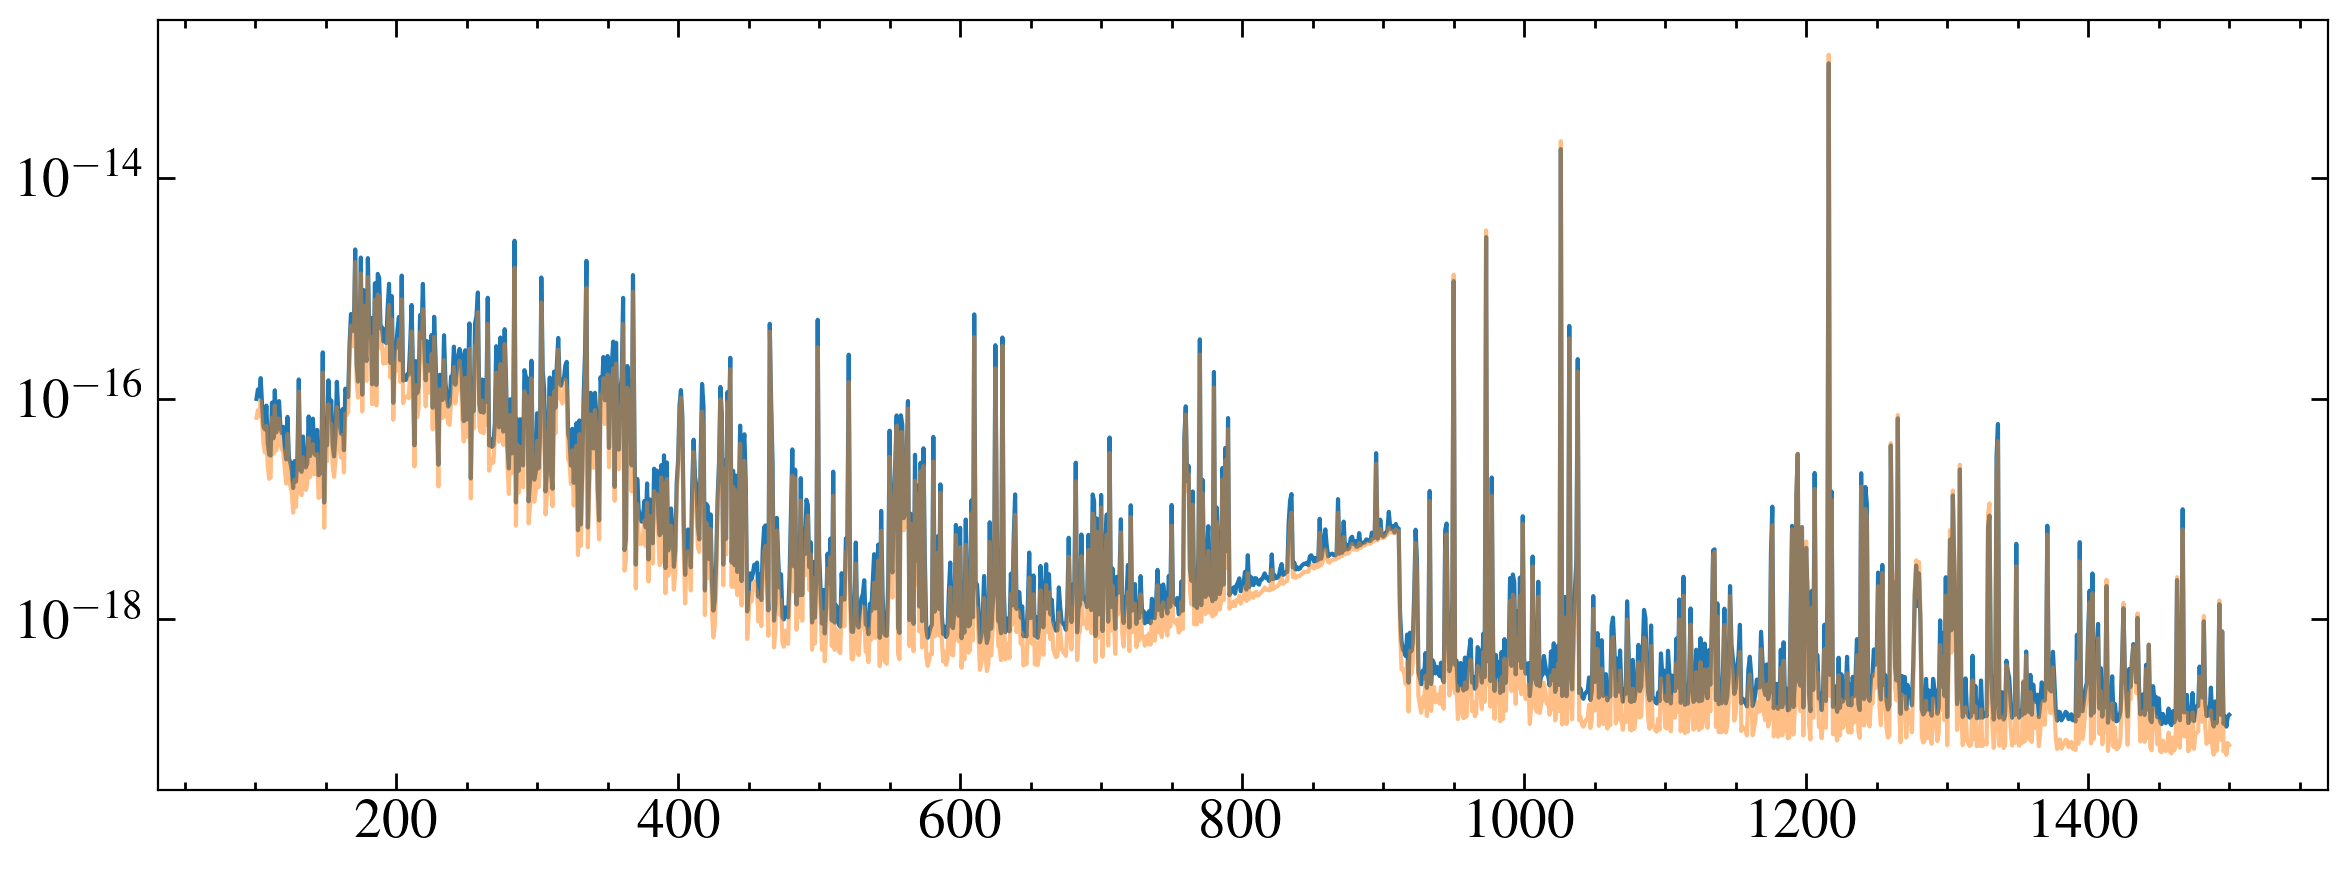

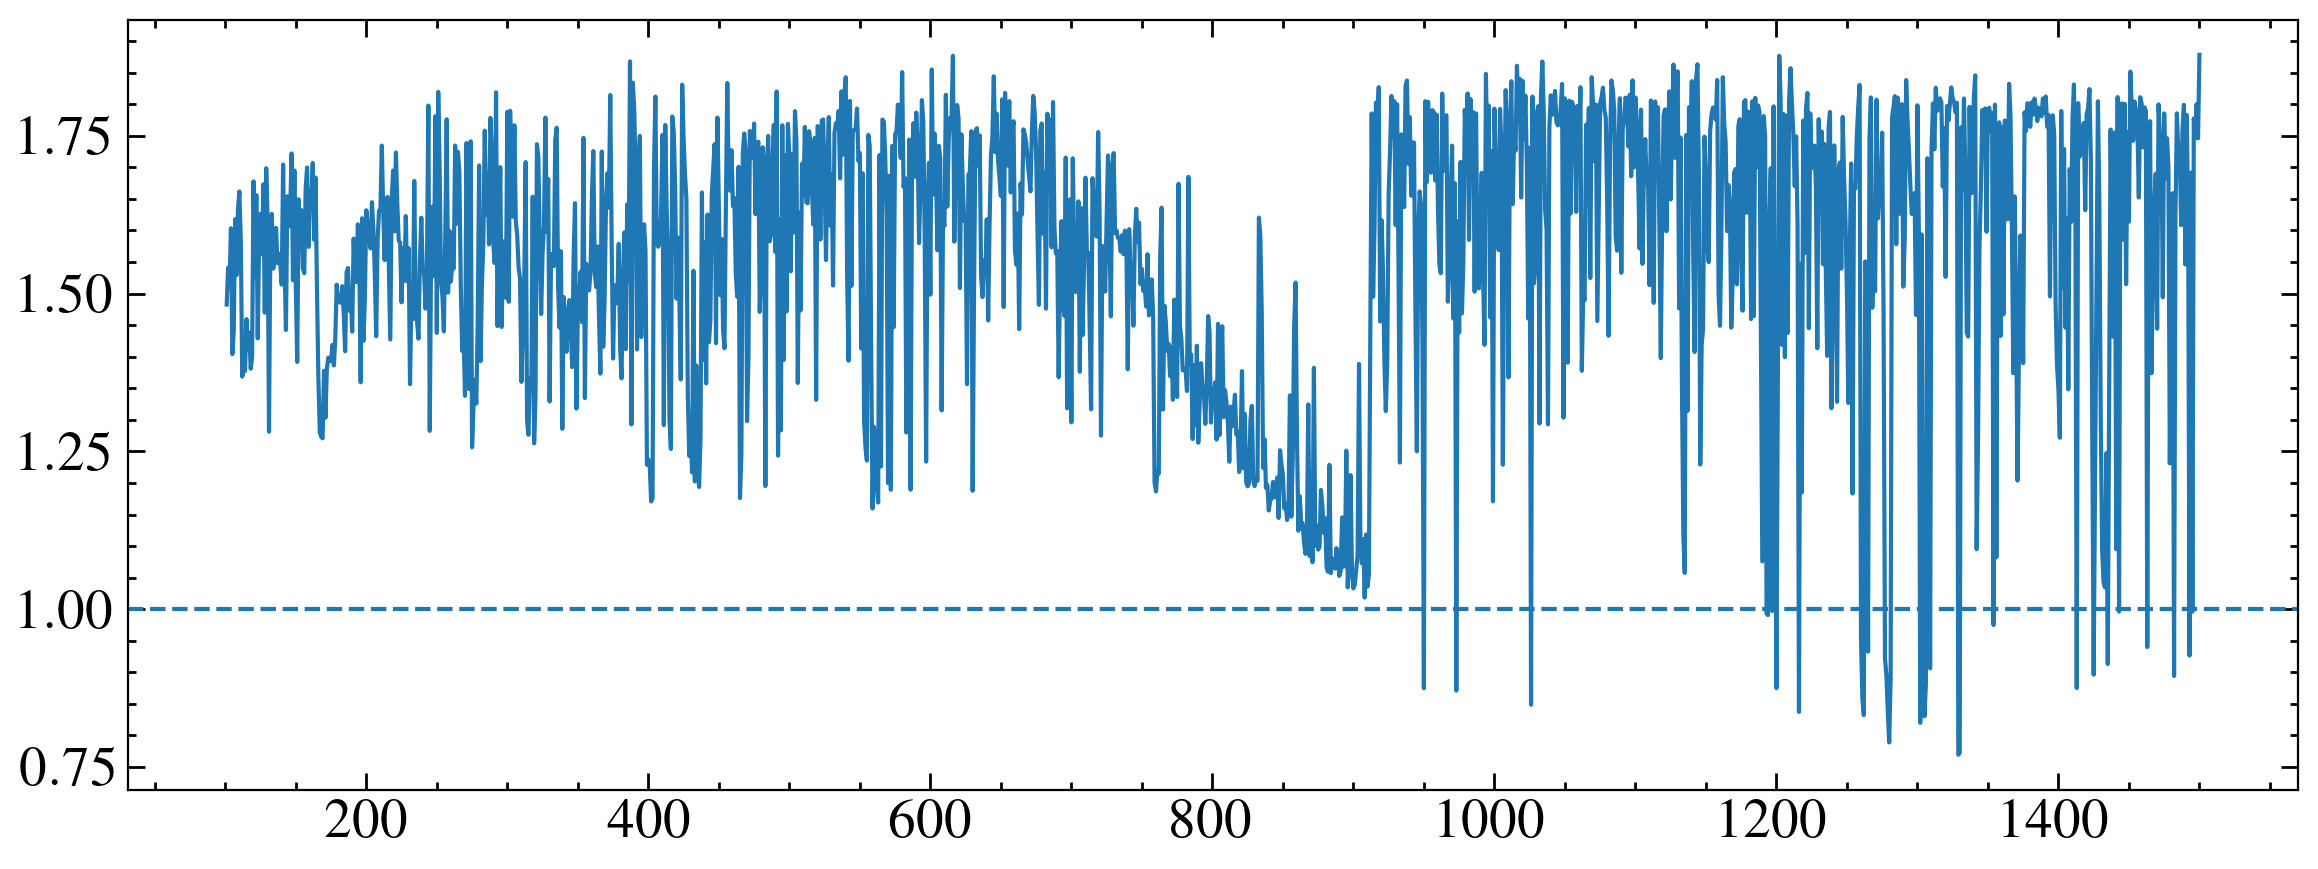

/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_15A_p17.fits
gj_15A


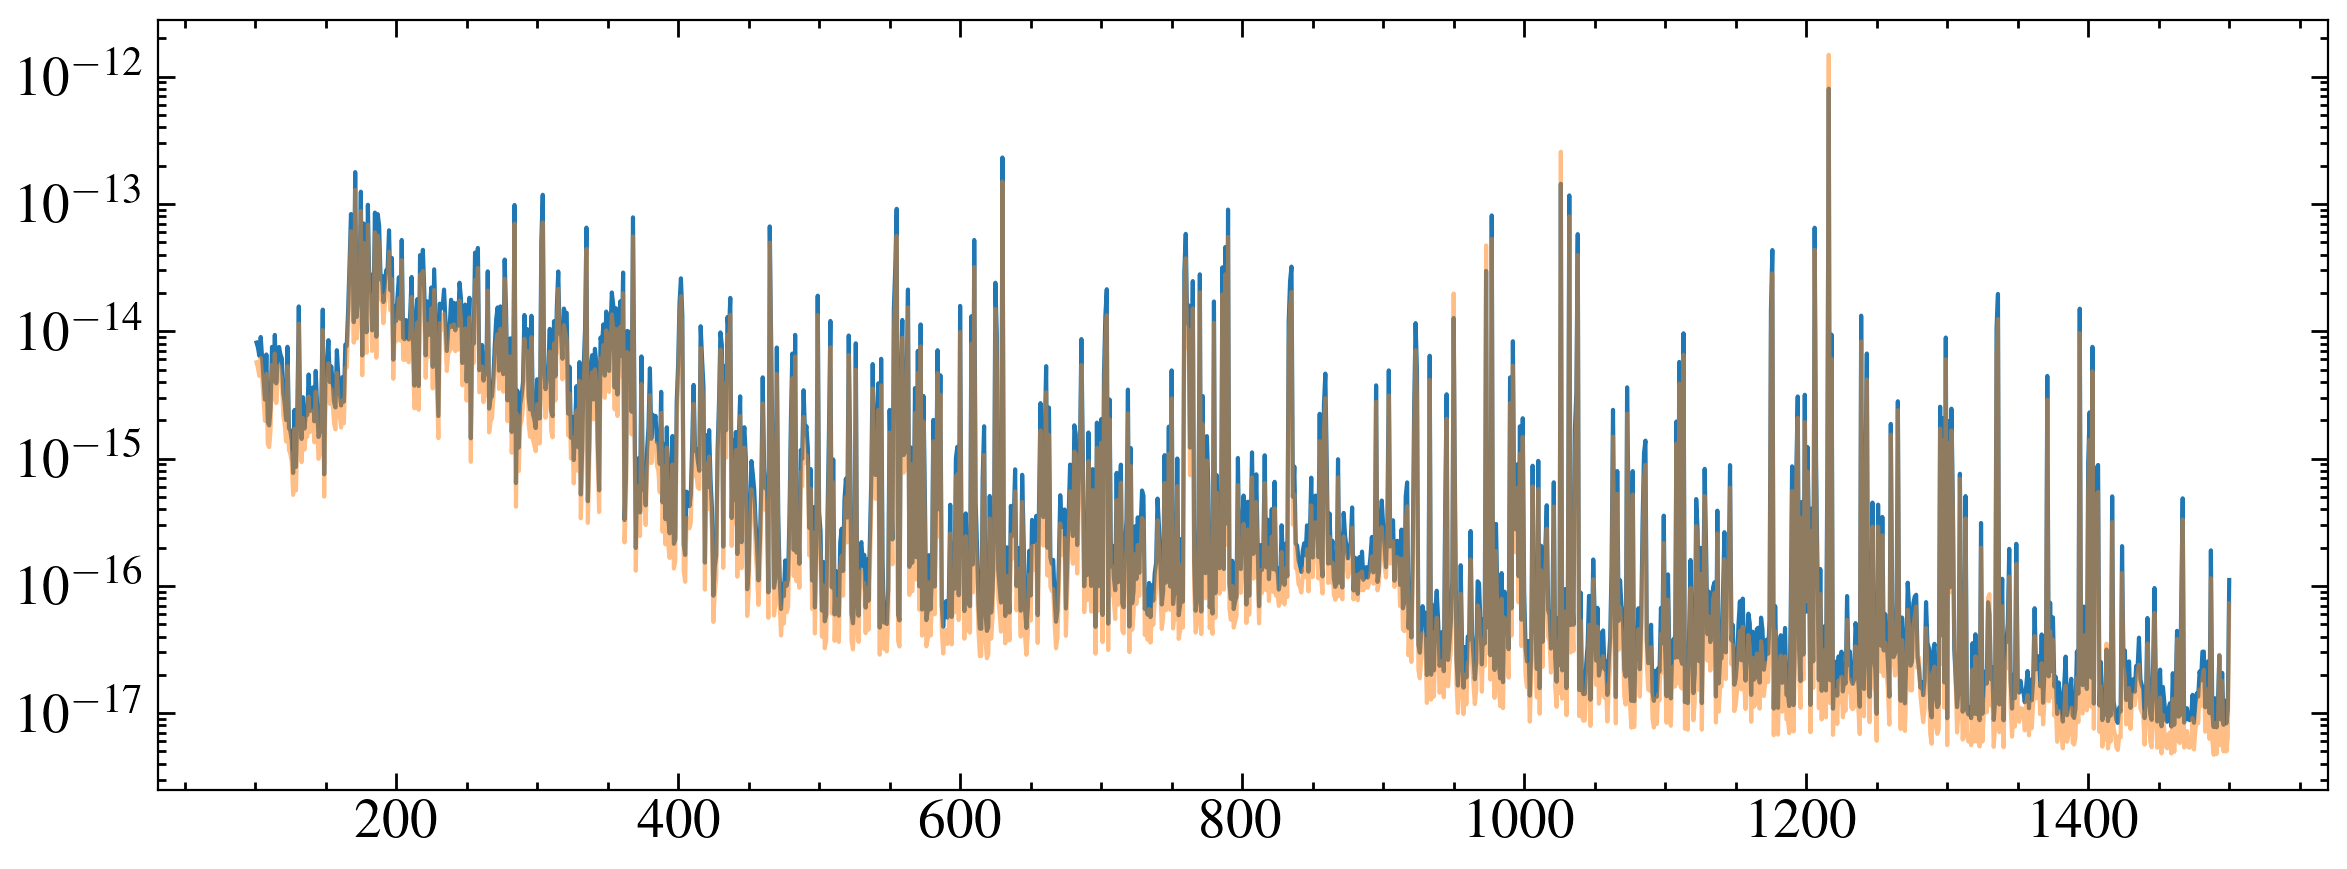

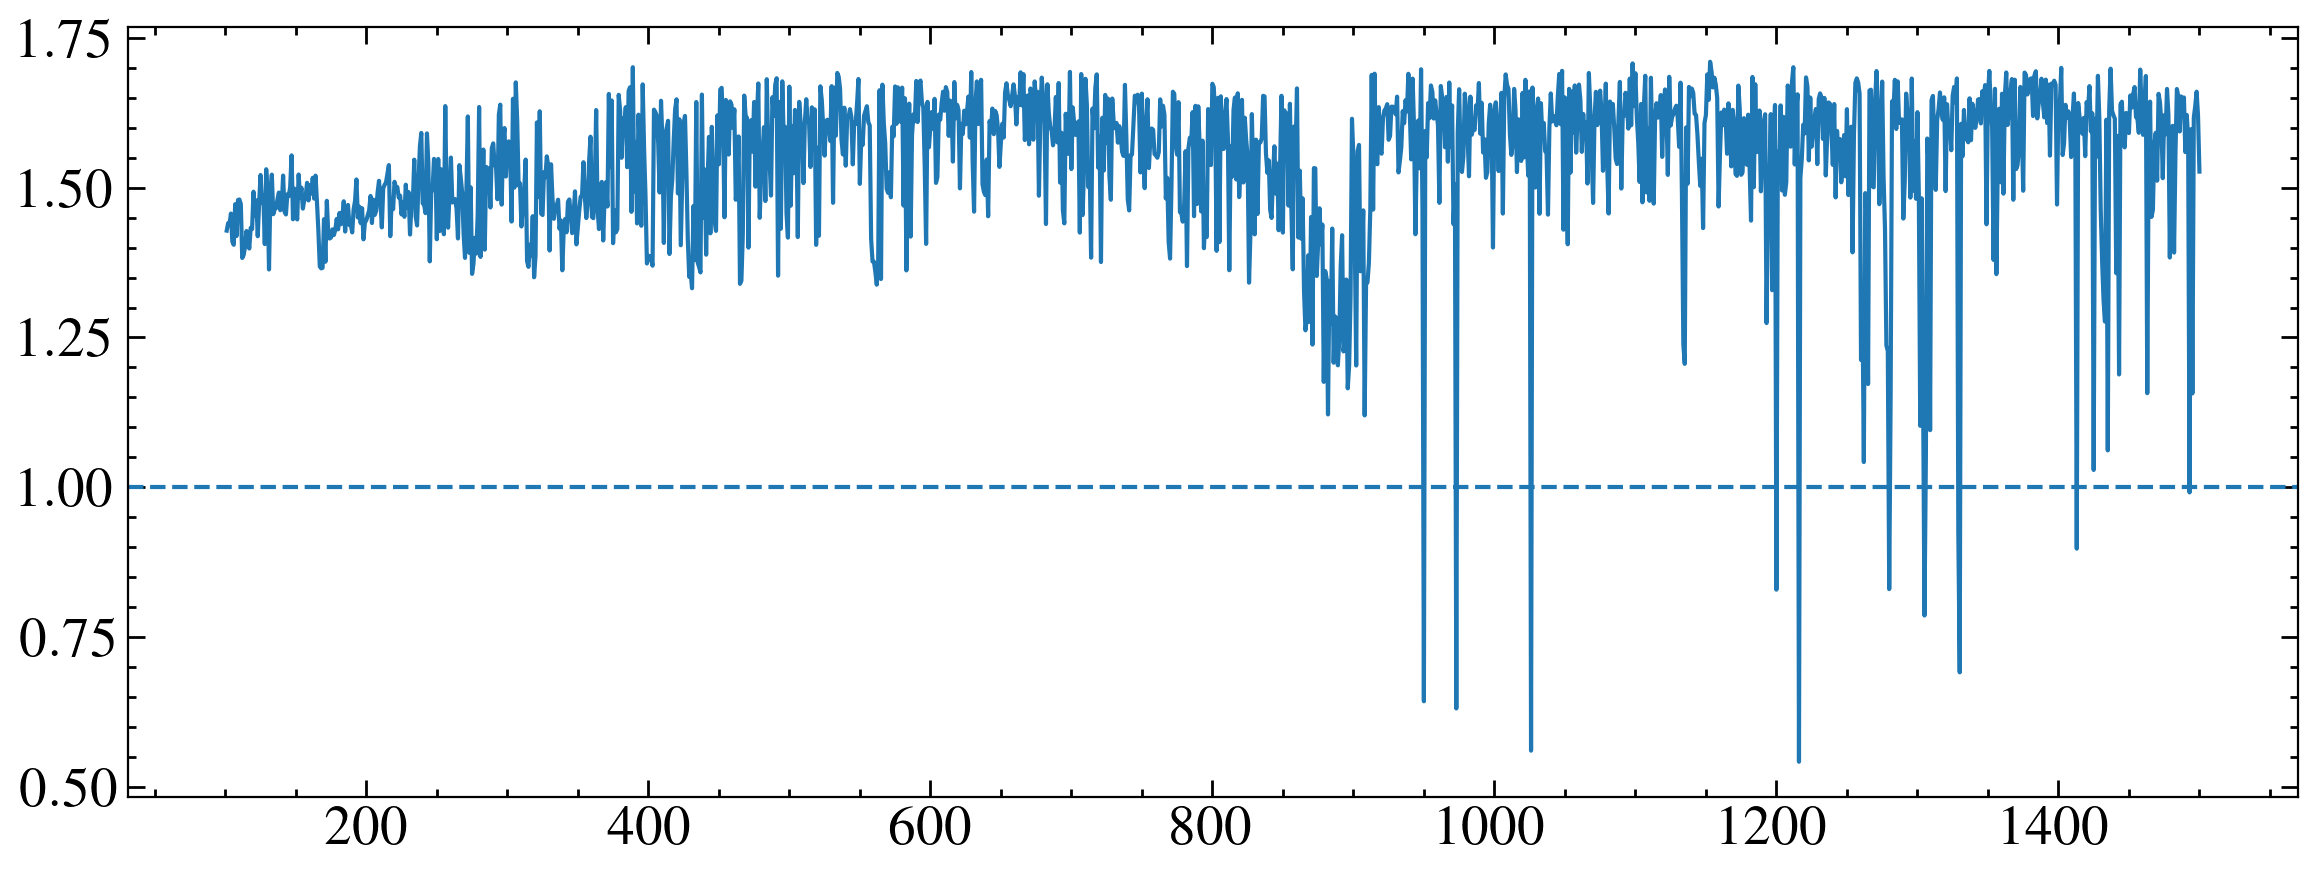

/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_163_p17.fits
gj_163


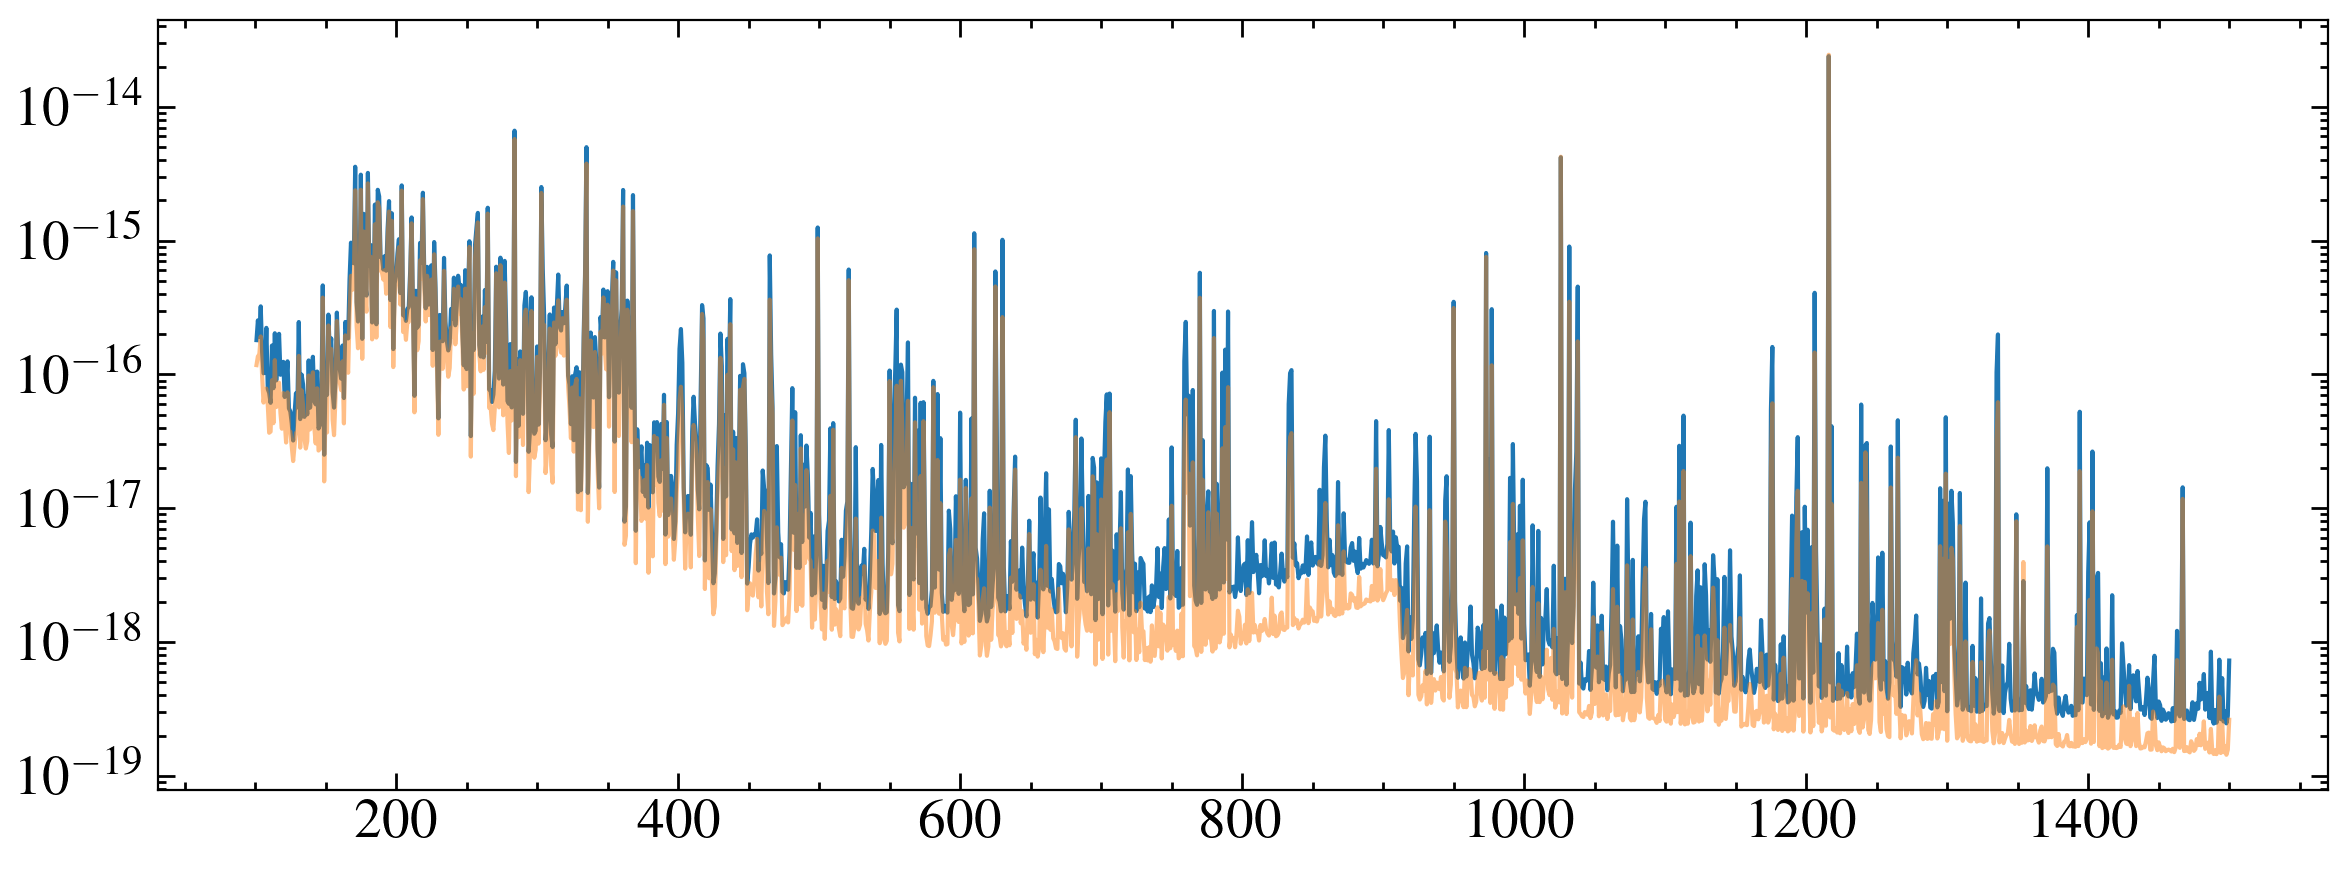

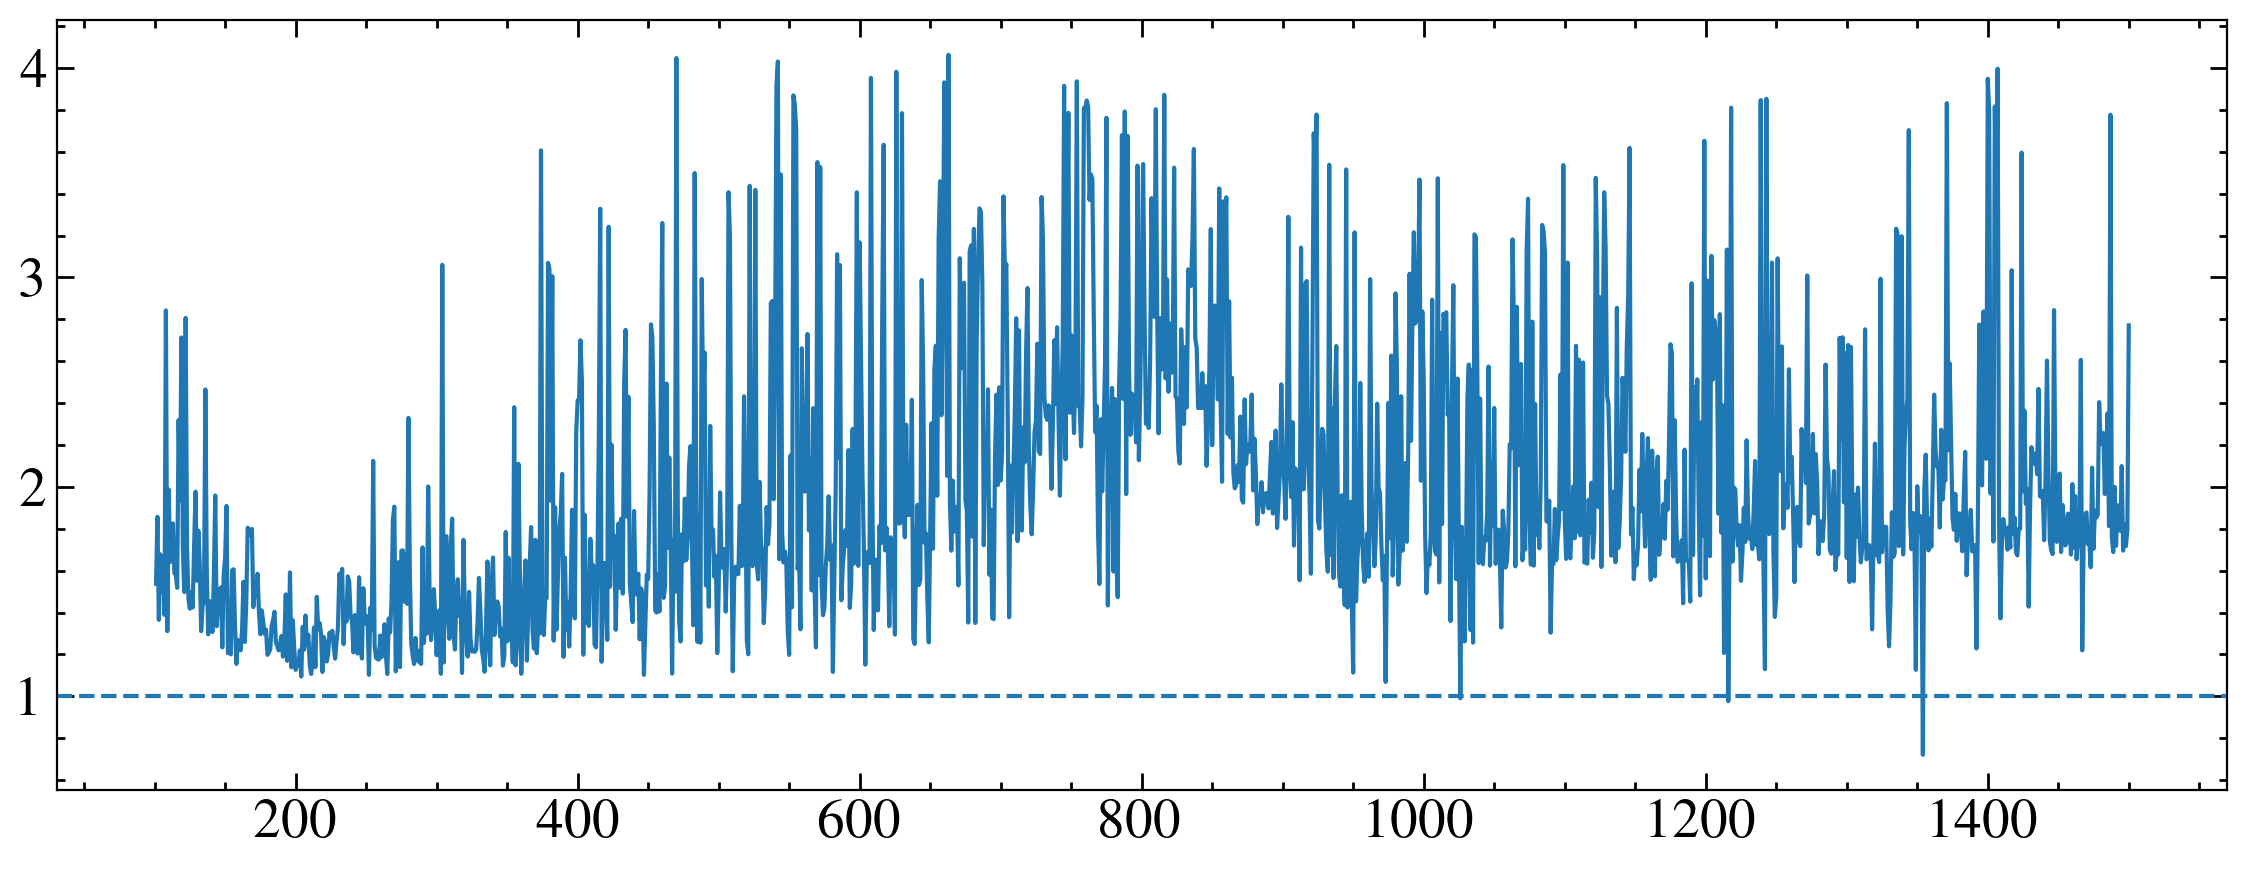

/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_649_p17.fits
gj_649


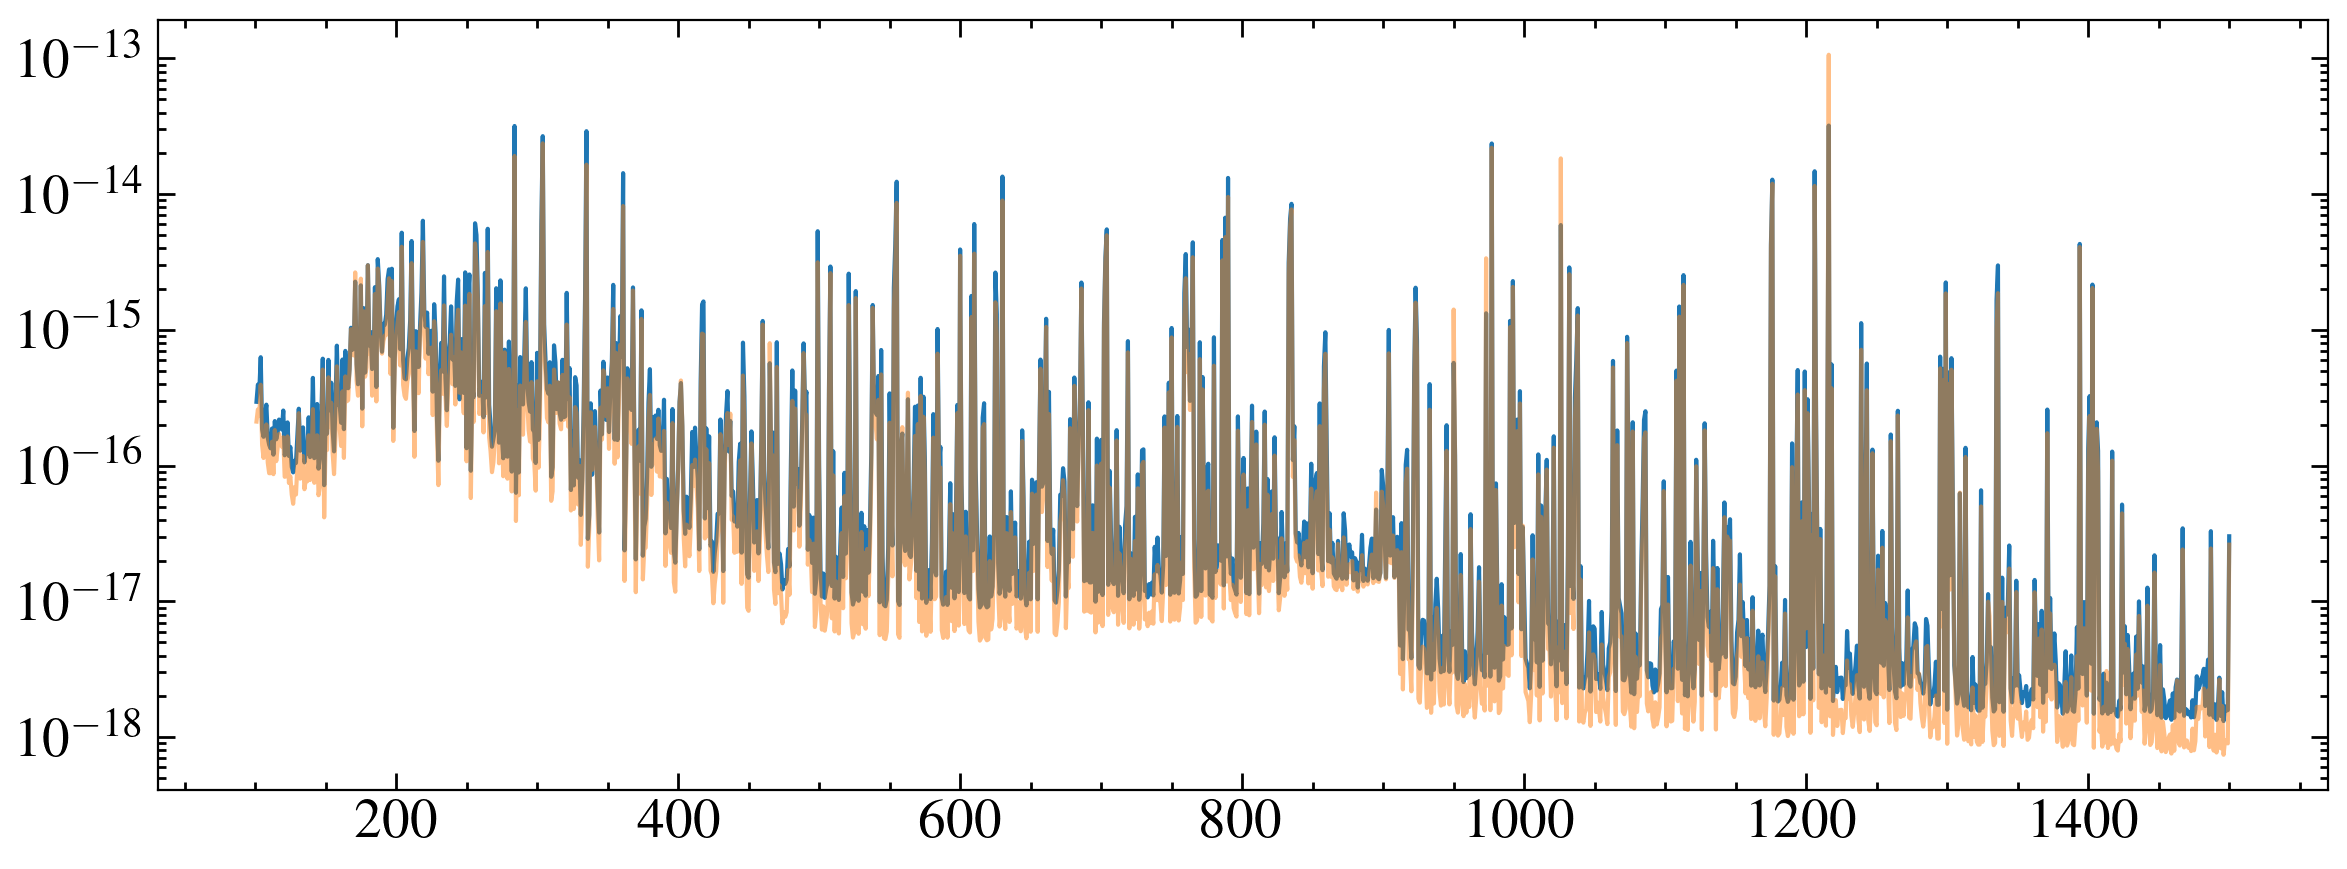

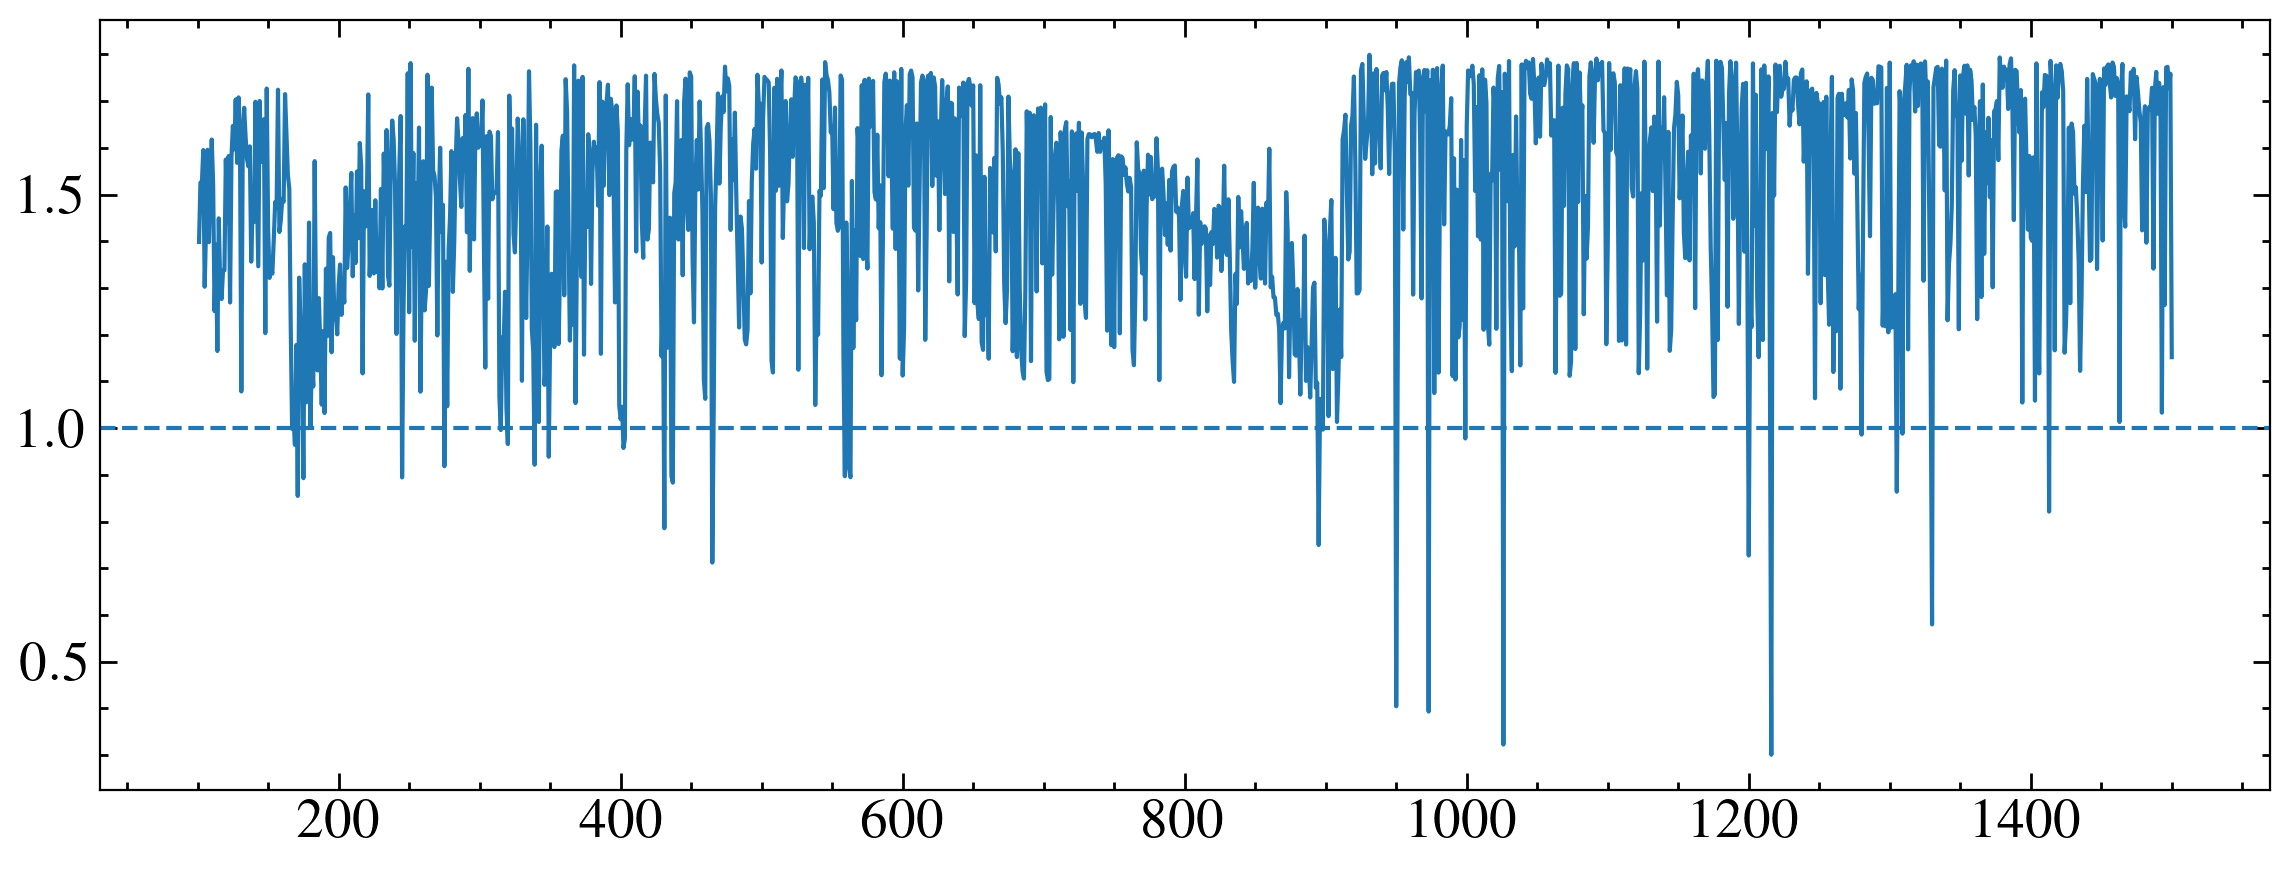

/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_674_p17.fits
gj_674


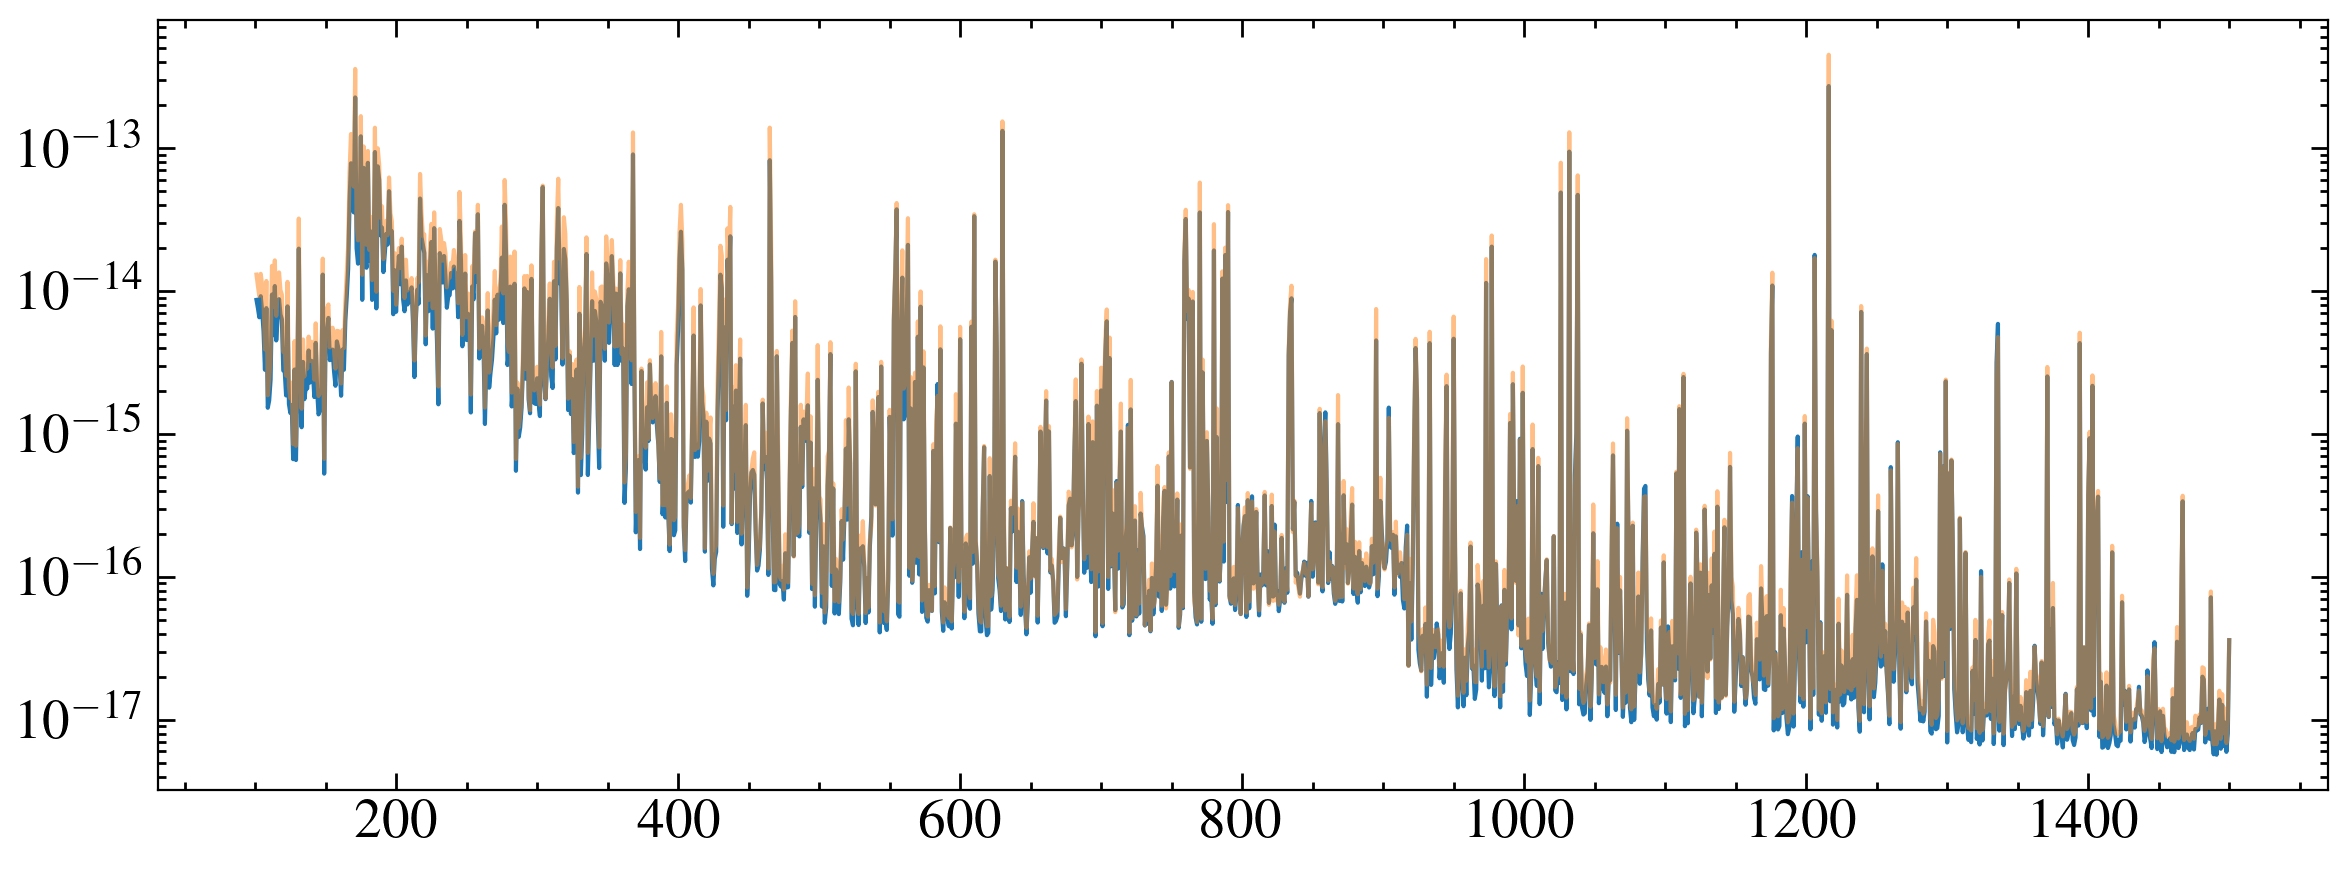

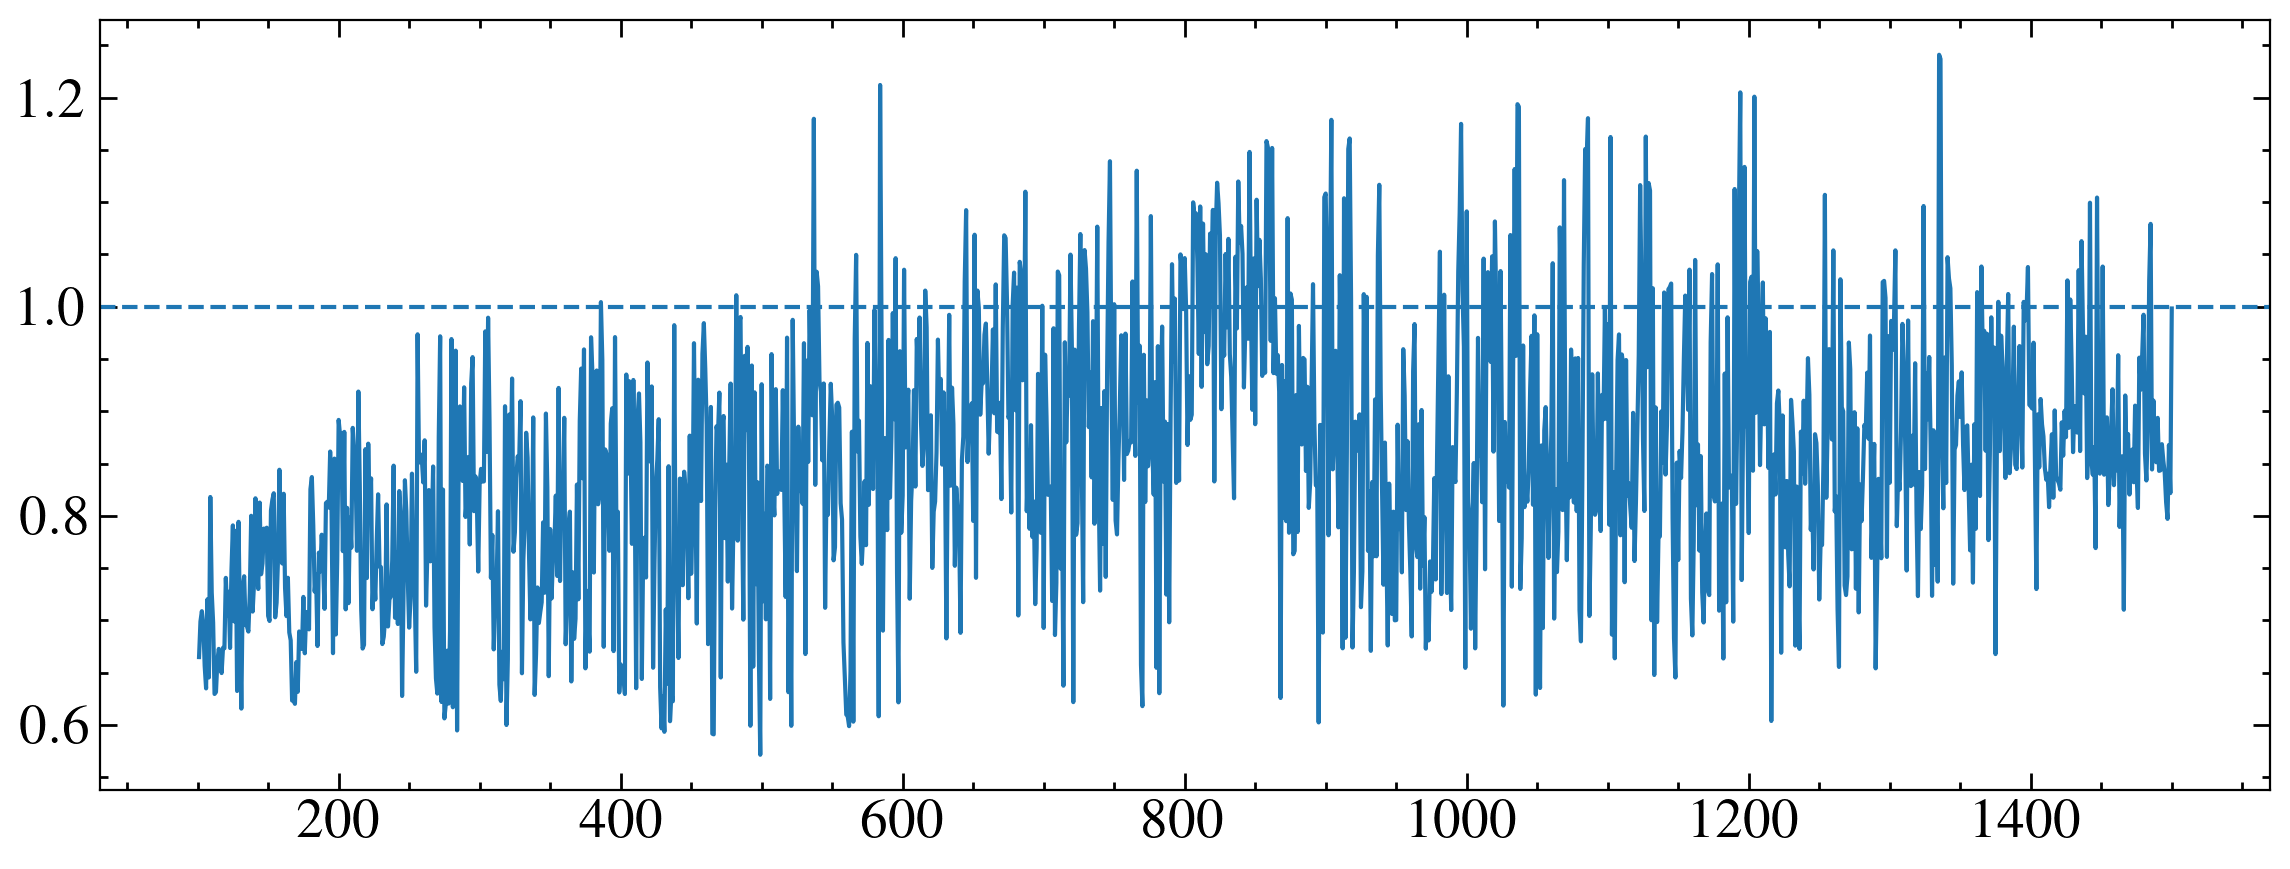

/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_676A_p17.fits
gj_676A


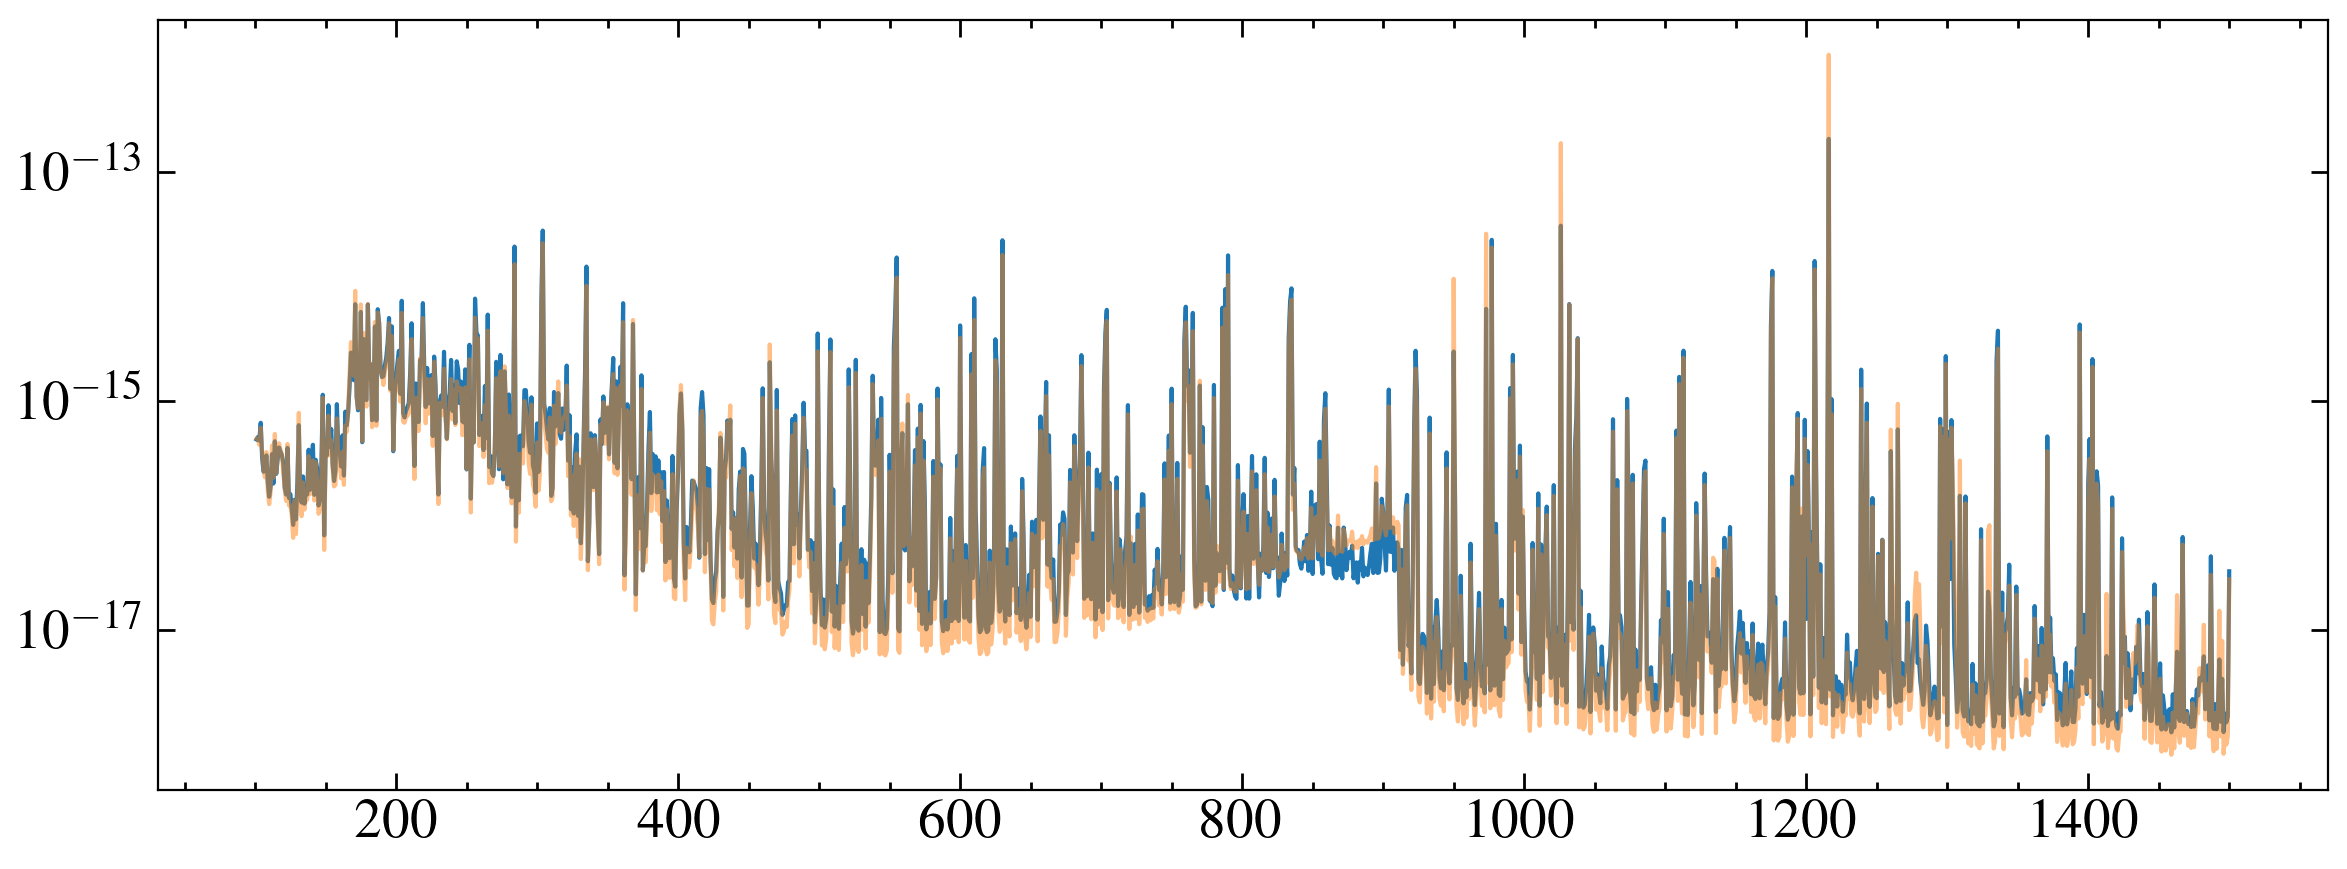

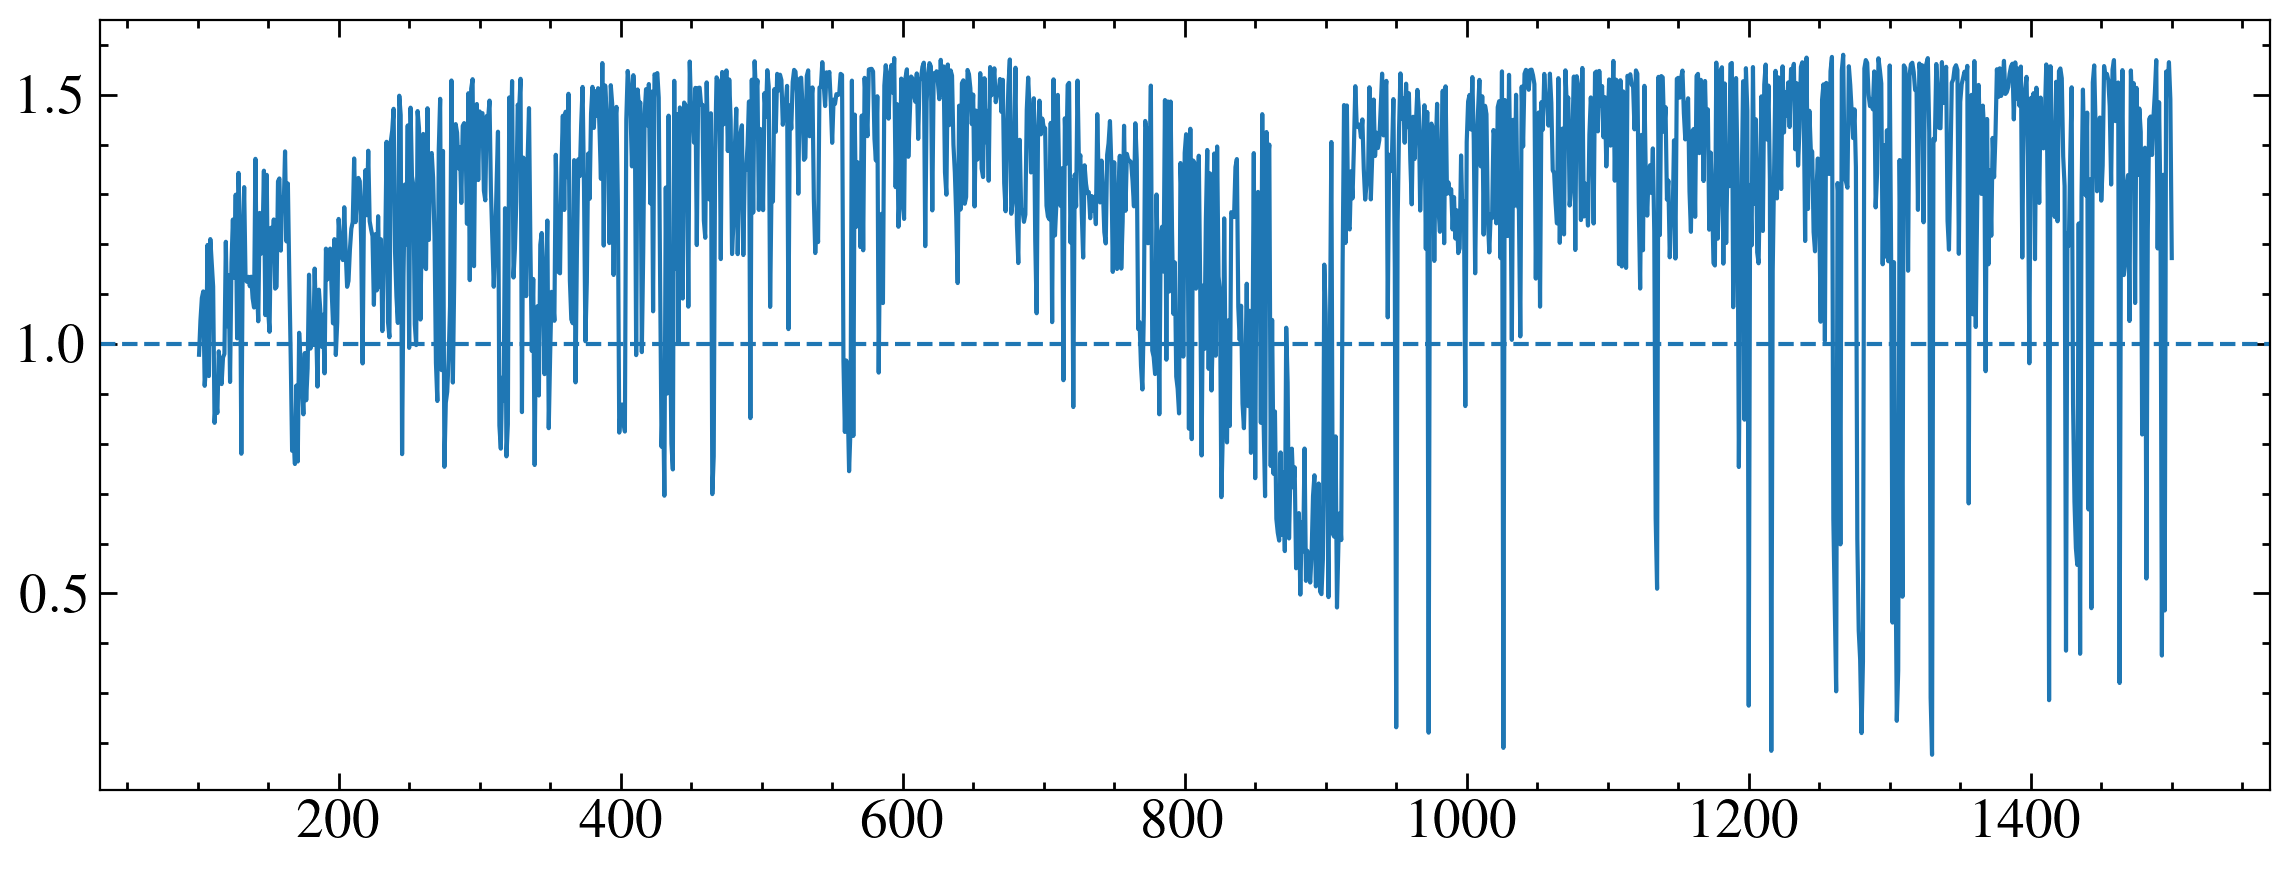

/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_729_p17.fits
gj_729


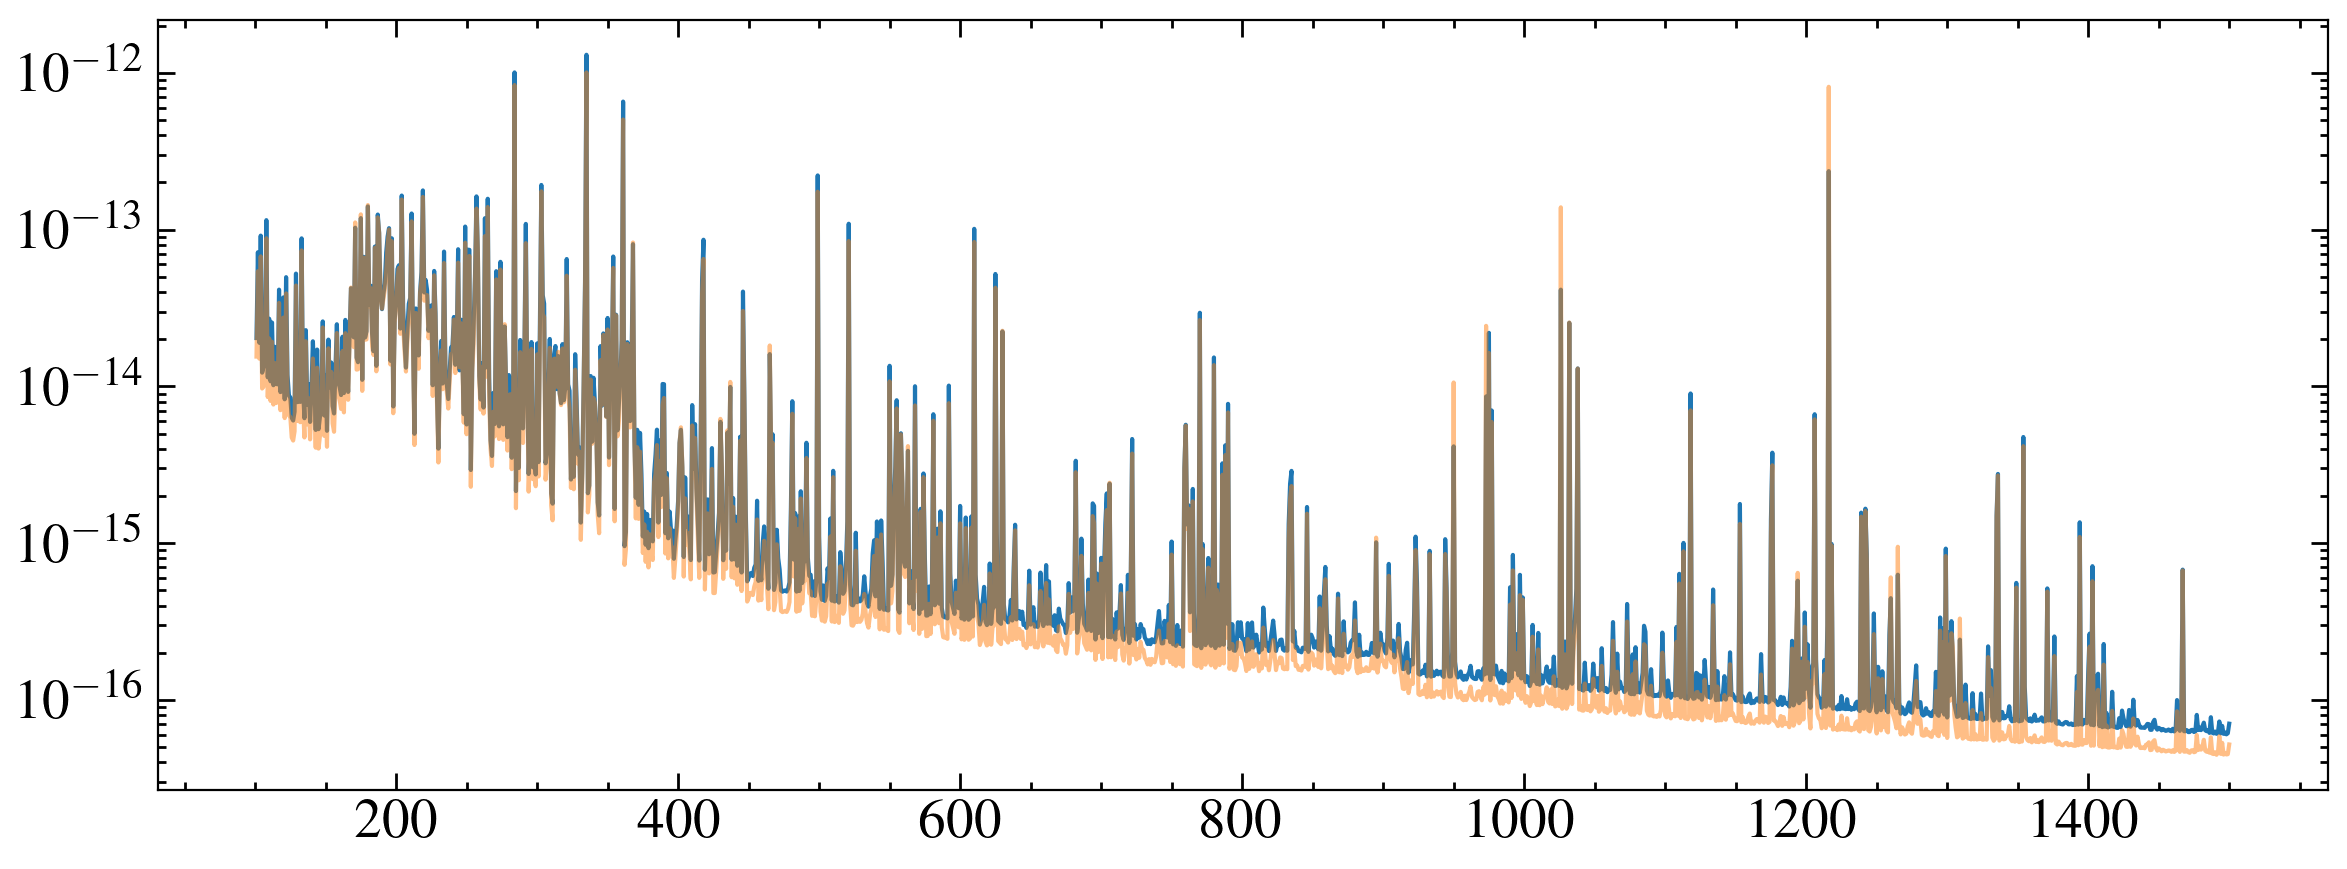

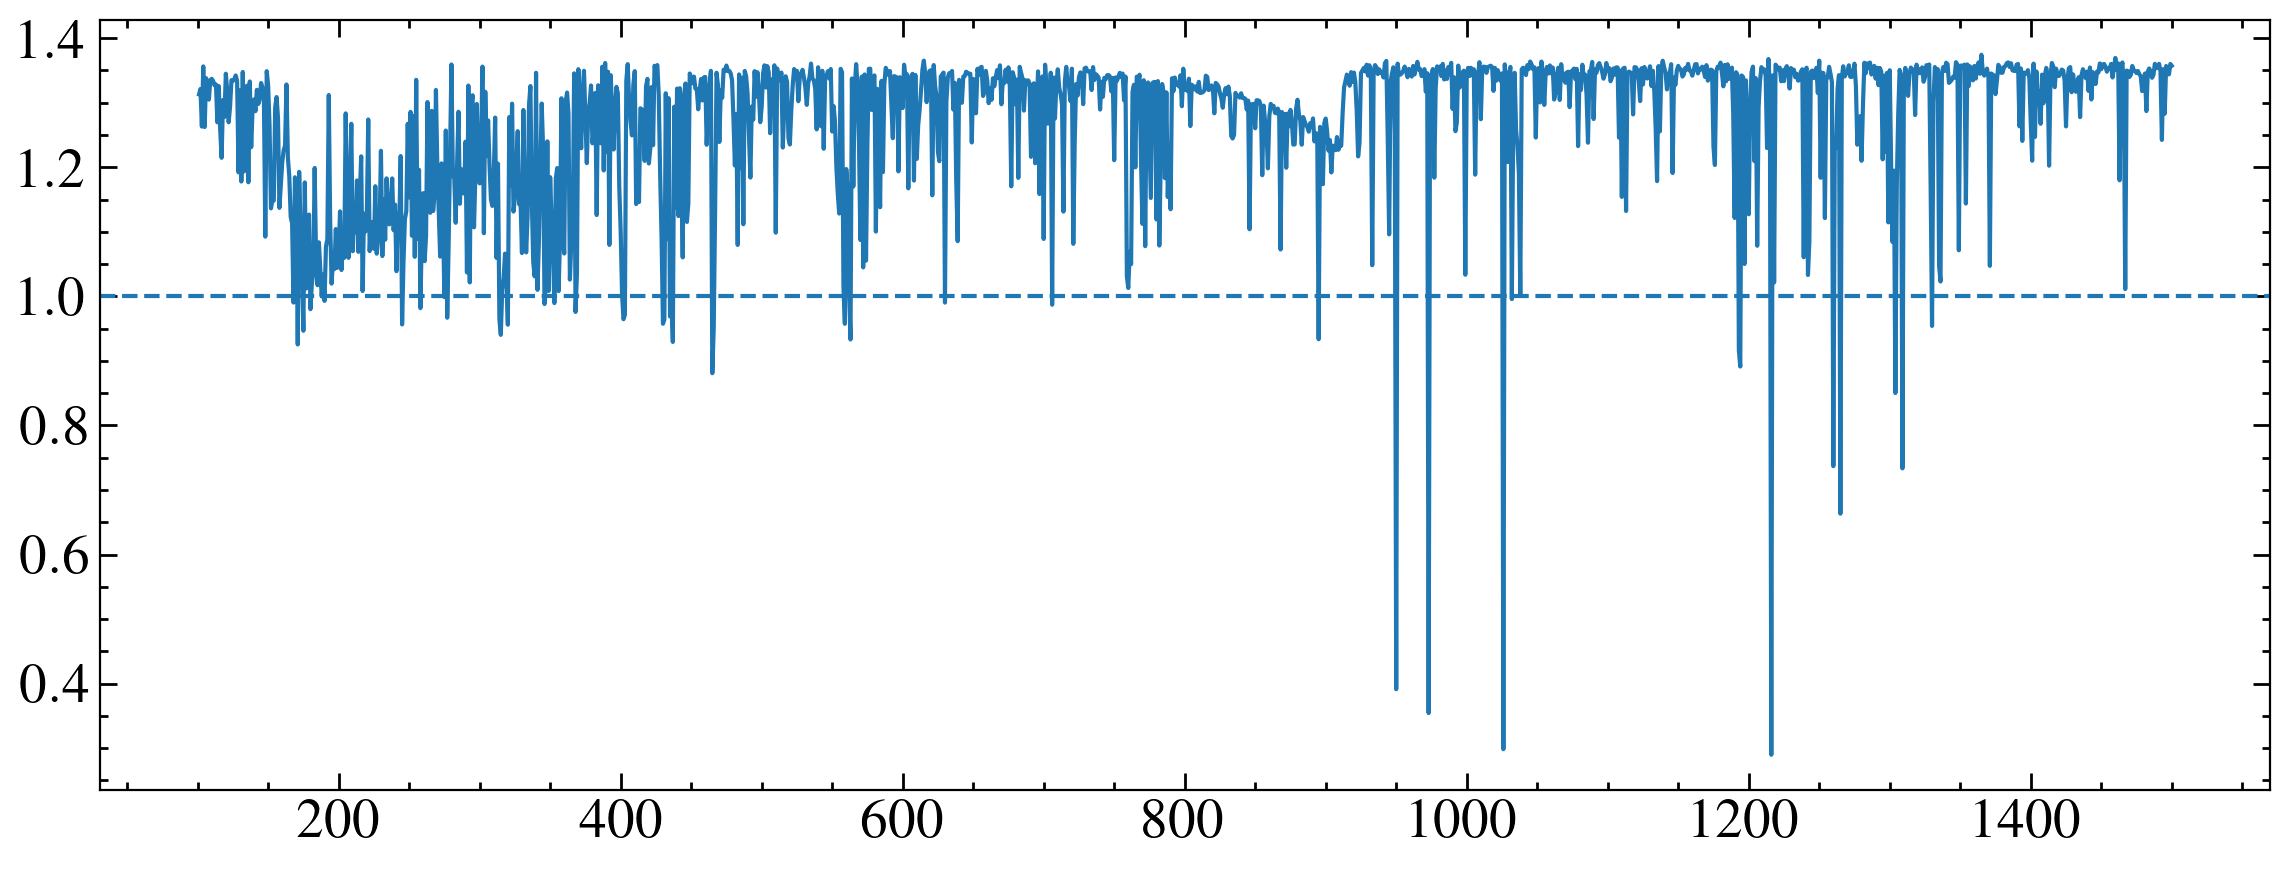

/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_849_p17.fits
gj_849


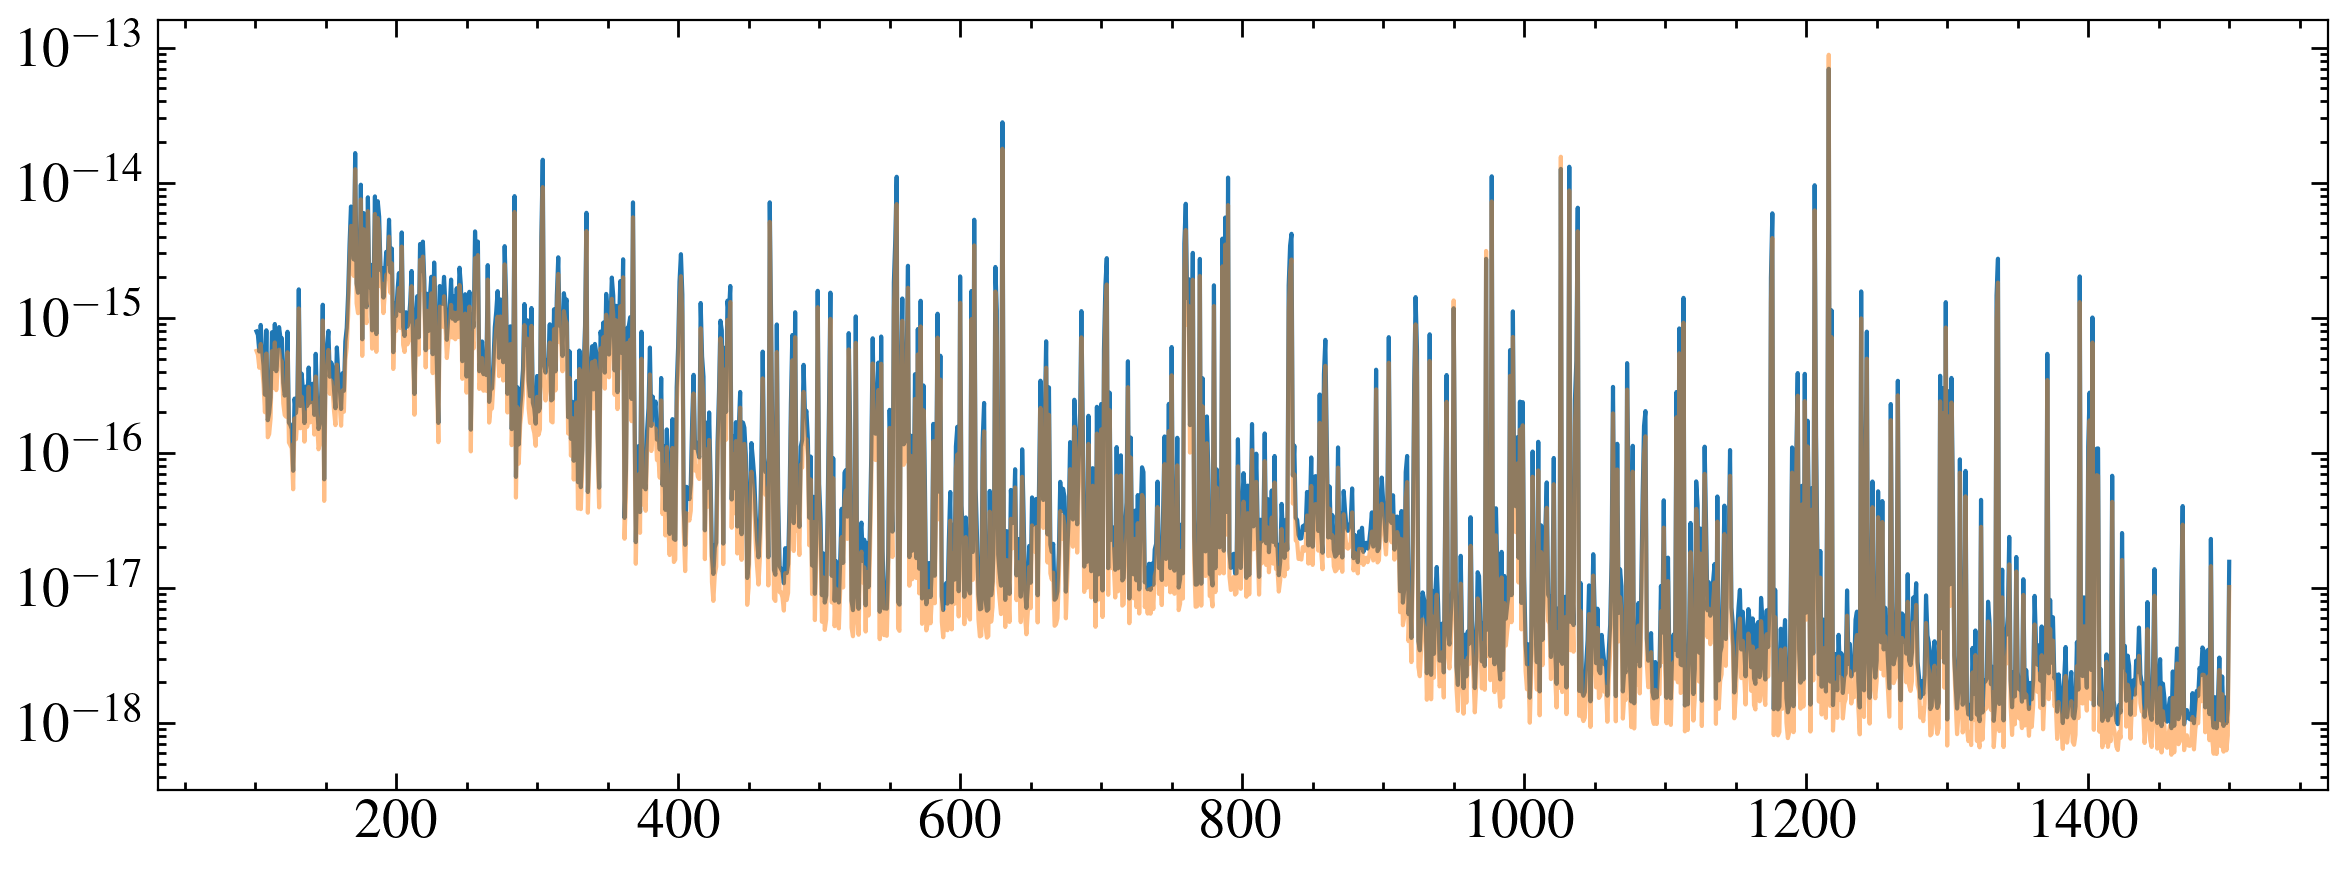

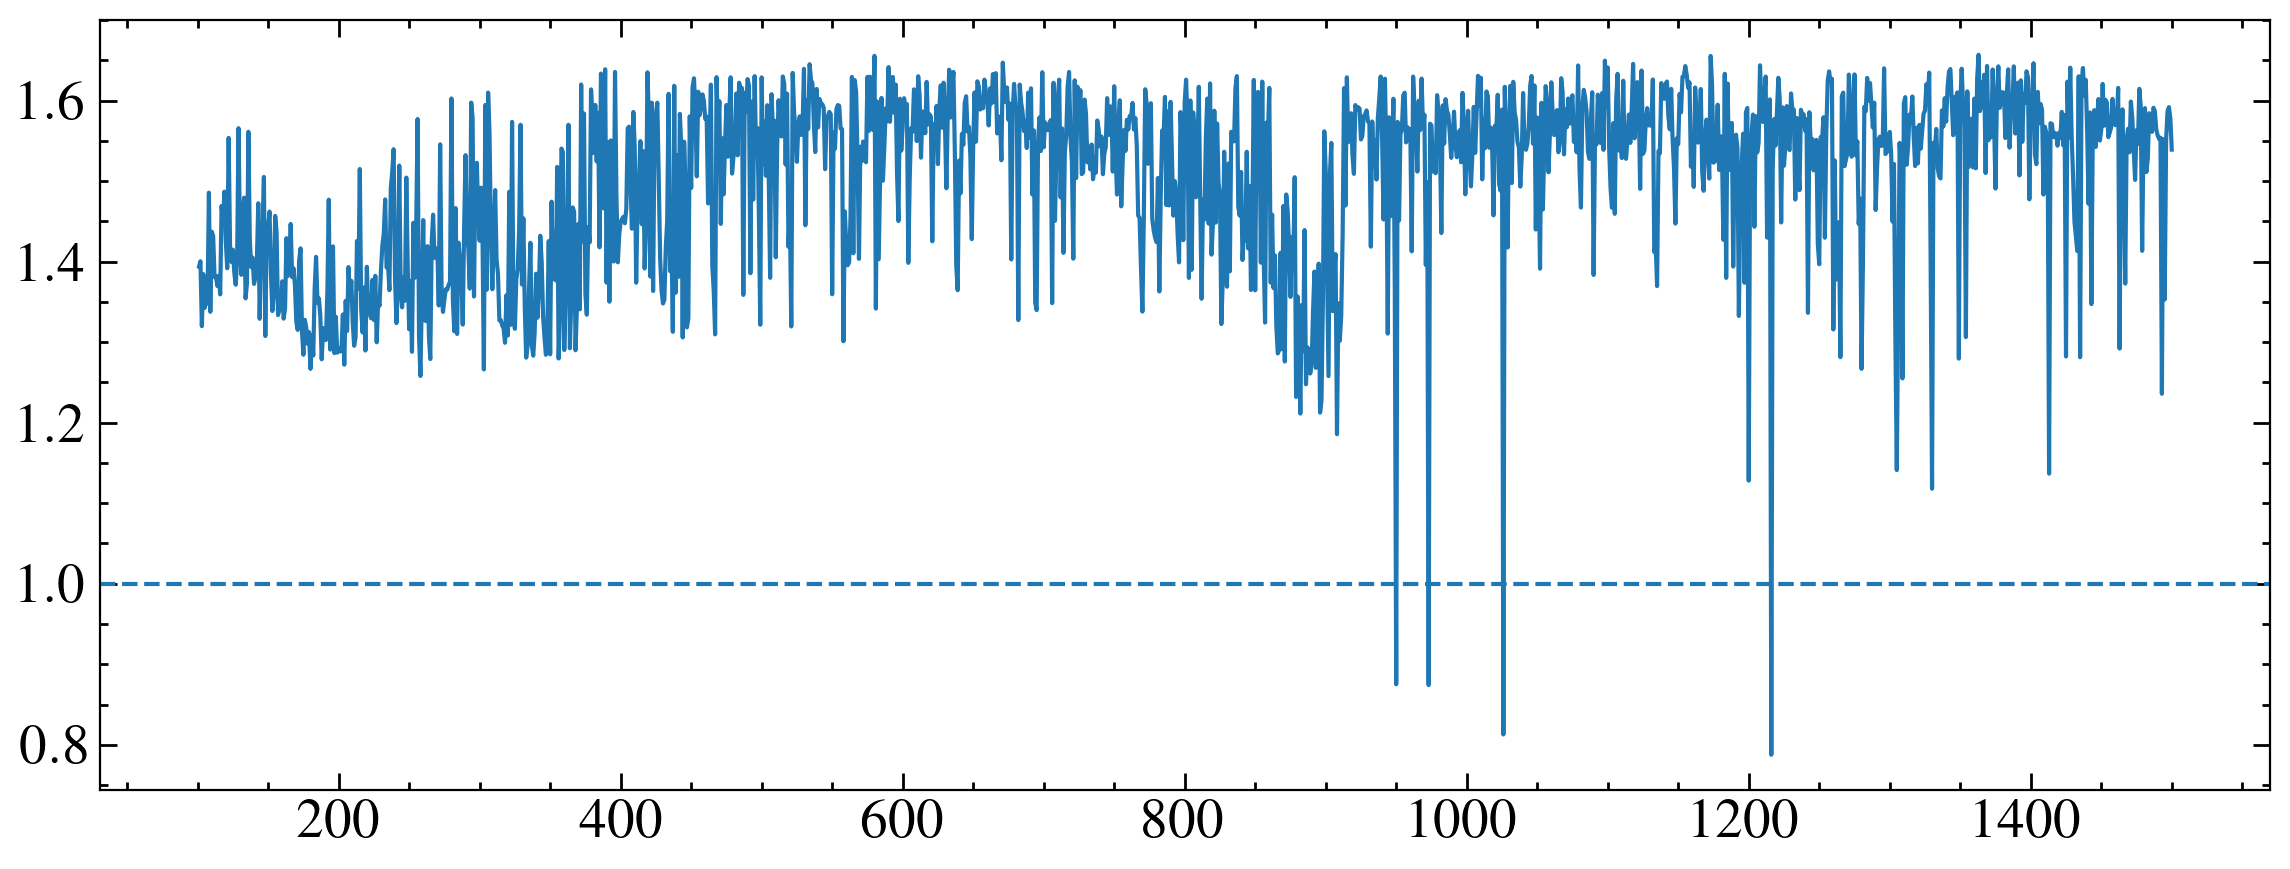

/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_876_p17.fits
gj_876


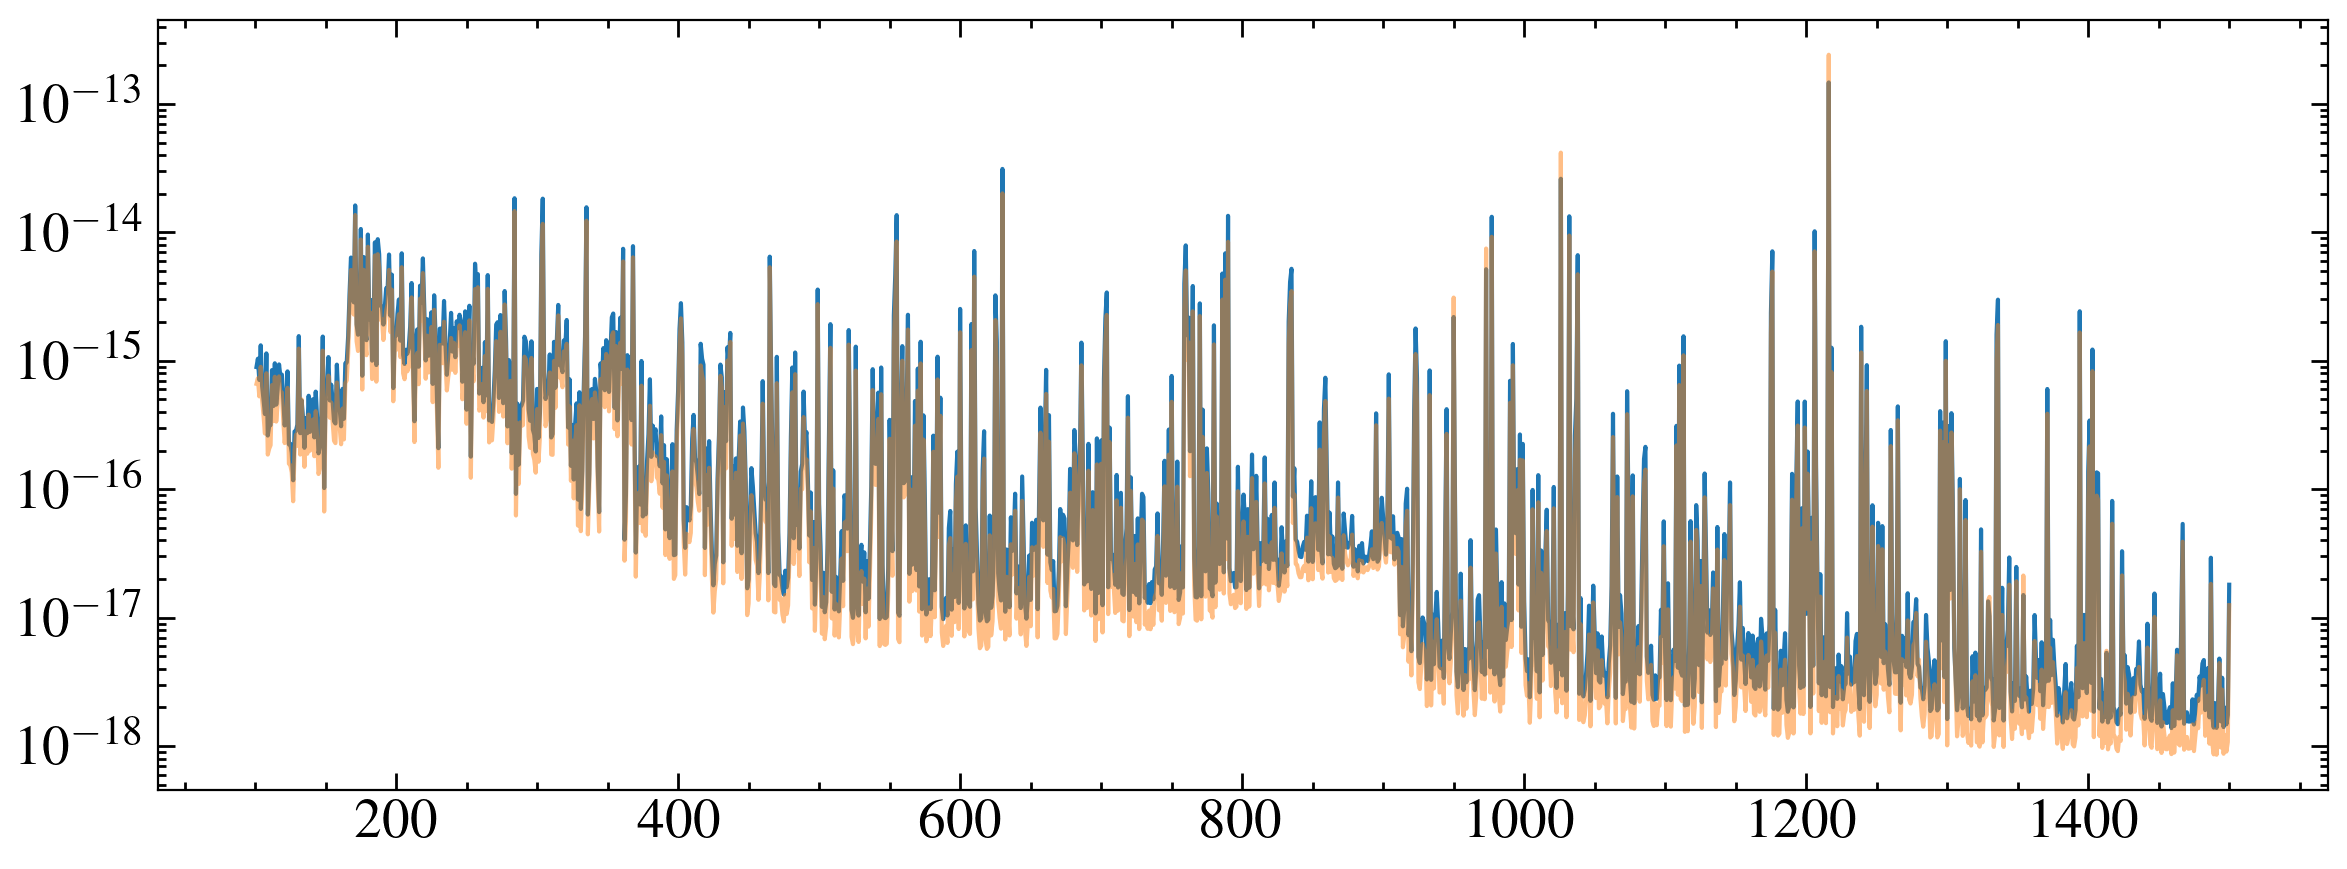

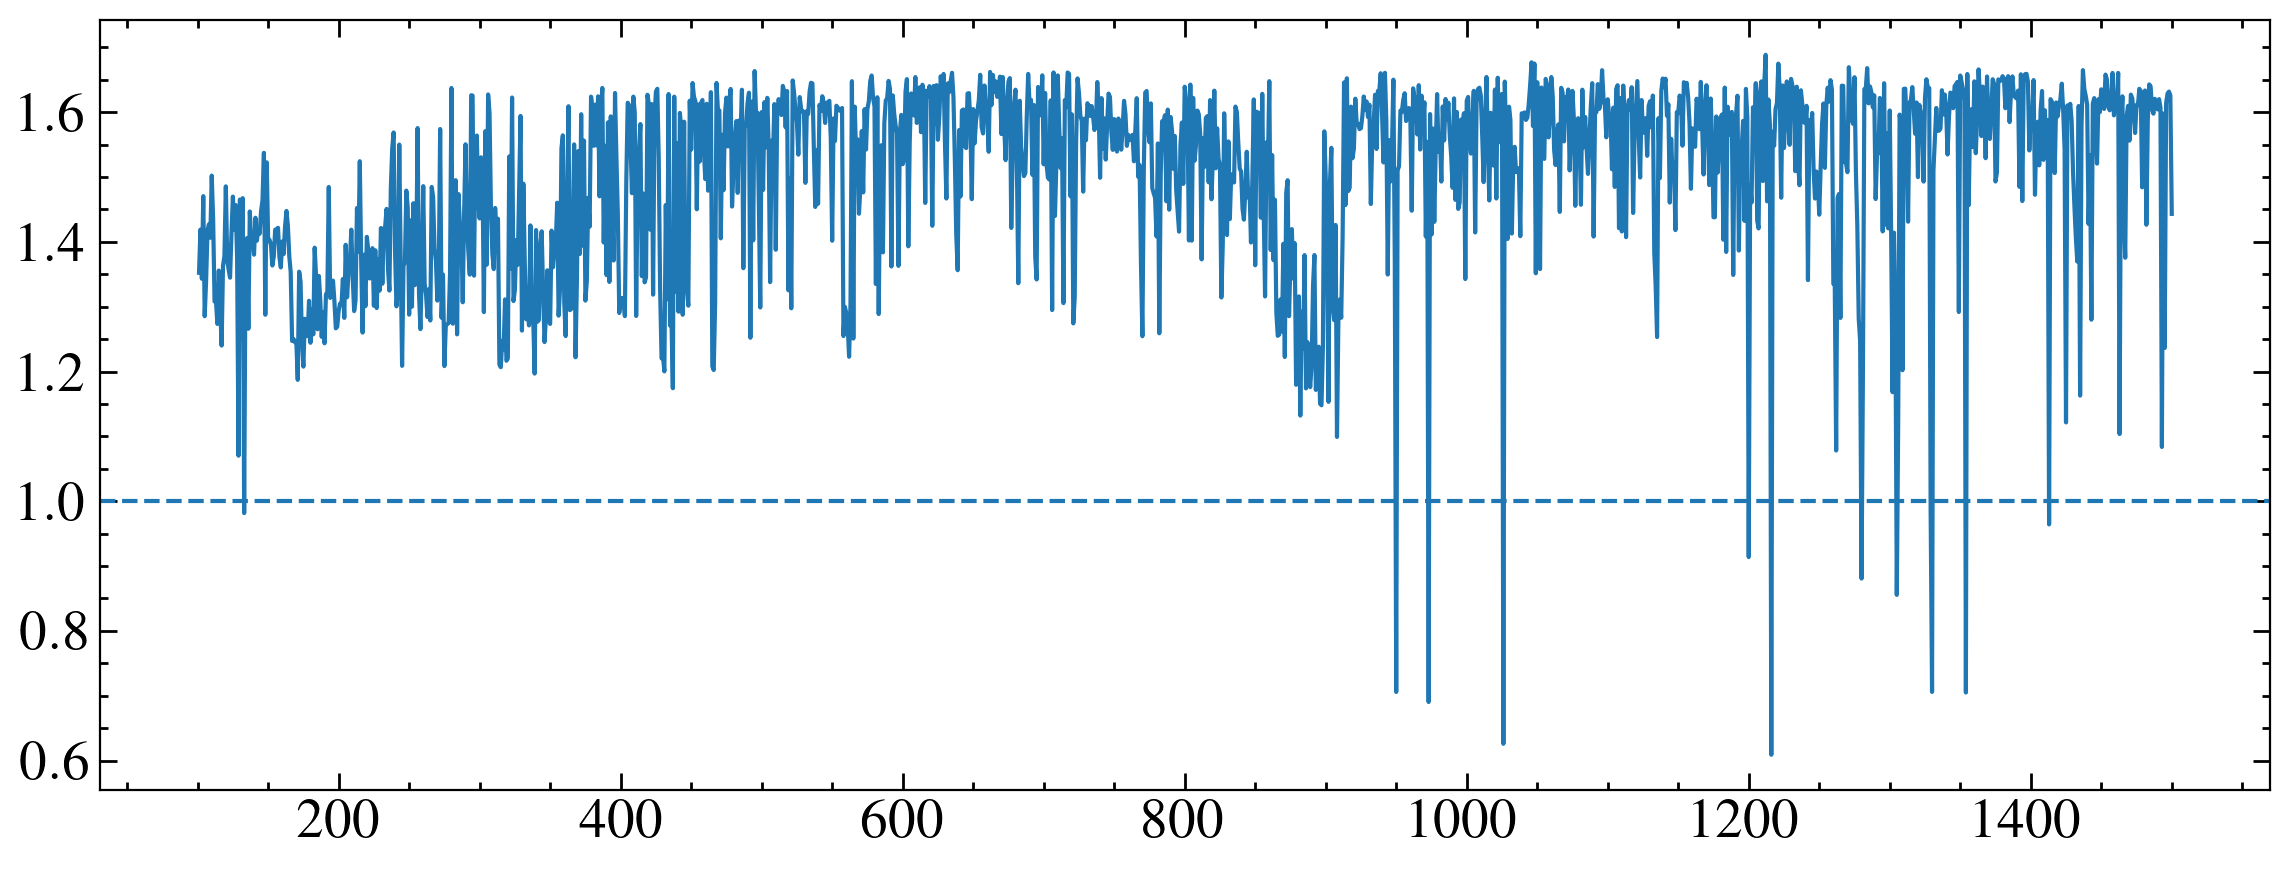

/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_l-980-5_p17.fits
l-980-5


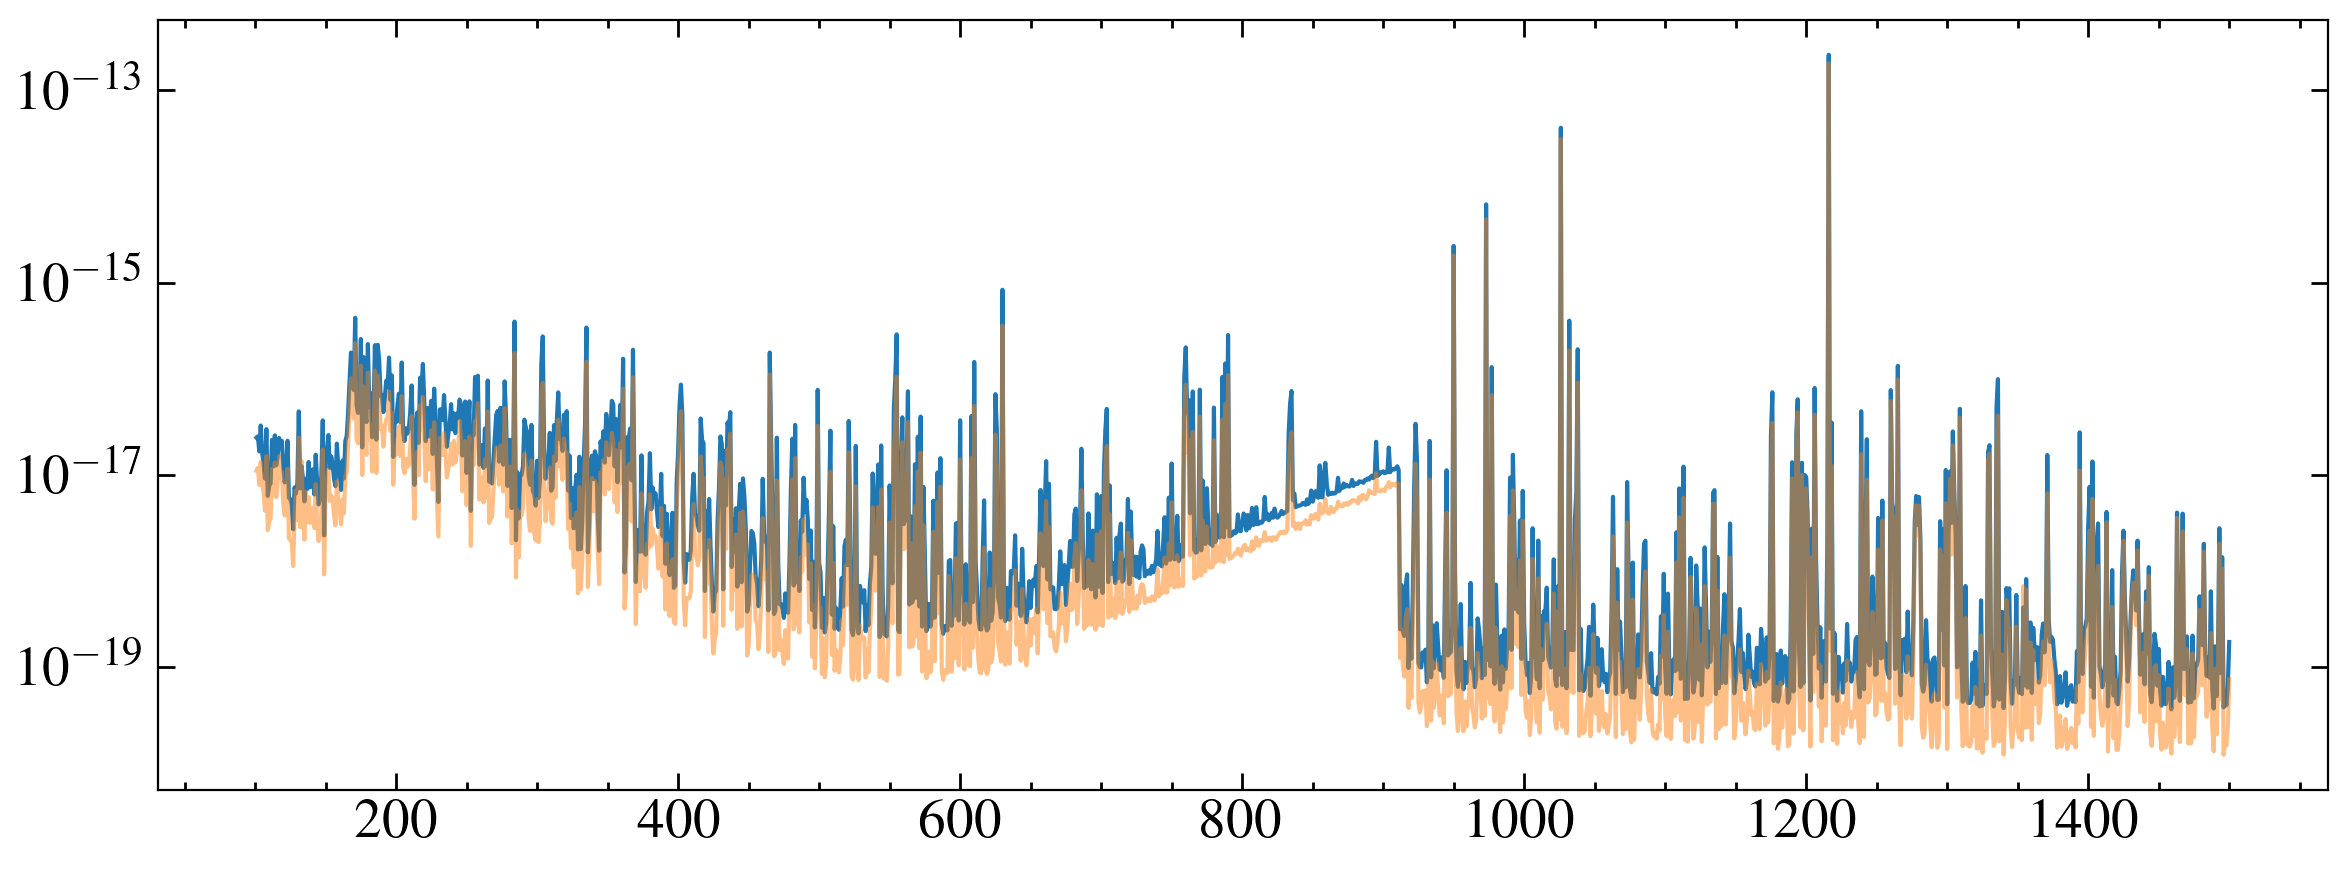

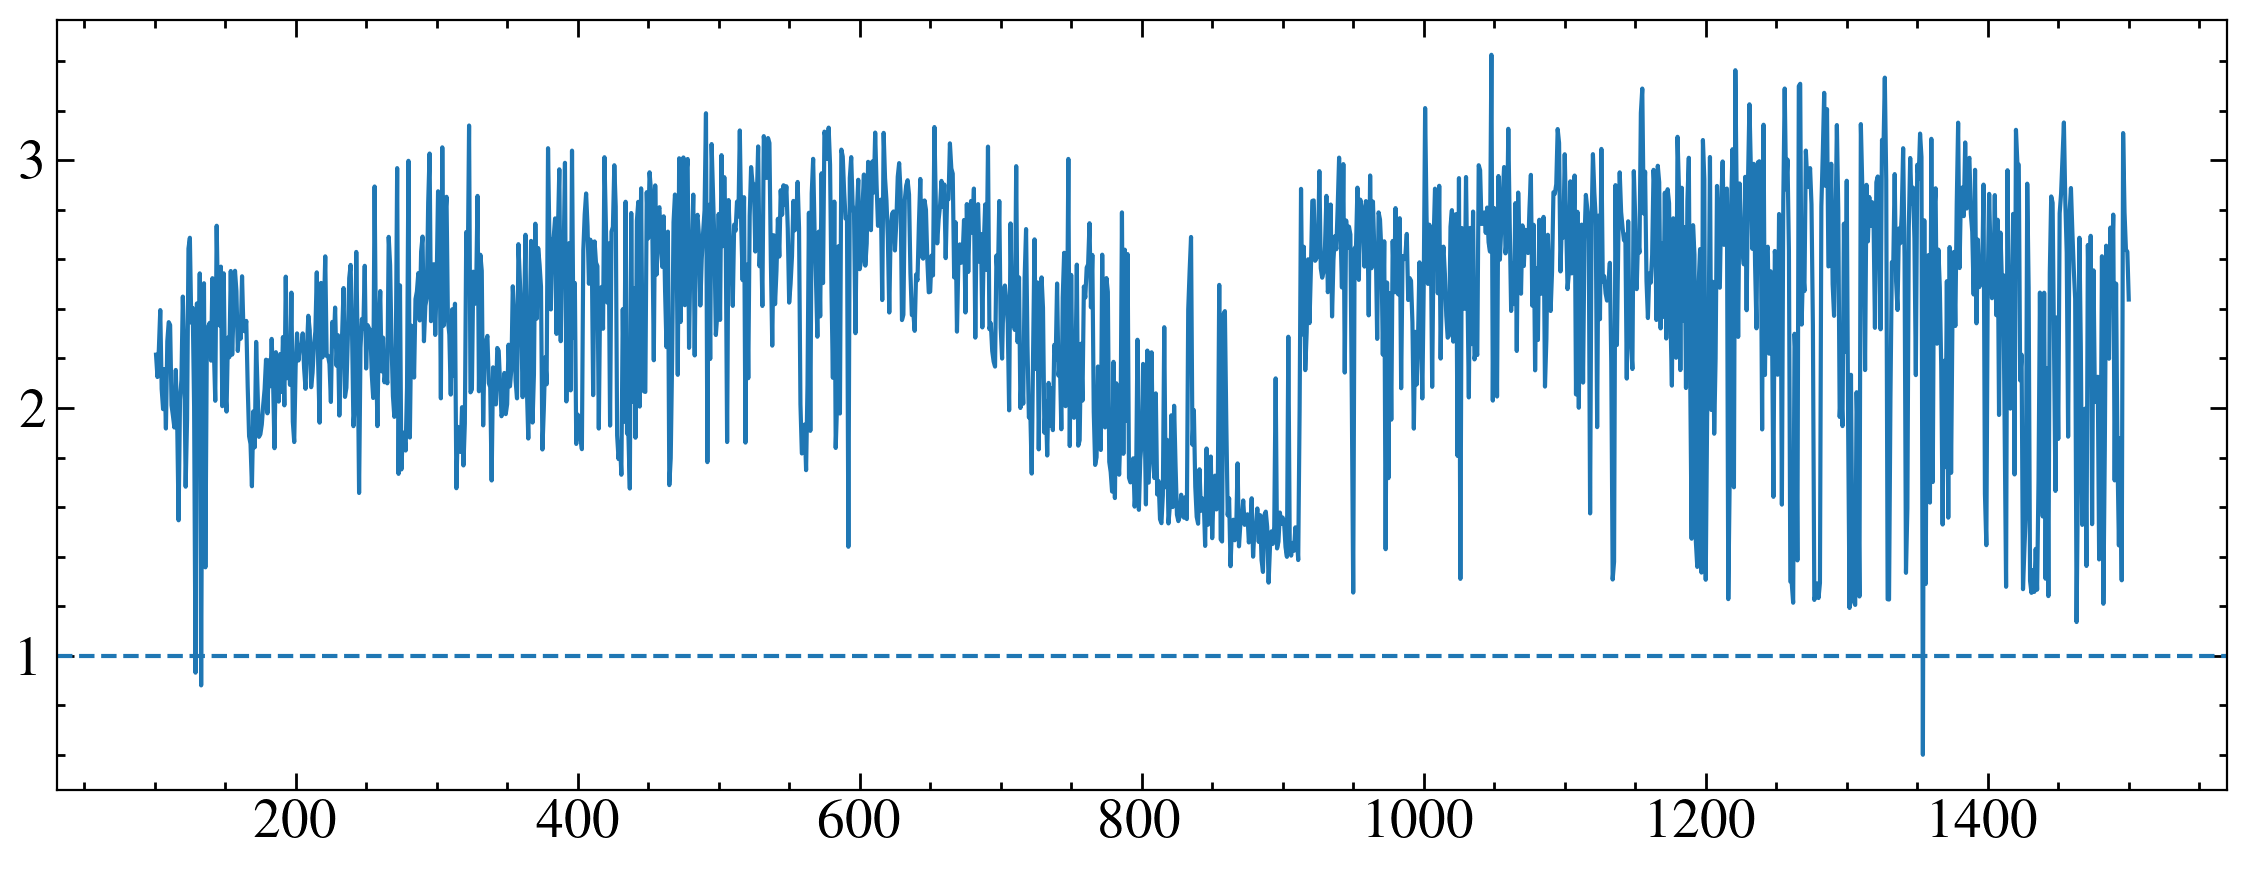

/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_lhs-2686_p17.fits
lhs-2686


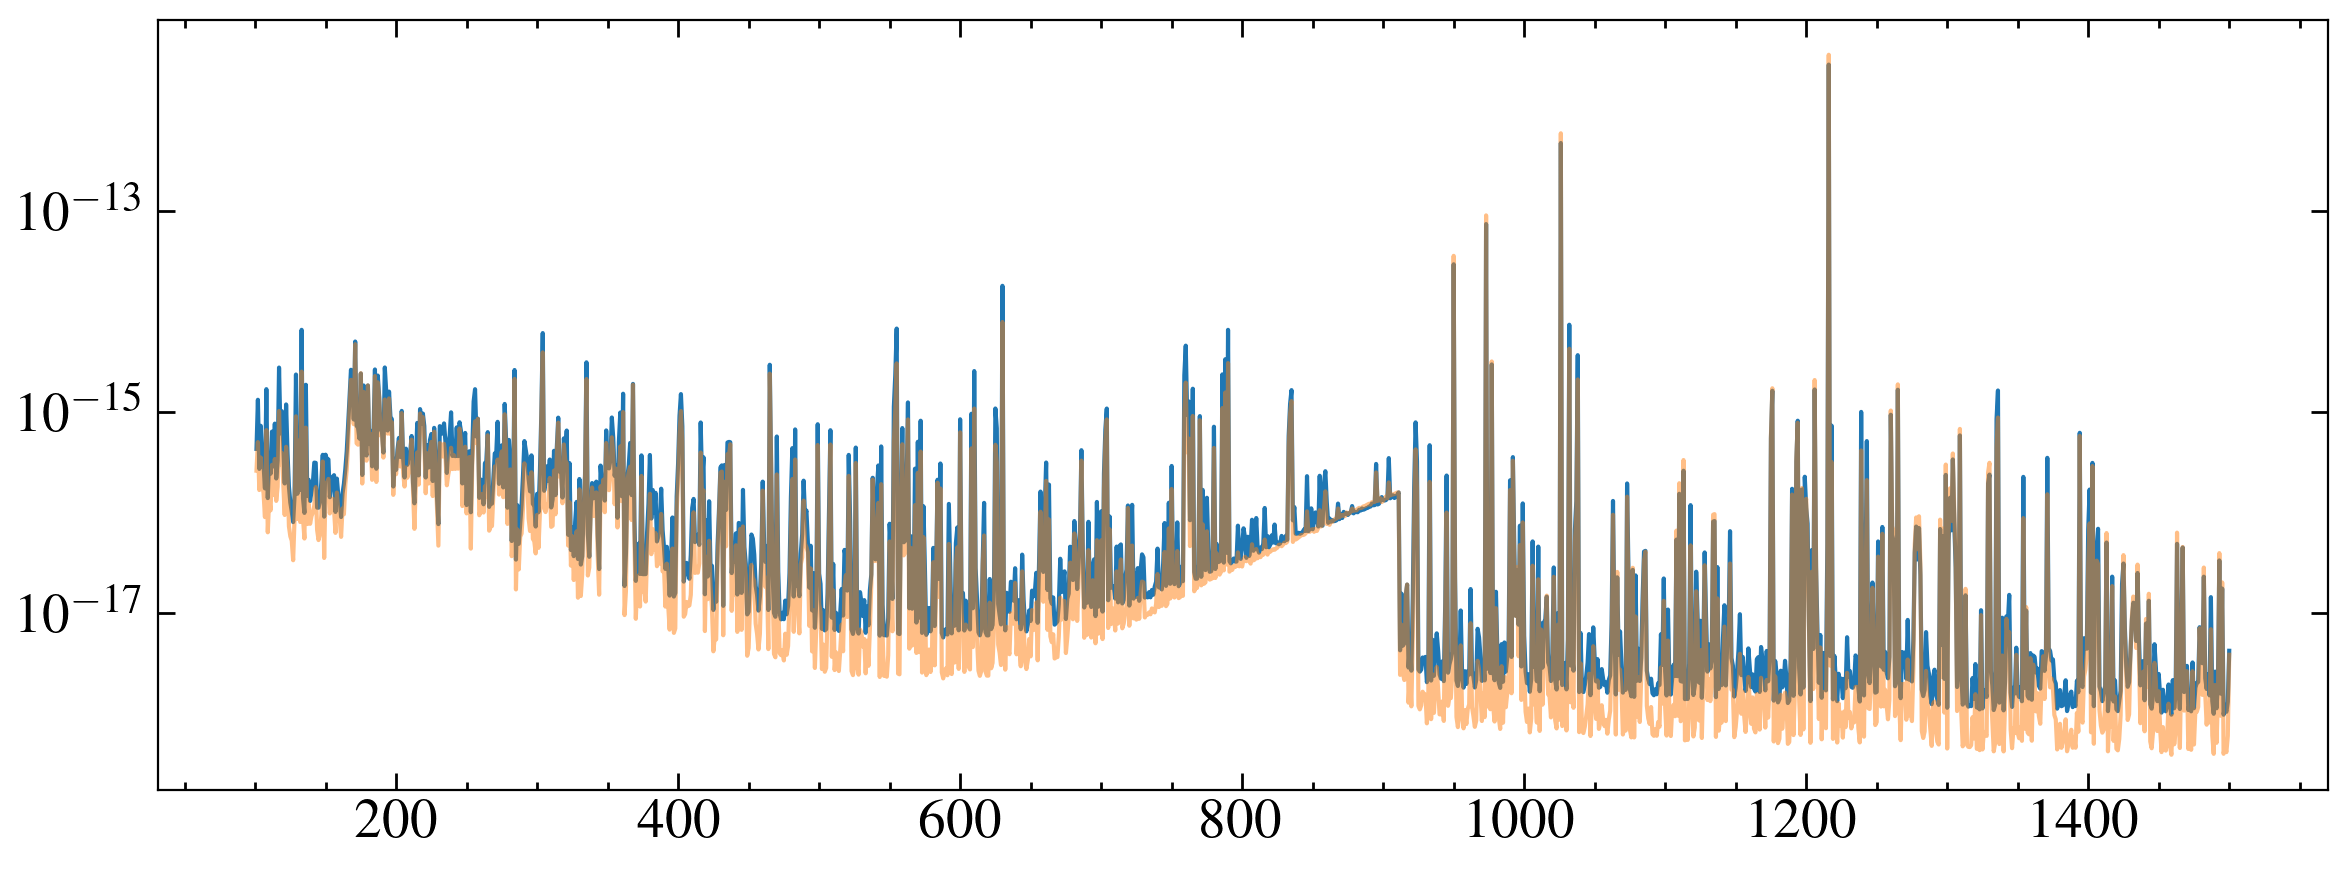

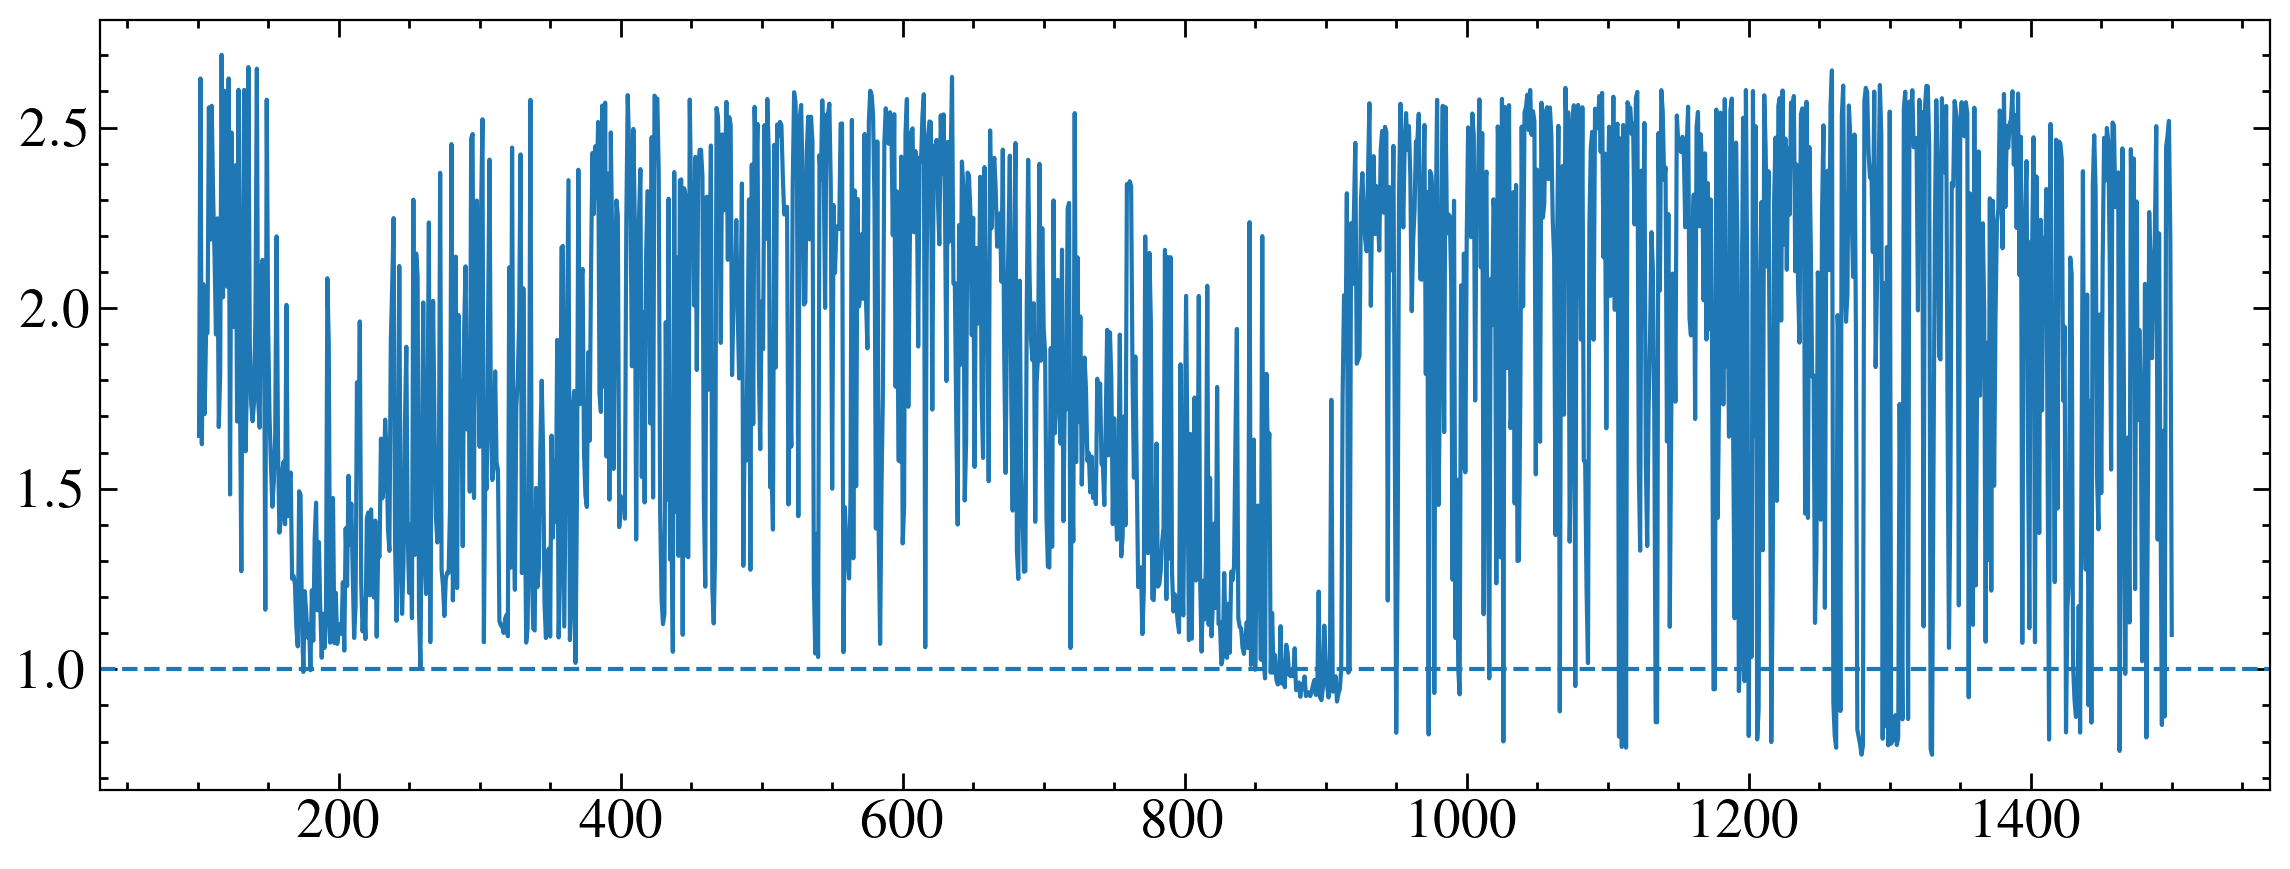

/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_trappist-1_p17.fits
trappist-1


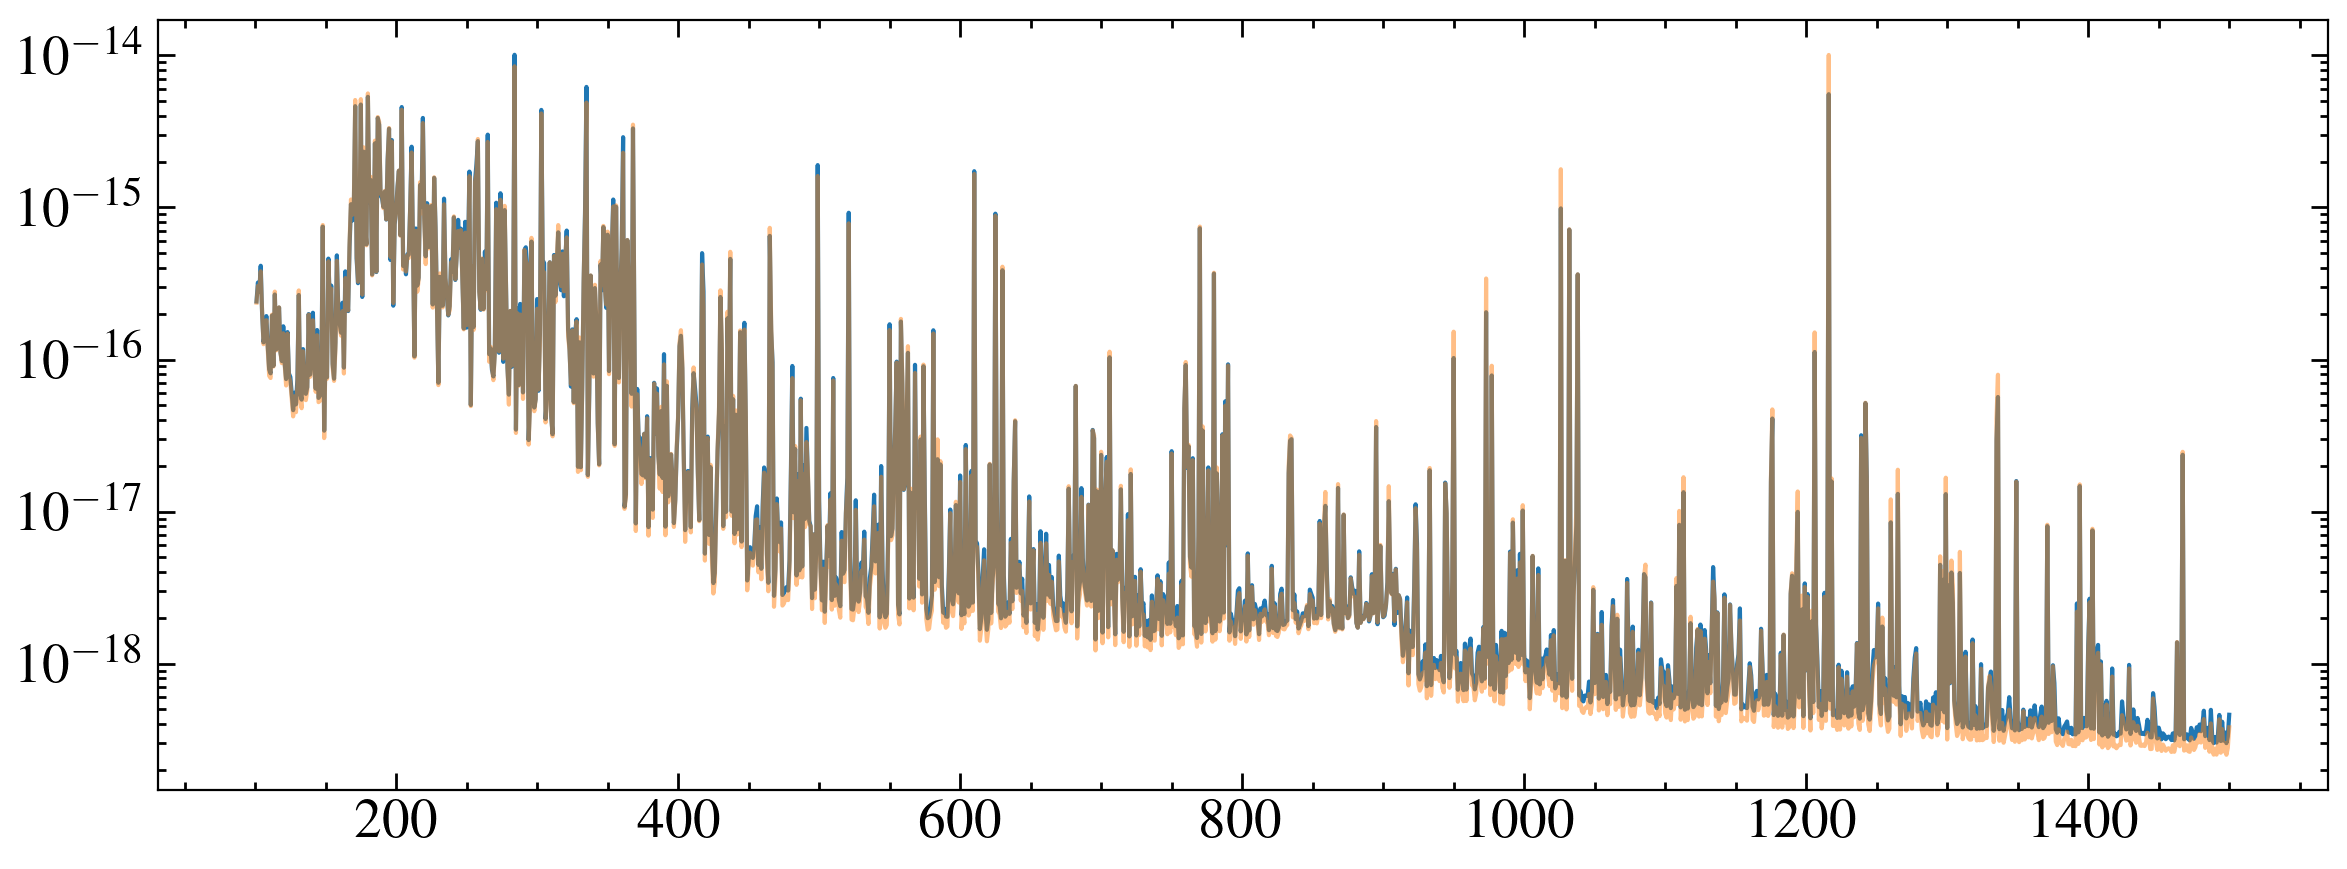

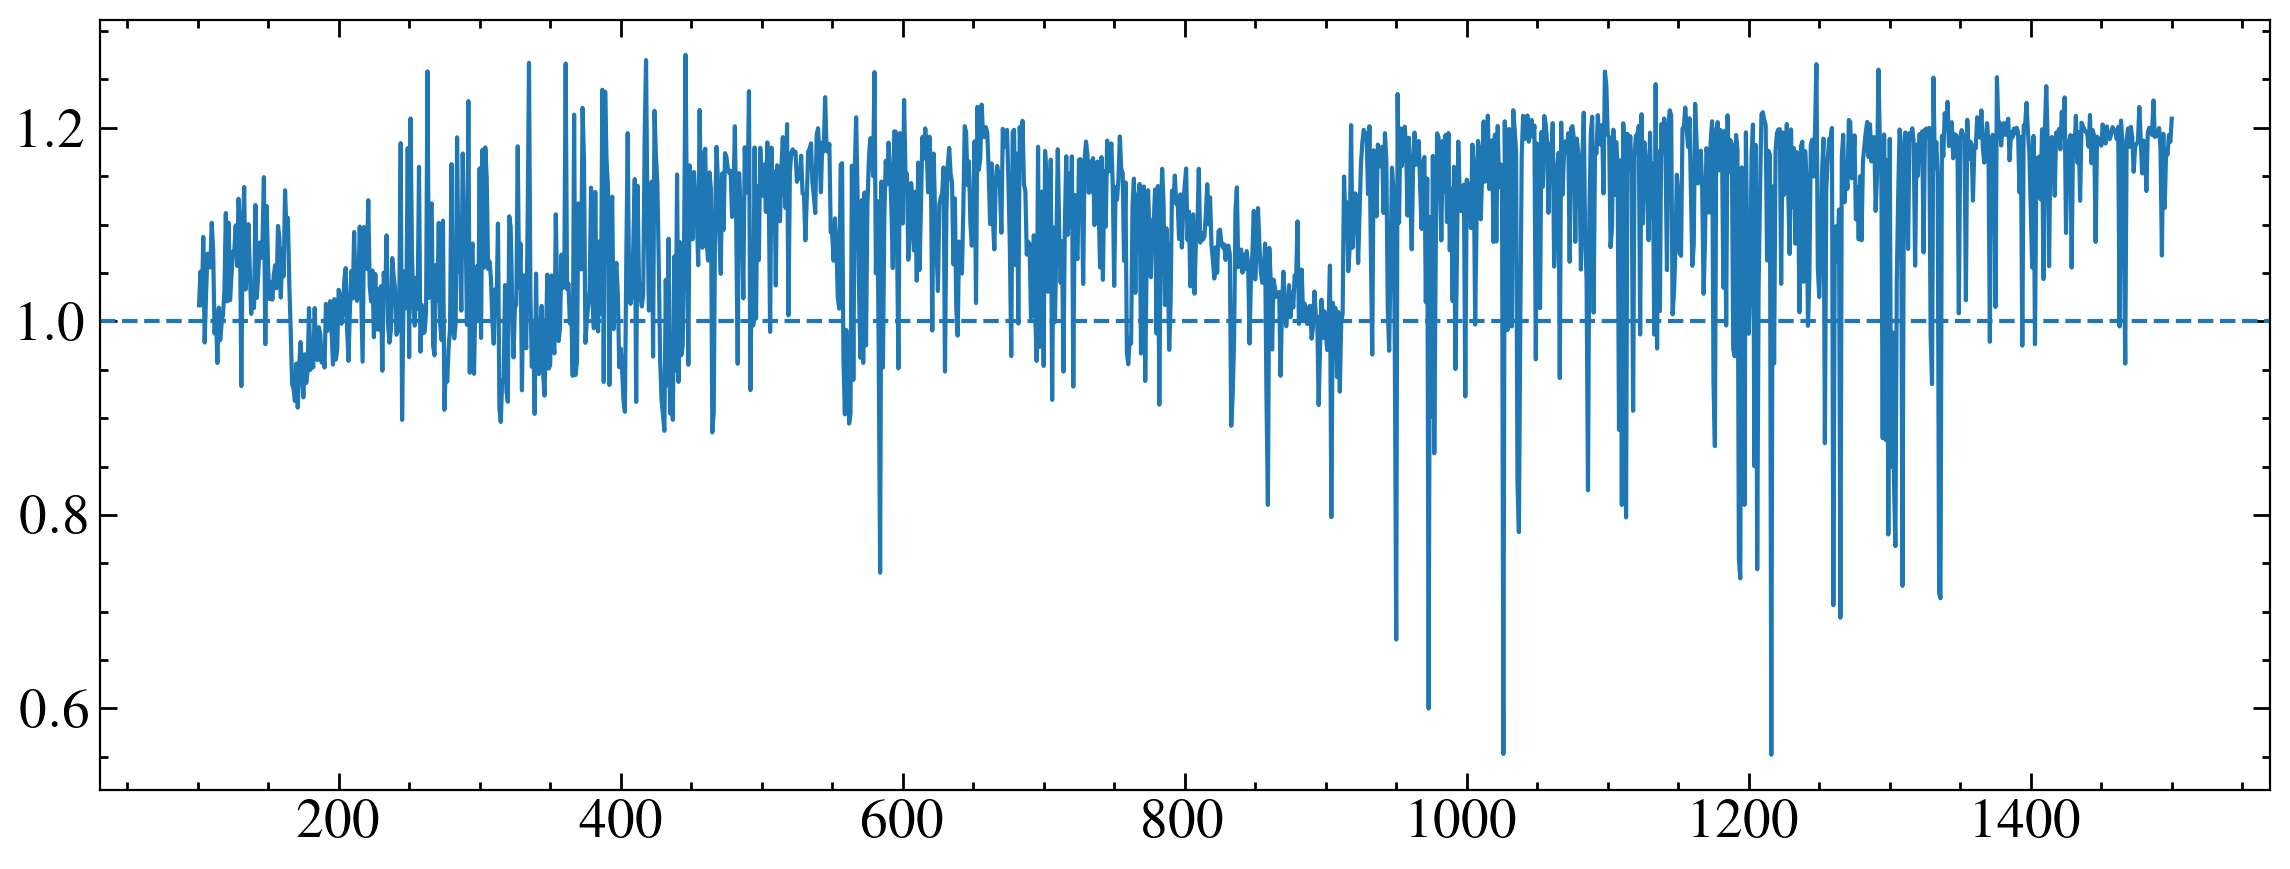

In [8]:
demstarnames = []

for dempath in dems:
        
    print(dempath)
    demstar = os.path.split(dempath)[1][9:-9]
    print(demstar)
    demstarnames.append(demstar)
    fig, ax = plt.subplots()
    dem = fits.getdata(dempath, 1)
    
    dw, df= dem['Wavelength'], dem['Flux_density']
    eu, el = dem['Upper_Error_84'], dem['Lower_Error_16']
    
    
    mean_e = np.mean([eu, el], axis=0)
    # plt.plot(dw, mean_e)
    # plt.yscale('log')
    
    log_mean_e = (eu - el) / (np.log(eu)- np.log(el))

    mask = dw > 100
    ax.plot(dw[mask], df[mask])
    ax.plot(dw[mask], log_mean_e[mask], alpha=0.5)
    # plt.plot(dw, mean_e)
    
    ax.set_yscale('log')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(dw[mask], df[mask]/log_mean_e[mask])
    ax.axhline(1, ls='--')

    plt.show()
    

# demtab = Table([dw, df, log_mean_e], names=['WAVELENGTH', 'FLUX', 'ERROR'])
# demtab.write('models/gj367_dem.ecsv', overwrite=True)

In [11]:
sedpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/'
stars = os.listdir(sedpath)

In [14]:
print(stars)
print(demstarnames)

starfix = np.array([i.replace('_', '').upper() for i in demstarnames])
print(starfix)

['GJ1132', 'GJ15A', 'GJ163', 'GJ649', 'GJ674', 'GJ676A', 'GJ699', 'GJ729', 'GJ849', 'L-980-5', 'LHS-2686', 'TRAPPIST-1']
['GJ_1132', 'gj_15A', 'gj_163', 'gj_649', 'gj_674', 'gj_676A', 'gj_729', 'gj_849', 'gj_876', 'l-980-5', 'lhs-2686', 'trappist-1']
['GJ1132' 'GJ15A' 'GJ163' 'GJ649' 'GJ674' 'GJ676A' 'GJ729' 'GJ849' 'GJ876'
 'L-980-5' 'LHS-2686' 'TRAPPIST-1']


In [16]:
seds = glob.glob('{}/*/*_var-res-sed.fits'.format(sedpath))
seds

['/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ1132/hlsp_muscles_multi_multi_gj1132_broadband_v24_var-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ15A/hlsp_muscles_multi_multi_gj15a_broadband_v24_var-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ163/hlsp_muscles_multi_multi_gj163_broadband_v24_var-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ649/hlsp_muscles_multi_multi_gj649_broadband_v24_var-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ674/hlsp_muscles_multi_multi_gj674_broadband_v24_var-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ676A/hlsp_muscles_multi_multi_gj676a_broadband_v24_var-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ699/hlsp_muscles_multi_multi_gj699_broadband_v24_var-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/GJ729/hlsp_muscles_multi_multi_gj729_broadband_v24_var-res-sed.fit

In [17]:
for sed in seds:
    print(fits.getheader(sed, 0)['TARGNAME'])

GJ1132
GJ15A
GJ163
GJ649
GJ674
GJ676A
GJ699
GJ729
GJ849
L-980-5
LHS-2686
2MASS-J23062928-0502285


In [24]:
import prepare_model

GJ1132
/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_GJ_1132_p17.fits
Spectrum saved as hlsp_muscles_model_dem_gj1132_na_v24_component-spec.fits


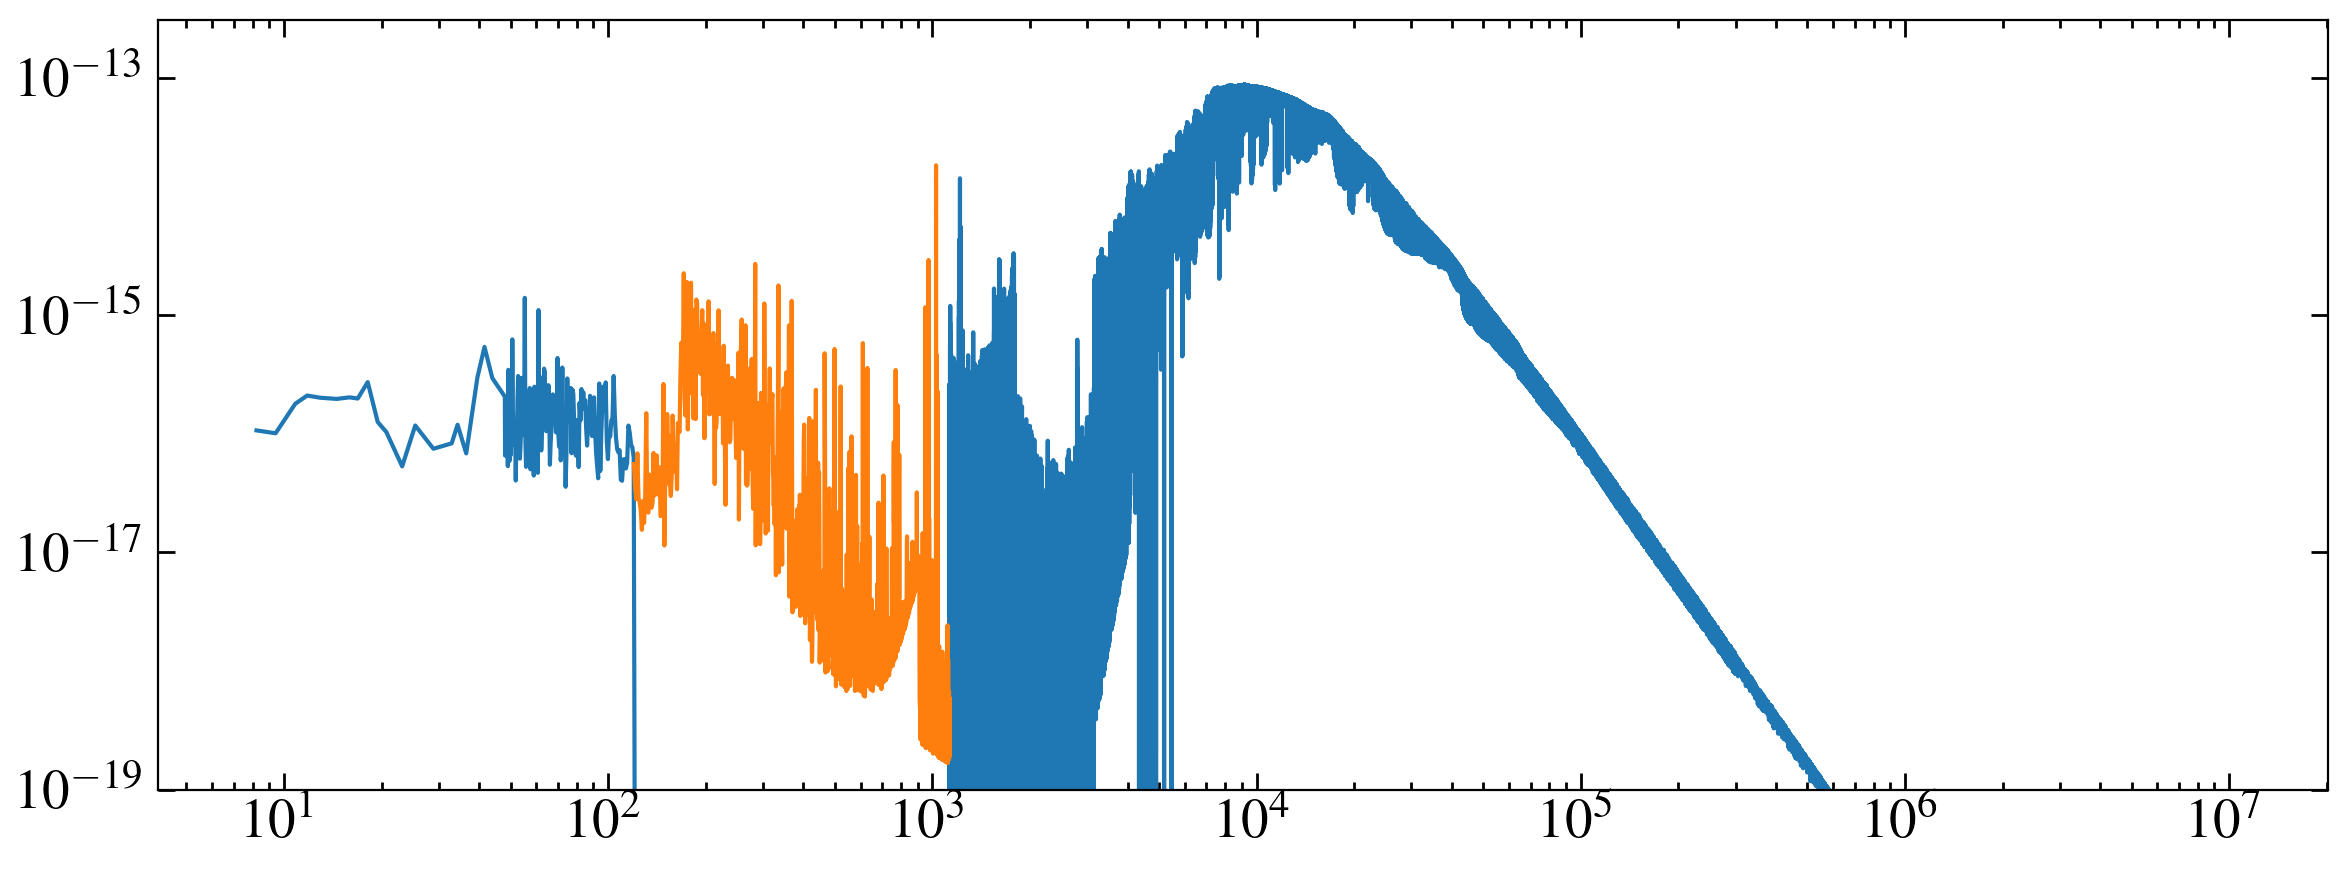

GJ15A
/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_15A_p17.fits
Spectrum saved as hlsp_muscles_model_dem_gj15a_na_v24_component-spec.fits


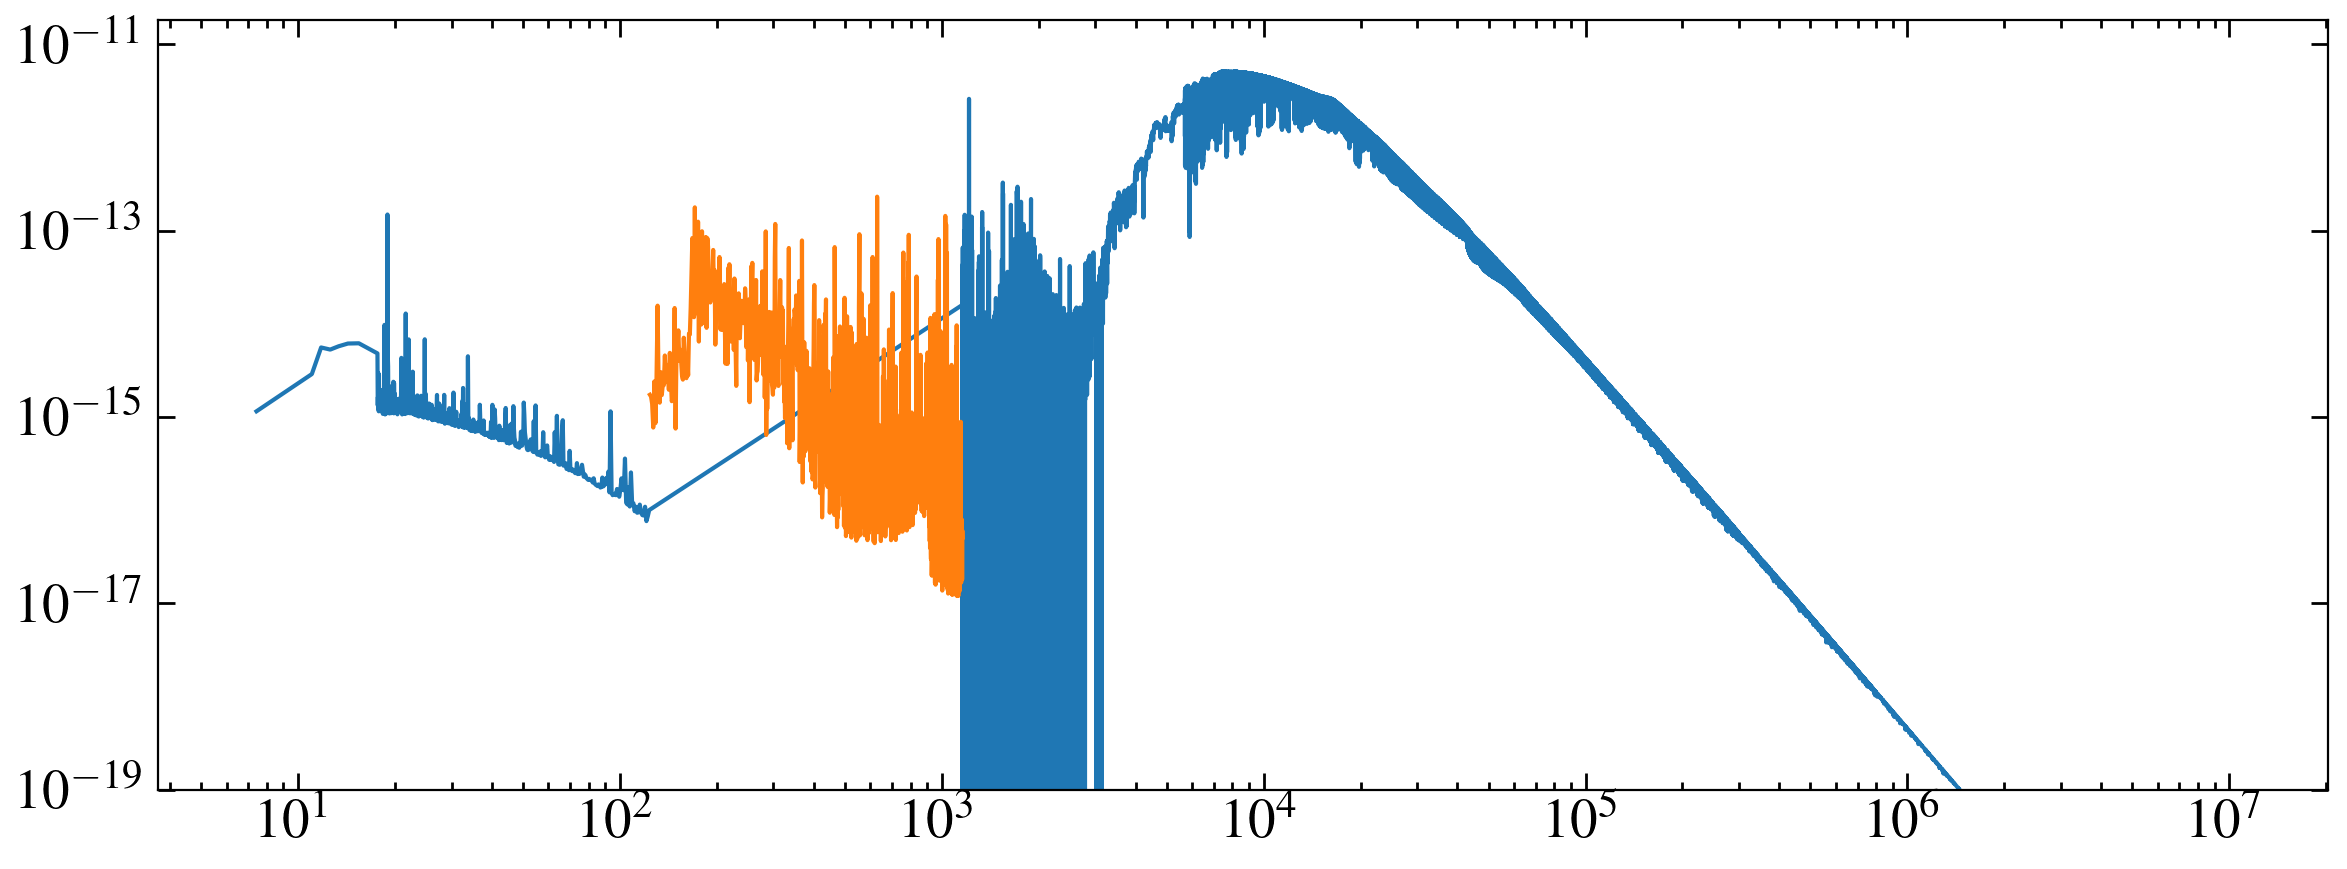

GJ163
/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_163_p17.fits
Spectrum saved as hlsp_muscles_model_dem_gj163_na_v24_component-spec.fits


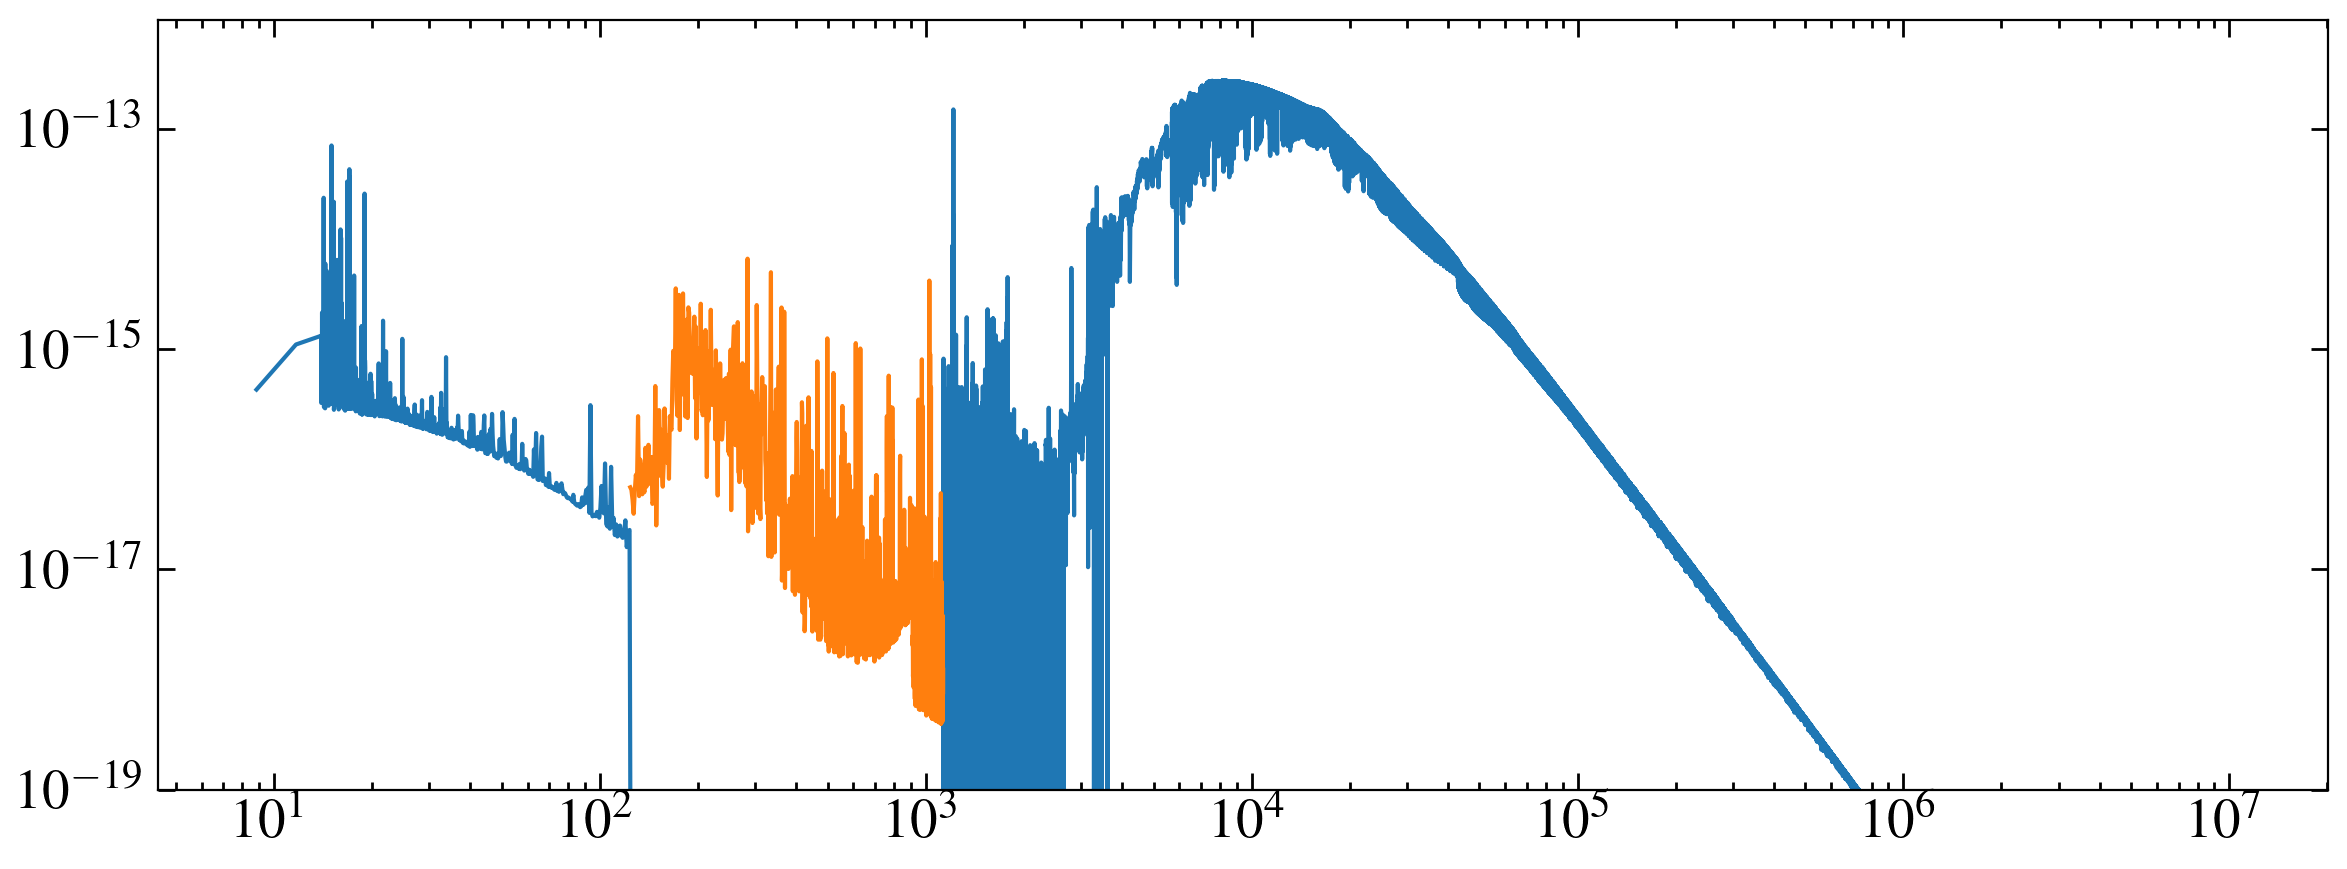

GJ649
/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_649_p17.fits
Spectrum saved as hlsp_muscles_model_dem_gj649_na_v24_component-spec.fits


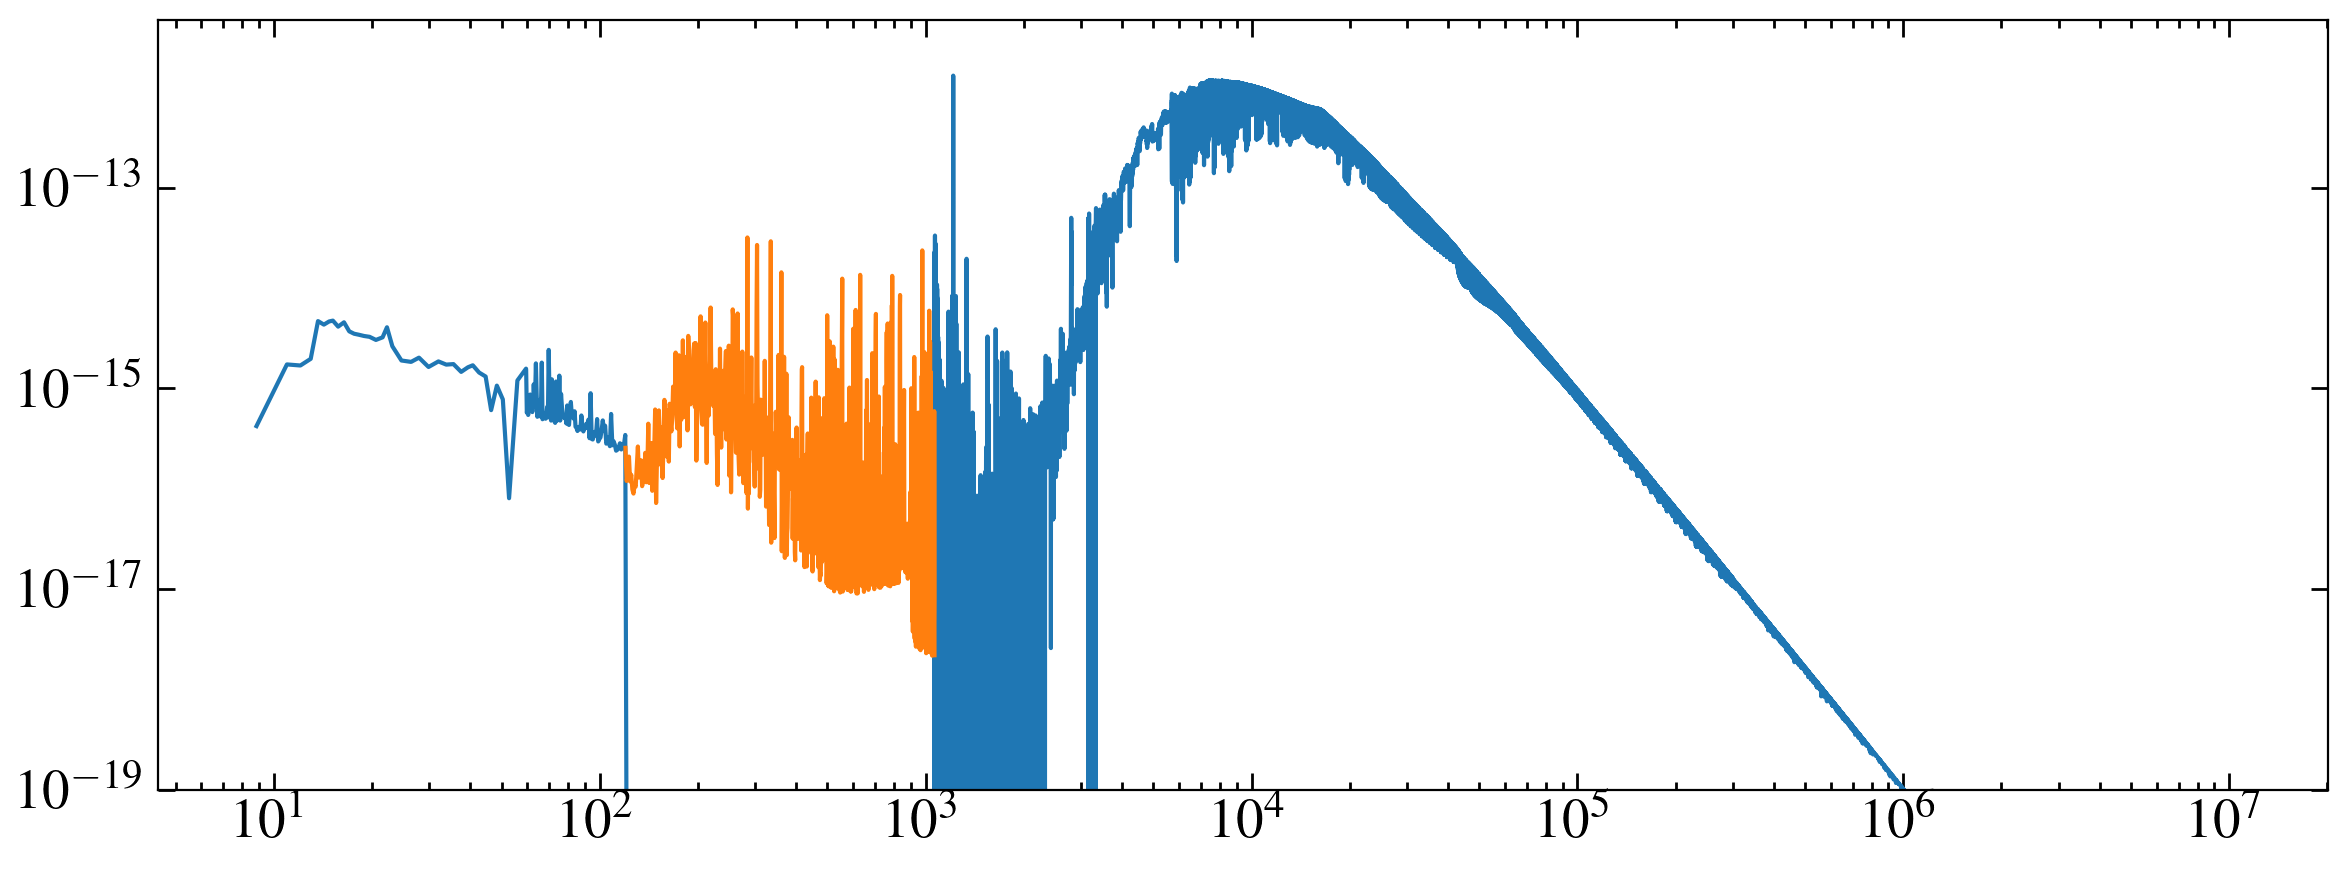

GJ674
/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_674_p17.fits
Spectrum saved as hlsp_muscles_model_dem_gj674_na_v24_component-spec.fits


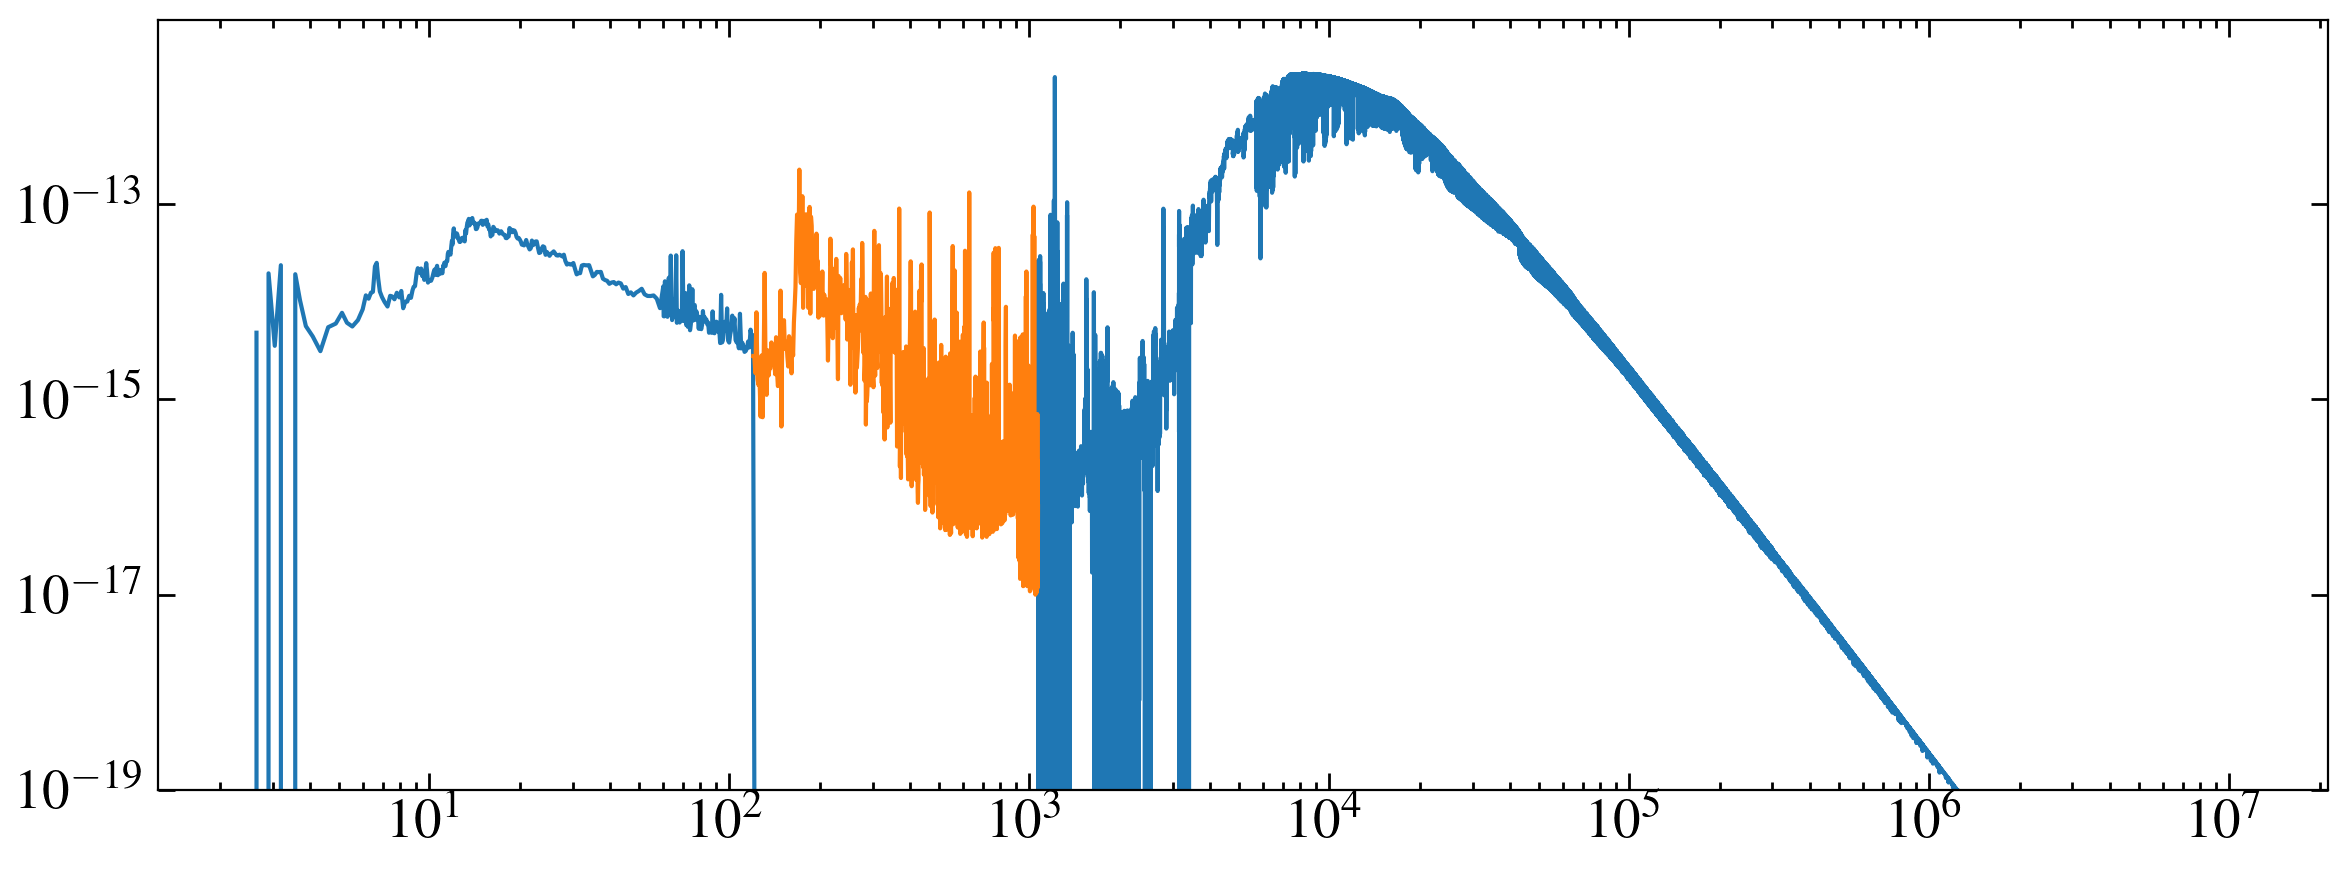

GJ676A
/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_676A_p17.fits
Spectrum saved as hlsp_muscles_model_dem_gj676a_na_v24_component-spec.fits


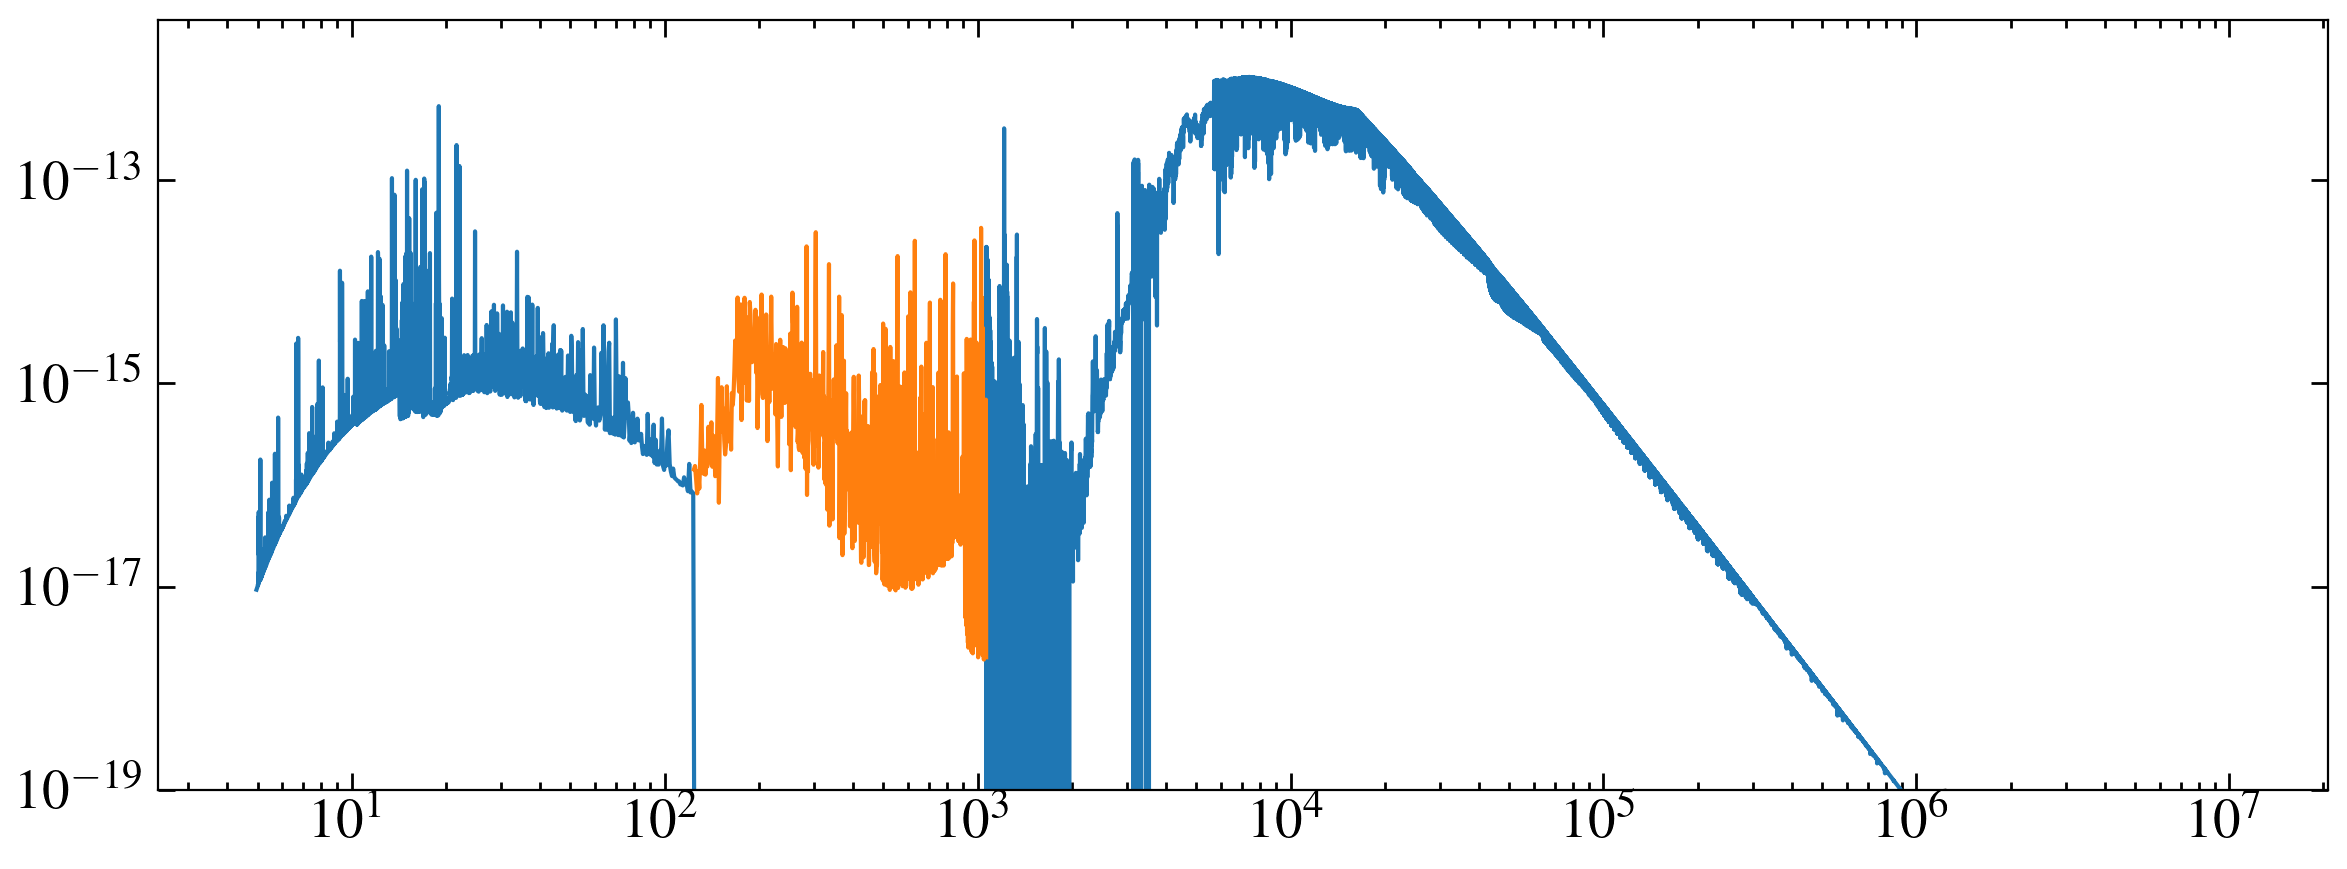

GJ699
Spectrum saved as hlsp_muscles_model_dem_gj699_na_v24_component-spec.fits


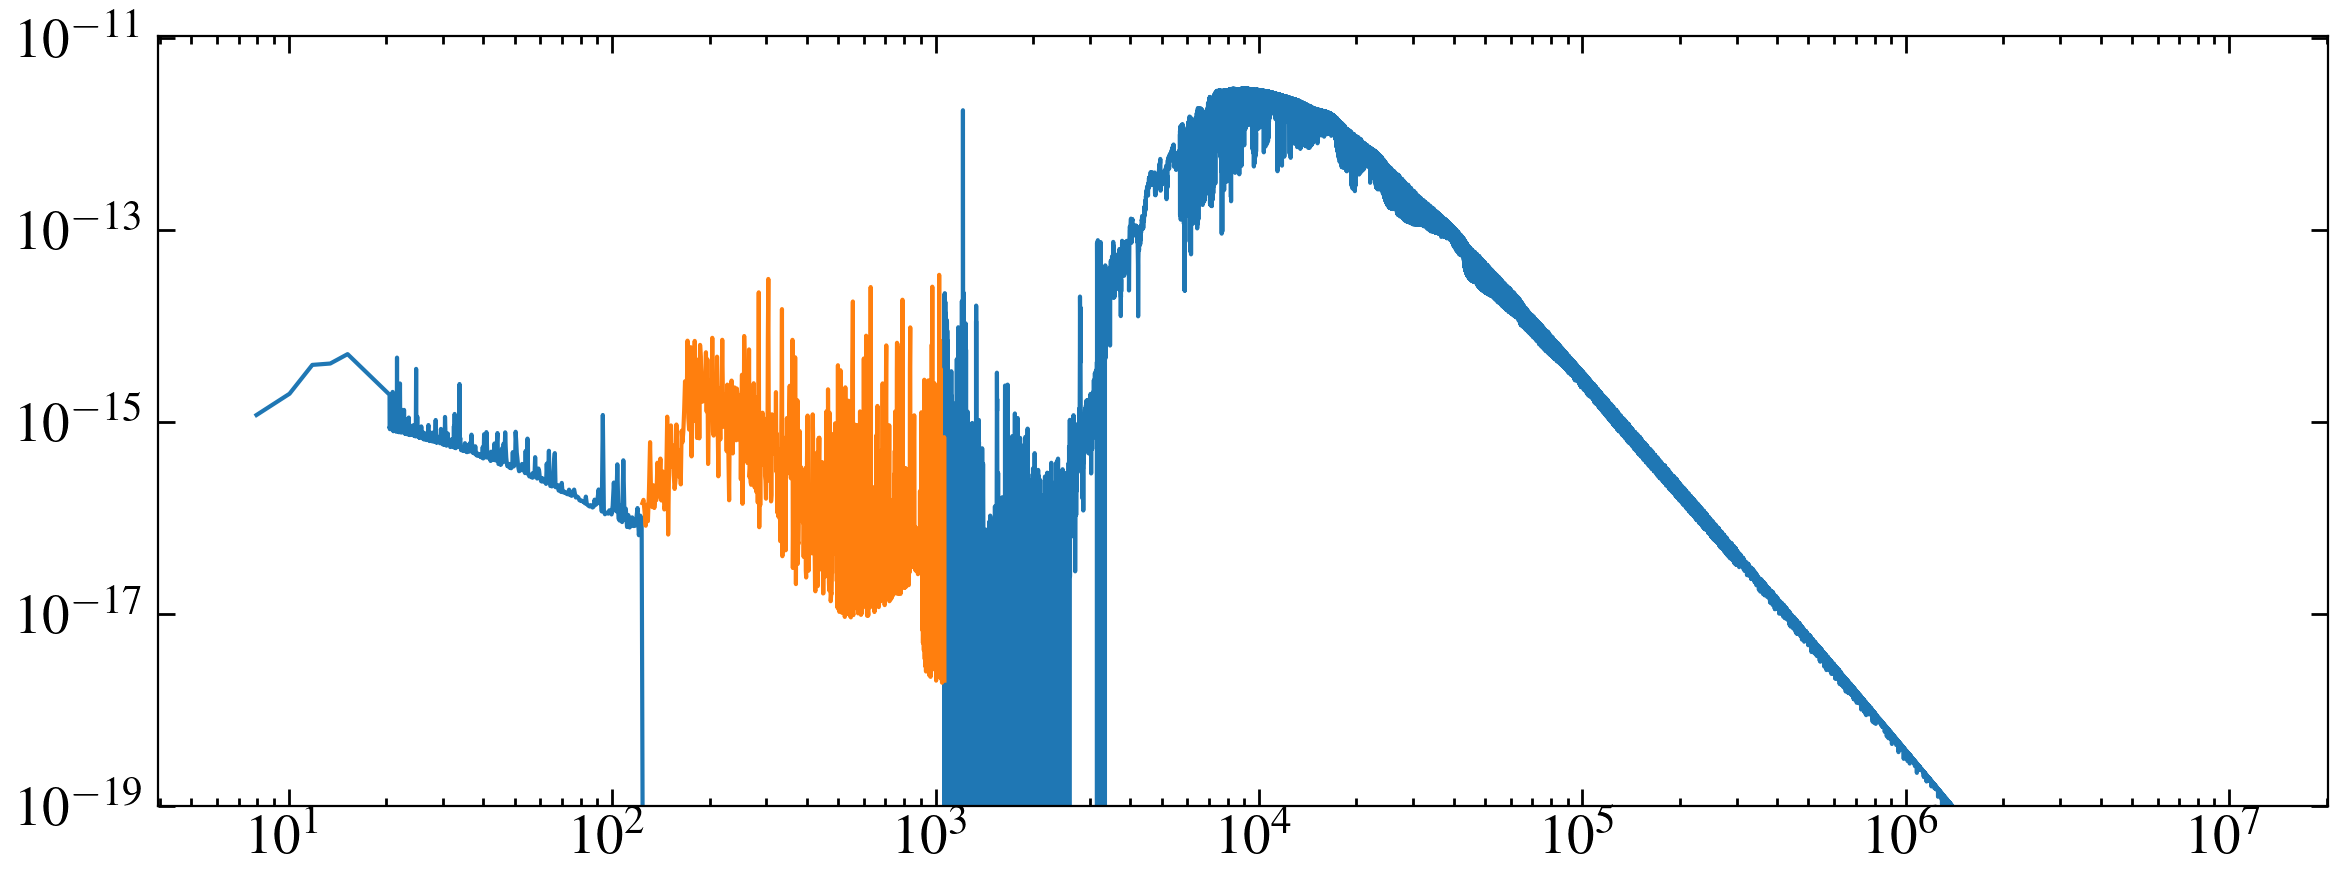

GJ729
/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_729_p17.fits
Spectrum saved as hlsp_muscles_model_dem_gj729_na_v24_component-spec.fits


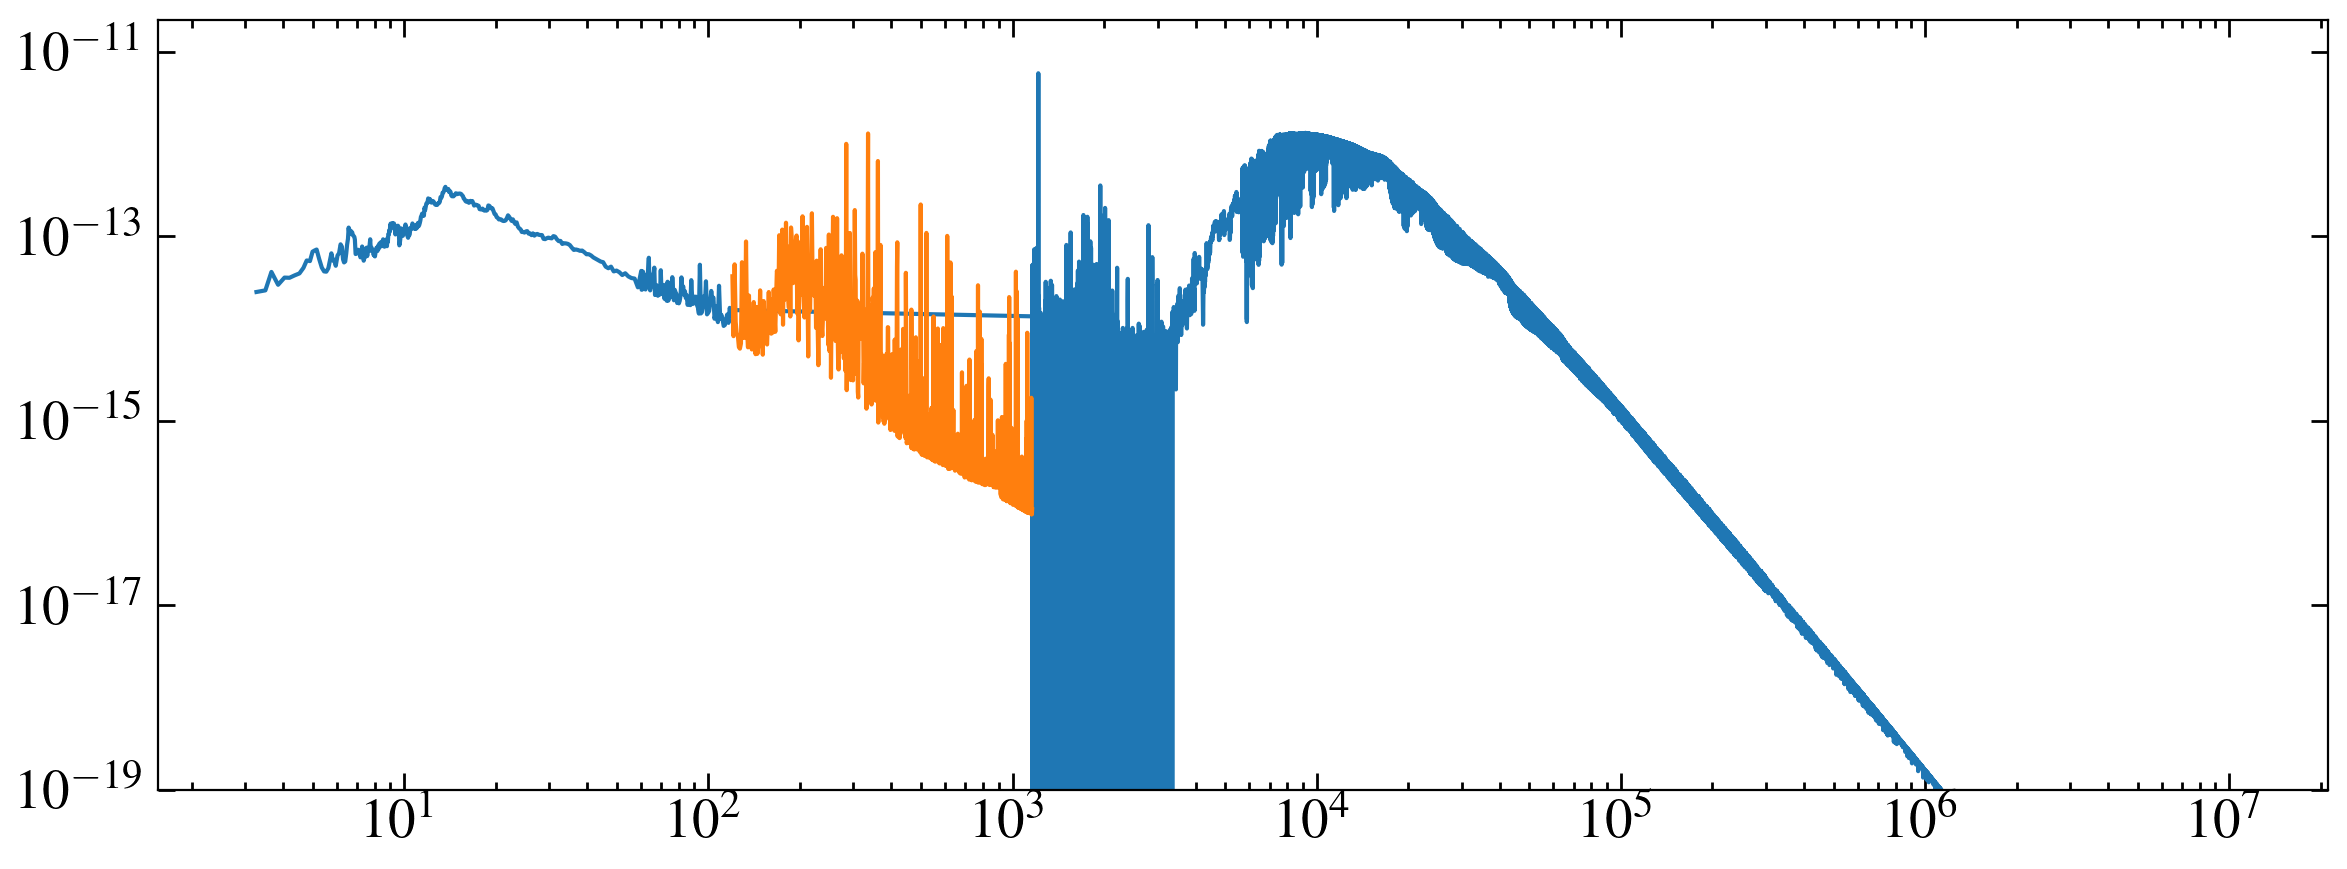

GJ849
/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_gj_849_p17.fits
Spectrum saved as hlsp_muscles_model_dem_gj849_na_v24_component-spec.fits


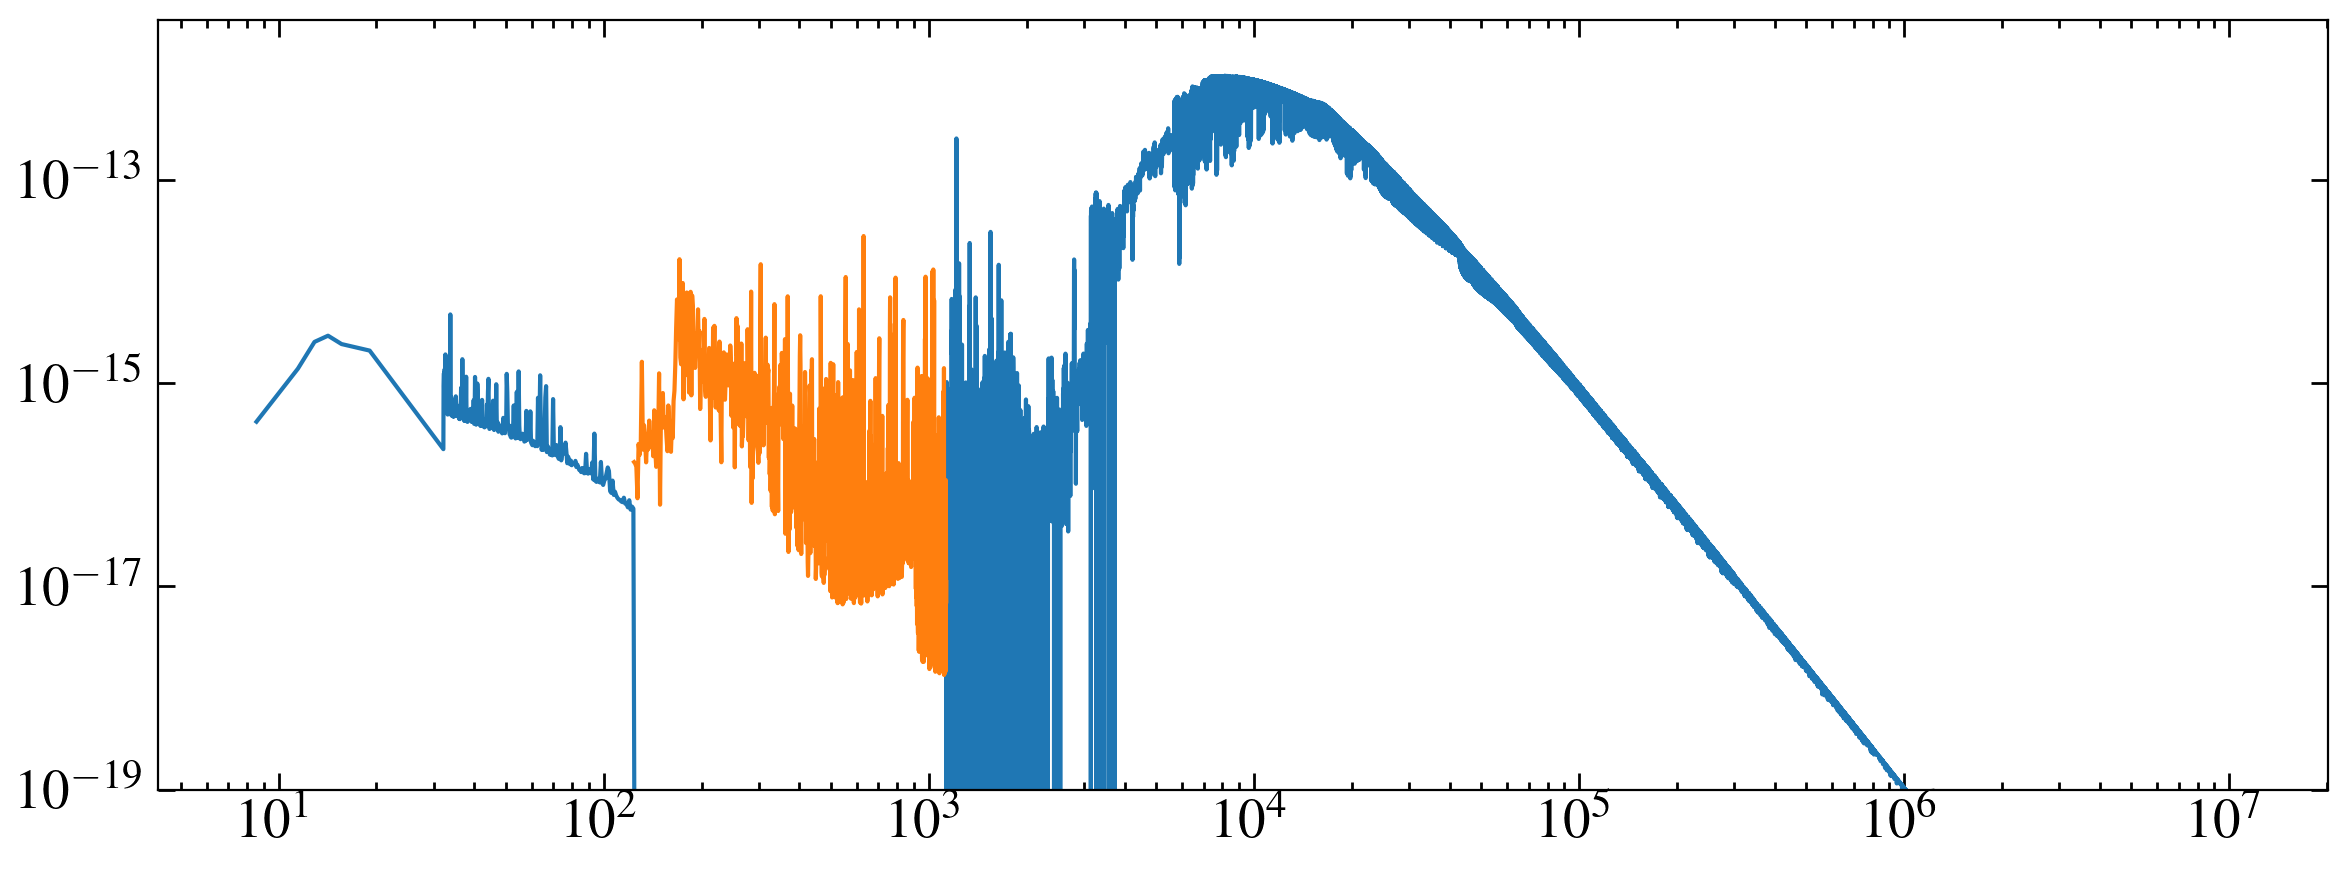

L-980-5
/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_l-980-5_p17.fits
Spectrum saved as hlsp_muscles_model_dem_l-980-5_na_v24_component-spec.fits


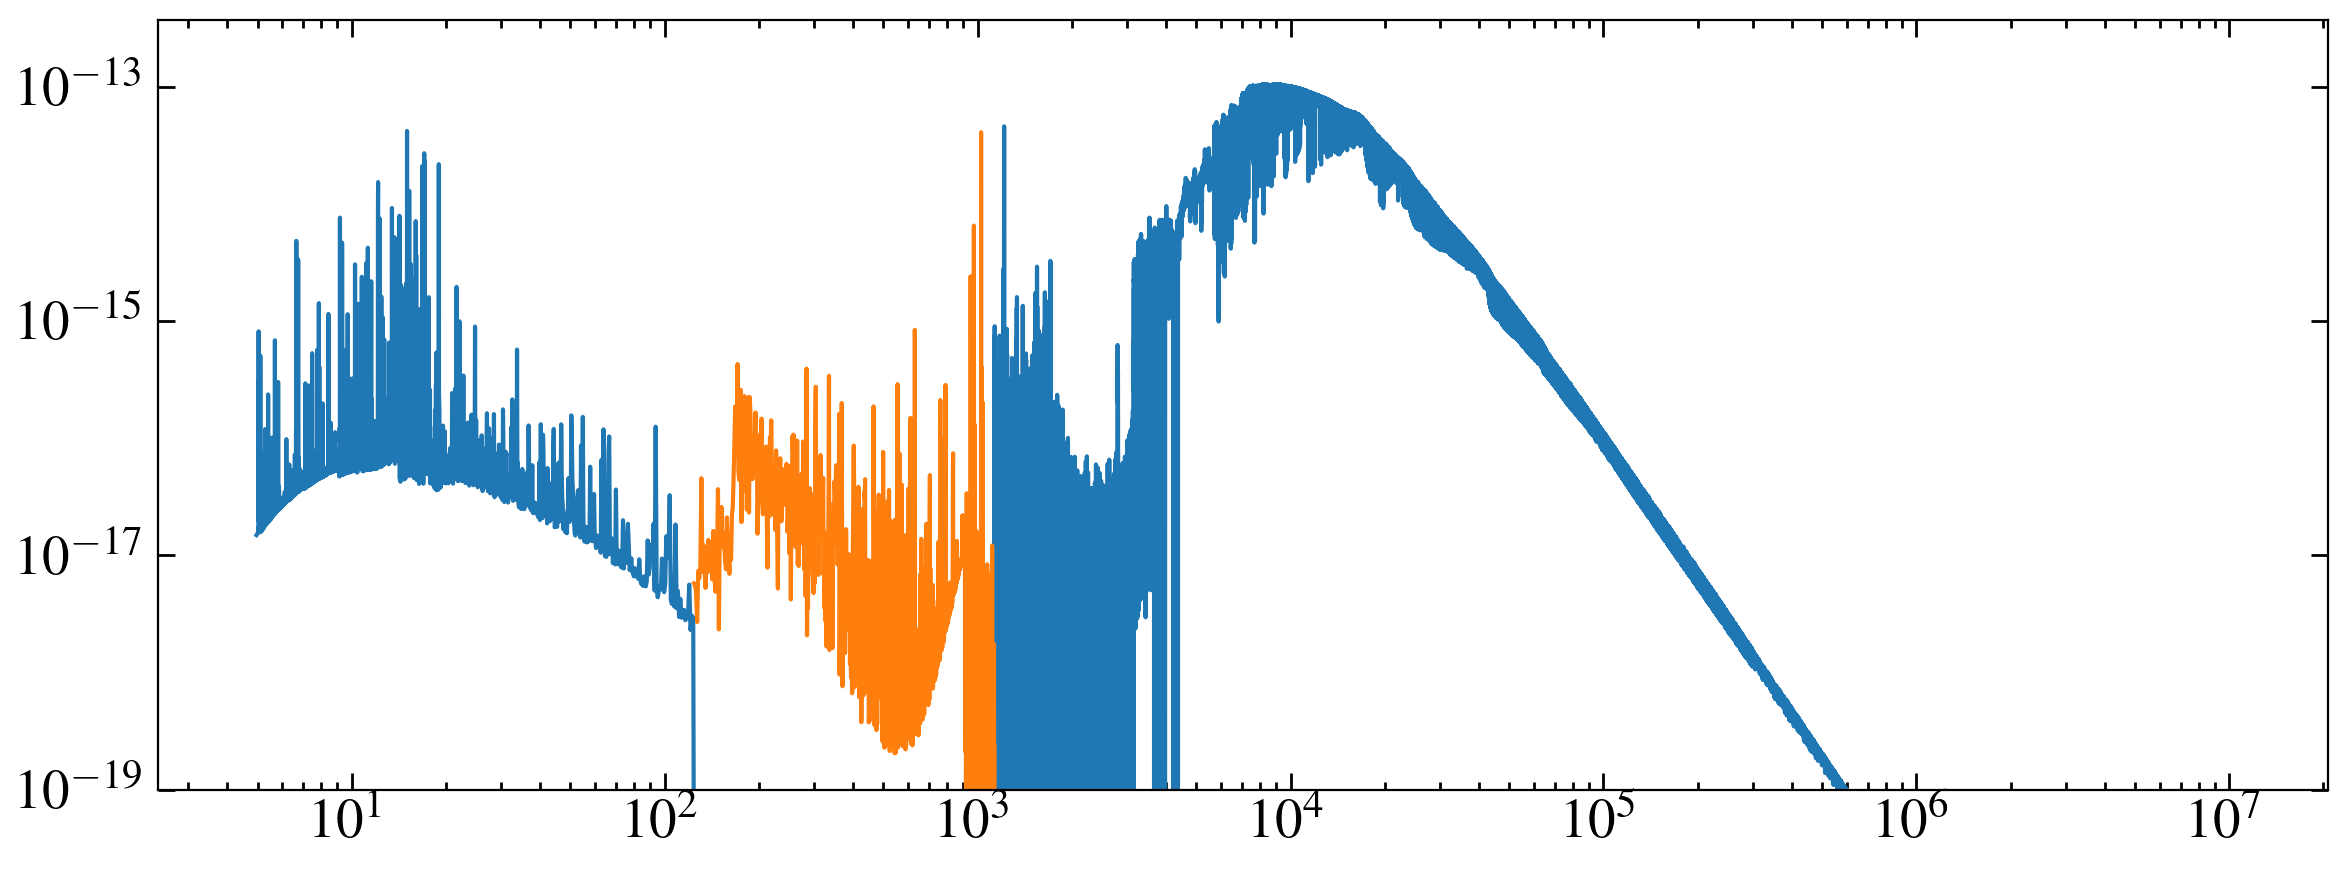

LHS-2686
/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_lhs-2686_p17.fits
Spectrum saved as hlsp_muscles_model_dem_lhs-2686_na_v24_component-spec.fits


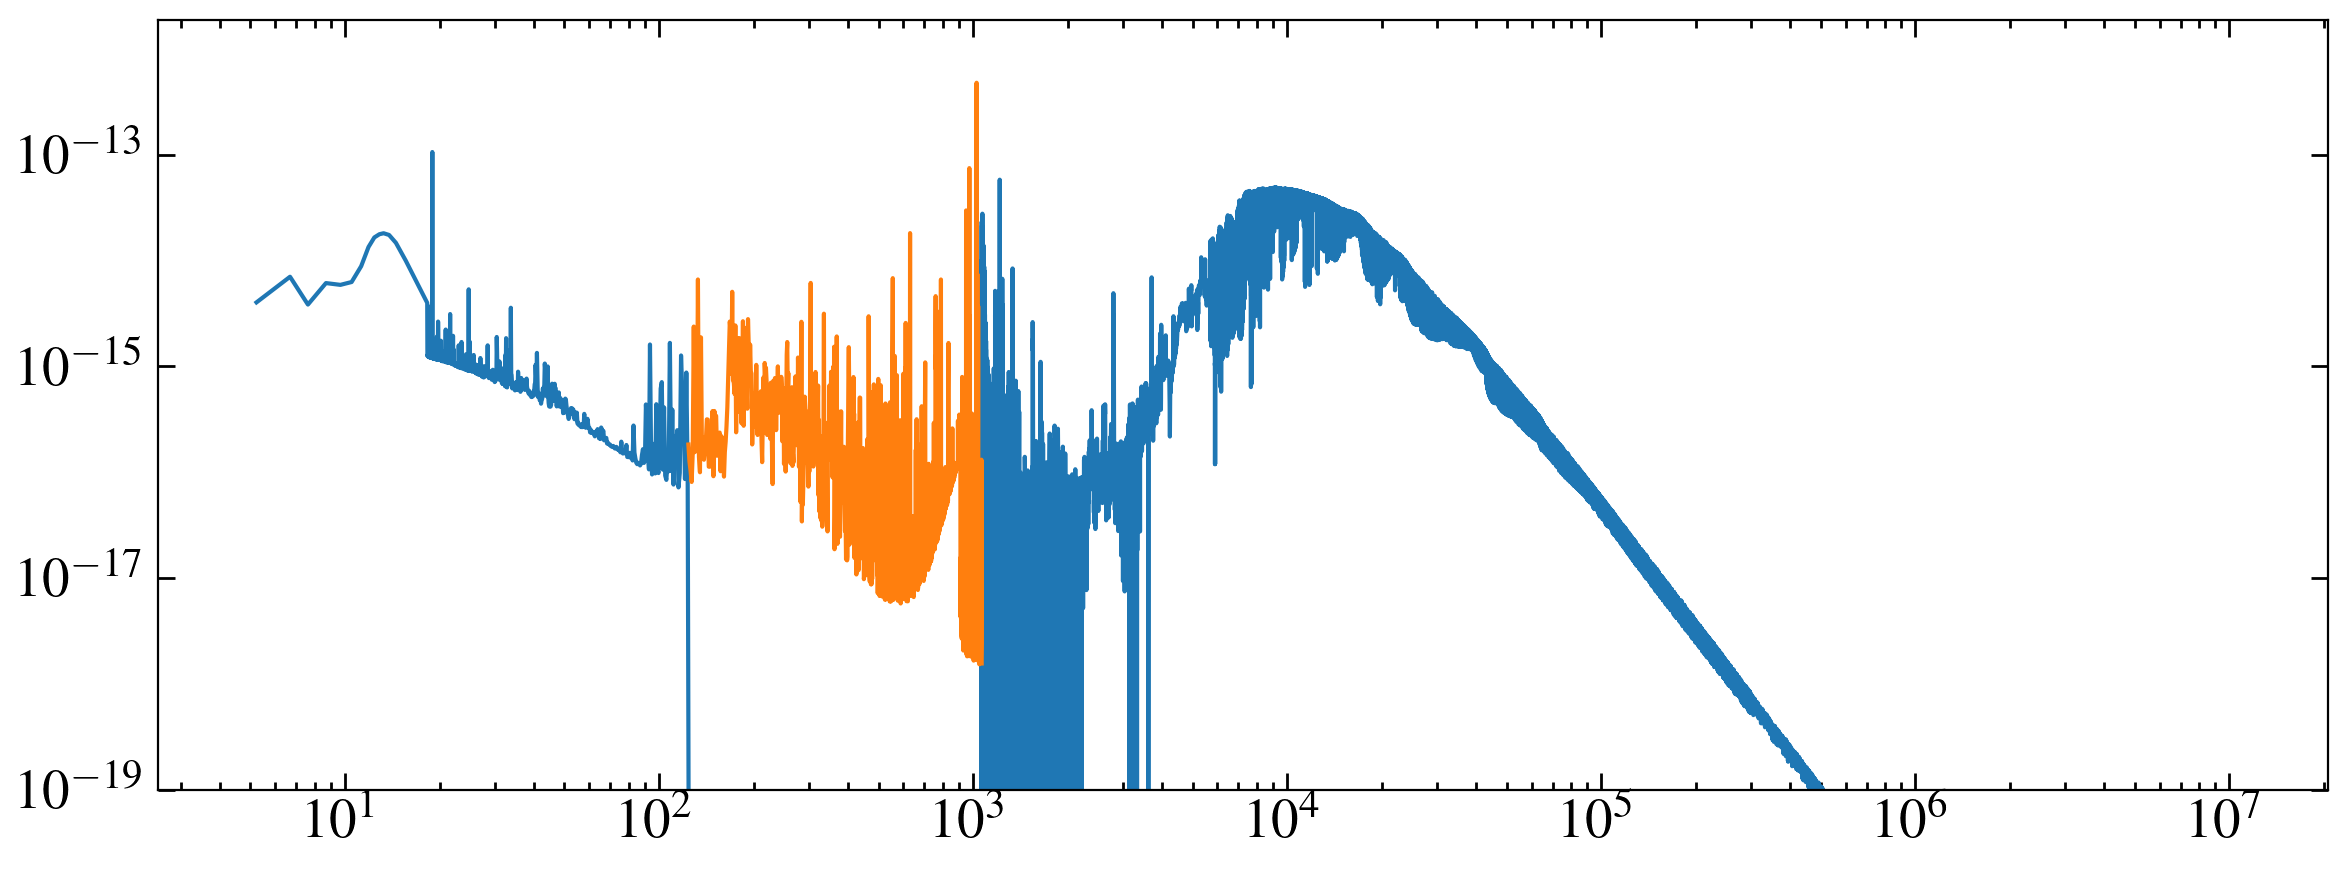

2MASS-J23062928-0502285
/media/david/2tb_ext_hd/hddata/mega_muscles/dems/spectrum_trappist-1_p17.fits
Spectrum saved as hlsp_muscles_model_dem_2mass-j23062928-0502285_na_v24_component-spec.fits


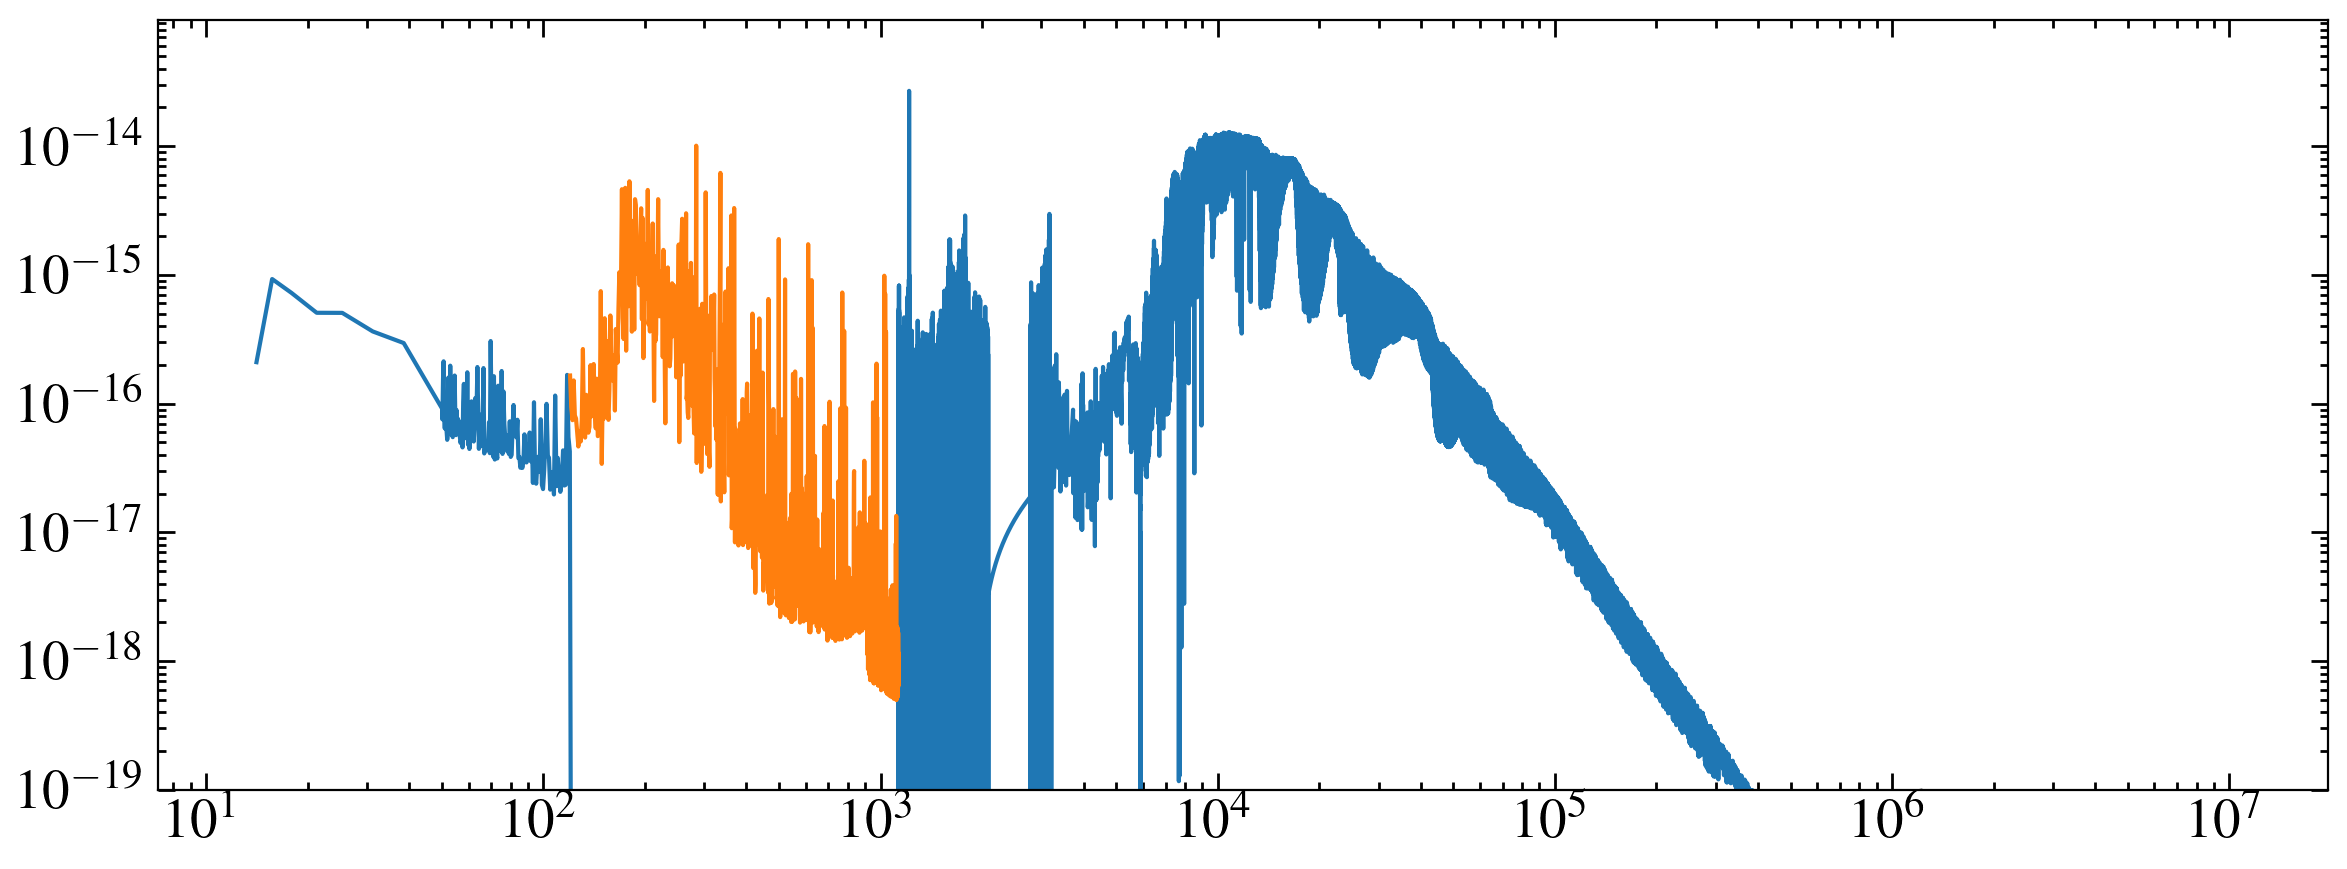

In [25]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) #adds an extravalue to make len(diff) = len(w)
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1
    
for sed in seds:
    fig, ax = plt.subplots()
    star = fits.getheader(sed, 0)['TARGNAME']
    print(star)
    if star == '2MASS-J23062928-0502285':
        star = 'TRAPPIST-1'
    data = fits.getdata(sed, 1)
    code = 16384

    for dempath in dems:
        demstar = os.path.split(dempath)[1][9:-9].replace('_', '').upper()
        if demstar == star:
            print(dempath)
            dem = fits.getdata(dempath, 1)
    
            dw, df= dem['Wavelength'], dem['Flux_density']
            eu, el = dem['Upper_Error_84'], dem['Lower_Error_16']
            
            
            # mean_e = np.mean([eu, el], axis=0)
        
            
            log_mean_e = (eu - el) / (np.log(eu)- np.log(el))
    euvmask = data['INSTRUMENT'] == 16384
    newsed = data[~euvmask]
    euv = data[euvmask]
    mask = (dw >= euv['WAVELENGTH'][0]) & (dw <= euv['WAVELENGTH'][-1])

    ax.plot(newsed['WAVELENGTH'], newsed['FLUX'])              
    ax.plot(dw[mask], df[mask])

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-19)



    g430l = glob.glob('{}{}/*g430l*'.format(sedpath, star))[0]
    hdr = fits.getheader(g430l, 0)

    w0, w1 = wavelength_edges(dw)
    
    # model_data = Table([dw*u.AA,w0*u.AA, w1*u.AA, df*u.erg/u.s/u.cm**2/u.AA,  log_mean_e*u.erg/u.s/u.cm**2/u.AA], names=['WAVELENGTH', 'WAVELENGTH0', 'WAVELENGTH1', 'FLUX', 'ERROR'])
    # savepath = '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/{}/'.format(star)

    # normfac = 1.0
    # metadata = prepare_model.make_model_metadata(model_data,  normfac, hdr, 'dem')
    # # savepath = 'new_euv_hlsp/'
    # version =24
    # prepare_model.model_save_to_fits(model_data, metadata, savepath, version)

    plt.show()
            
            
    


That was easy. Work out how to turn DEMS into hlsp under MM rules